In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pong

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pydot

tf.enable_eager_execution()

tf.__version__

'1.14.0'

In [18]:
SEQ_LEN = 128
W, H = 50, 50

data_input = lambda: pong.games_generator(W, H, SEQ_LEN)

make_dataset = lambda bs: tf.data.Dataset.from_generator(
    data_input,
    output_types=((tf.float32, tf.float32), (tf.float32, tf.bool)),
).batch(bs).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [19]:
class Model:
    def __init__(self, stateful=False):
        bs = 1 if stateful else None
        direction_inp = tf.keras.layers.Input(shape=(1), name='dir_input', batch_size=bs)
        user_input = tf.keras.layers.Input(shape=(None, 2), name='user_input', batch_size=bs)

        self.hidden_direction = tf.keras.layers.Dense(
            200,
            name='hidden_direction',
            activation='relu'
        )

        self.activation_direction = tf.keras.layers.Dense(
            200,
            name='activation_direction',
            activation='relu'
        )

        self.transformed_user_input = tf.keras.layers.LSTM(
            200,
            return_sequences=True,
            name='transformed_user_input',
            activation='relu'
        )

        self.x1 = tf.keras.layers.LSTM(
            200,
            return_sequences=True,
            name='x',
            stateful=stateful,
            activation='relu'
        )

        self.x2 = tf.keras.layers.GRU(
            200, return_sequences=True, name='x2',
            stateful=stateful,
            activation='relu'
        )
        self.x3 = tf.keras.layers.GRU(
            200, return_sequences=True, name='x3',
            stateful=stateful,
            activation='relu'
        )

        self.frames1 = tf.keras.layers.Dense(W * H, activation='sigmoid')
        self.frames2 = tf.keras.layers.Reshape((-1, W, H), name='frames')

        self.game_over1 = tf.keras.layers.Dense(1)
        self.game_over2 = tf.keras.layers.Lambda(
            lambda i: tf.squeeze(i, [-1], name='game_over')
        )
        
        hd = self.hidden_direction(direction_inp)
        ad = self.activation_direction(direction_inp)
        ui = self.transformed_user_input(user_input)
        x1 = self.x1(ui, initial_state=[ad, hd])
        x2 = self.x2(x1)
        x3 = self.x3(x2)
        f1 = self.frames1(x3)
        f2 = self.frames2(f1)
        g1 = self.game_over1(x3)
        g2 = self.game_over2(g1)

        self.net = tf.keras.Model([direction_inp, user_input], [f2, g2])

        self.net.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['mse', 'accuracy']
        )
        
    def copy_in_stateful_model(self):
        stateful = Model(stateful=True)
        for nb, layer in enumerate(self.net.layers):
            stateful.net.layers[nb].set_weights(layer.get_weights())
            
        return stateful

    def init(self, direction):
        direction = np.array(direction).reshape((1, 1))
        self.init_dir = tf.convert_to_tensor(direction, dtype=tf.float32)
        self.first_time = True
        
    def single_step_predict(self, user_input):
        user_input = np.array(user_input).reshape((1, 1, 2))
        user_input = tf.convert_to_tensor(user_input, dtype=tf.float32)
        ui = self.transformed_user_input(user_input)

        if self.first_time:
            self.first_time = False

            hd = self.hidden_direction(self.init_dir)
            ad = self.activation_direction(self.init_dir)
            x1 = self.x1(ui, initial_state=[ad, hd])
        else:
            x1 = self.x1(ui)

        x2 = self.x2(x1)
        x3 = self.x3(x2)
        f1 = self.frames1(x3)
        f2 = self.frames2(f1)
        g1 = self.game_over1(x3)
        g2 = self.game_over2(g1)
        
        return f2.numpy().reshape(50, 50), g2.numpy()

In [20]:
model = Model()
# model.net.summary()

In [21]:
# tf.keras.utils.plot_model(model.net, to_file='model.png')

In [22]:
def plot_pairwise_frames(frame_nums):
    X, Y = list(make_dataset(1).take(1))[0]
    (directions, controls), (frames, game_over) = X, Y
    pred_frames, _ = model.net.predict([directions, controls])

    plot_size = 2
    num_imgs = len(frame_nums)
    fig, axs = plt.subplots(2, num_imgs, figsize=(plot_size * num_imgs, plot_size * 2))

    for i, f in enumerate(frame_nums):
        l, r = (axs[0, i], axs[1, i])

        l.imshow(frames[0, f], cmap='bwr')
        r.imshow(pred_frames[0, f], cmap='bwr')

        l.set_xticklabels([])
        r.set_xticklabels([])
        l.set_yticklabels([])
        r.set_yticklabels([])

    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [23]:
frame_nums = [1, 4, 8, 16, 32, 64, 127]

In [24]:
class PlotCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, batch, logs=None):
        plot_pairwise_frames(frame_nums)
        plt.show()
        
callbacks = [PlotCallback()]

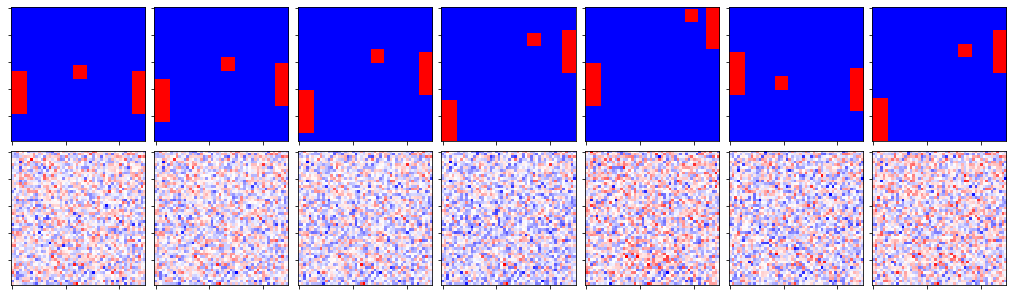

Epoch 1/250
100/100 [==============================] - 116s 1s/step - loss: 0.8874 - frames_loss: 0.4437 - lambda_1_loss: 0.4437 - frames_mean_squared_error: 0.1427 - frames_acc: 0.9094 - lambda_1_mean_squared_error: inf - lambda_1_acc: 0.9556 - val_loss: 0.7845 - val_frames_loss: 0.1819 - val_lambda_1_loss: 0.6025 - val_frames_mean_squared_error: 0.0538 - val_frames_acc: 0.9229 - val_lambda_1_mean_squared_error: 1.0309 - val_lambda_1_acc: 0.9609


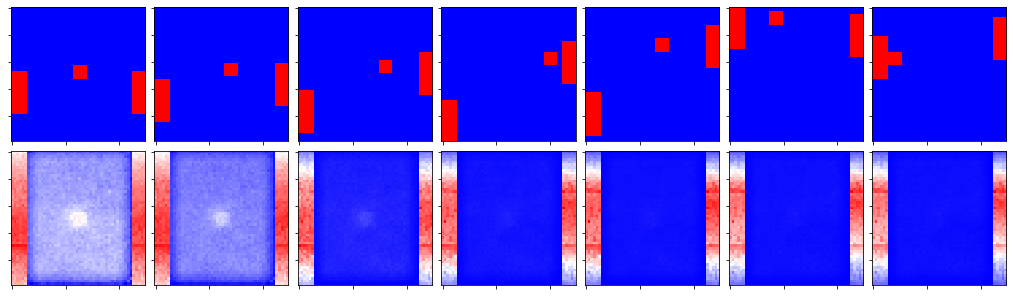

Epoch 2/250
100/100 [==============================] - 110s 1s/step - loss: 0.8735 - frames_loss: 0.1654 - lambda_1_loss: 0.7081 - frames_mean_squared_error: 0.0484 - frames_acc: 0.9307 - lambda_1_mean_squared_error: 39.4982 - lambda_1_acc: 0.9518 - val_loss: 0.6601 - val_frames_loss: 0.1498 - val_lambda_1_loss: 0.5103 - val_frames_mean_squared_error: 0.0436 - val_frames_acc: 0.9379 - val_lambda_1_mean_squared_error: 65.7791 - val_lambda_1_acc: 0.9669


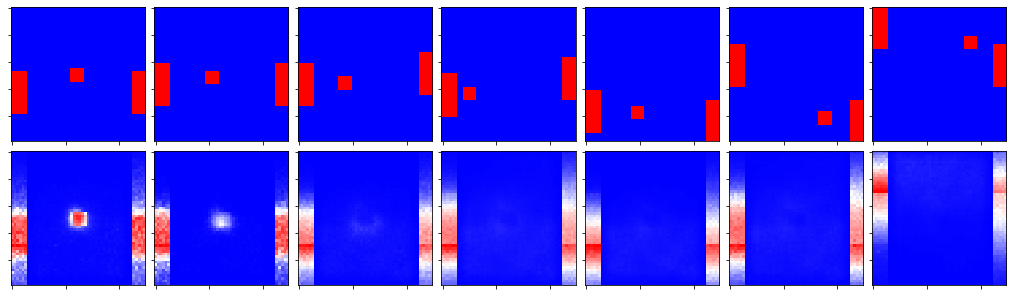

Epoch 3/250
100/100 [==============================] - 111s 1s/step - loss: 0.8862 - frames_loss: 0.1367 - lambda_1_loss: 0.7495 - frames_mean_squared_error: 0.0390 - frames_acc: 0.9463 - lambda_1_mean_squared_error: 95.2135 - lambda_1_acc: 0.9514 - val_loss: 0.6935 - val_frames_loss: 0.1267 - val_lambda_1_loss: 0.5668 - val_frames_mean_squared_error: 0.0360 - val_frames_acc: 0.9505 - val_lambda_1_mean_squared_error: 103.1679 - val_lambda_1_acc: 0.9633


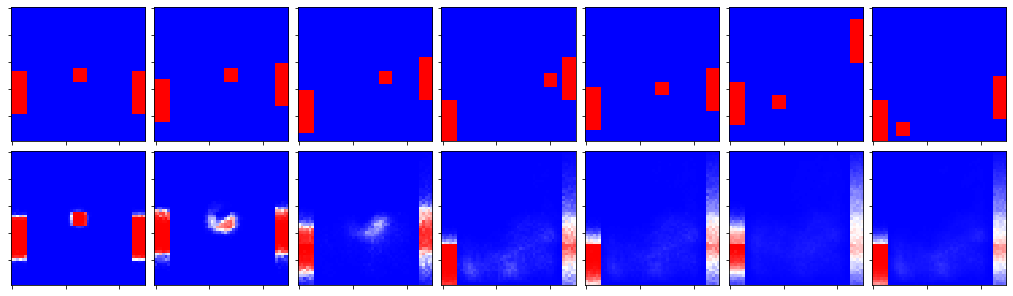

Epoch 4/250
100/100 [==============================] - 110s 1s/step - loss: 0.7470 - frames_loss: 0.1201 - lambda_1_loss: 0.6269 - frames_mean_squared_error: 0.0338 - frames_acc: 0.9536 - lambda_1_mean_squared_error: 115.1495 - lambda_1_acc: 0.9594 - val_loss: 0.9063 - val_frames_loss: 0.1117 - val_lambda_1_loss: 0.7946 - val_frames_mean_squared_error: 0.0312 - val_frames_acc: 0.9570 - val_lambda_1_mean_squared_error: 107.3932 - val_lambda_1_acc: 0.9485


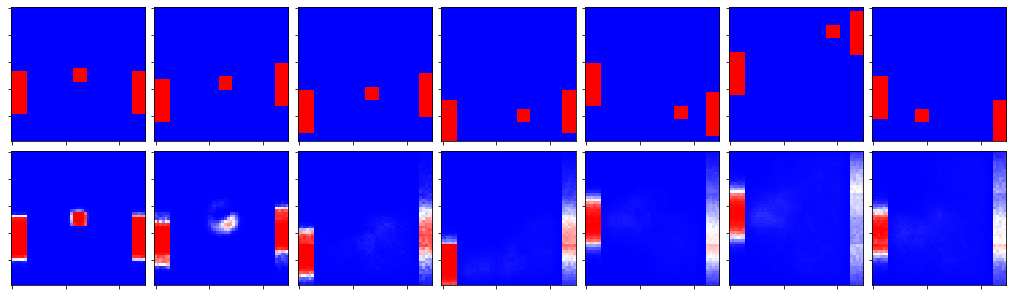

Epoch 5/250
100/100 [==============================] - 111s 1s/step - loss: 0.7893 - frames_loss: 0.1015 - lambda_1_loss: 0.6879 - frames_mean_squared_error: 0.0279 - frames_acc: 0.9622 - lambda_1_mean_squared_error: 112.1572 - lambda_1_acc: 0.9554 - val_loss: 1.1656 - val_frames_loss: 0.0867 - val_lambda_1_loss: 1.0789 - val_frames_mean_squared_error: 0.0232 - val_frames_acc: 0.9697 - val_lambda_1_mean_squared_error: 138.9127 - val_lambda_1_acc: 0.9301


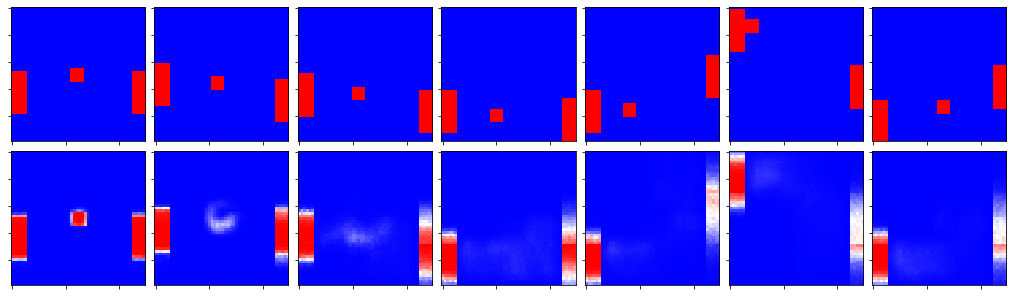

Epoch 6/250
100/100 [==============================] - 110s 1s/step - loss: 0.7444 - frames_loss: 0.0798 - lambda_1_loss: 0.6646 - frames_mean_squared_error: 0.0210 - frames_acc: 0.9739 - lambda_1_mean_squared_error: 167.9204 - lambda_1_acc: 0.9569 - val_loss: 0.9727 - val_frames_loss: 0.0670 - val_lambda_1_loss: 0.9057 - val_frames_mean_squared_error: 0.0170 - val_frames_acc: 0.9797 - val_lambda_1_mean_squared_error: 195.1270 - val_lambda_1_acc: 0.9413


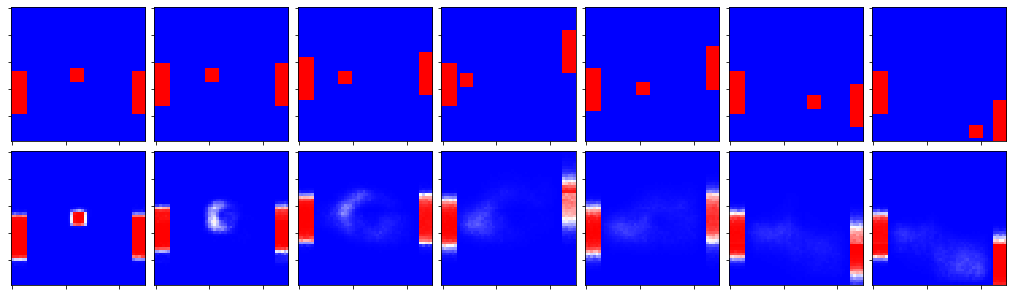

Epoch 7/250
100/100 [==============================] - 110s 1s/step - loss: 0.7747 - frames_loss: 0.0679 - lambda_1_loss: 0.7068 - frames_mean_squared_error: 0.0173 - frames_acc: 0.9792 - lambda_1_mean_squared_error: 171.2523 - lambda_1_acc: 0.9542 - val_loss: 0.8843 - val_frames_loss: 0.0595 - val_lambda_1_loss: 0.8247 - val_frames_mean_squared_error: 0.0150 - val_frames_acc: 0.9824 - val_lambda_1_mean_squared_error: 216.7188 - val_lambda_1_acc: 0.9465


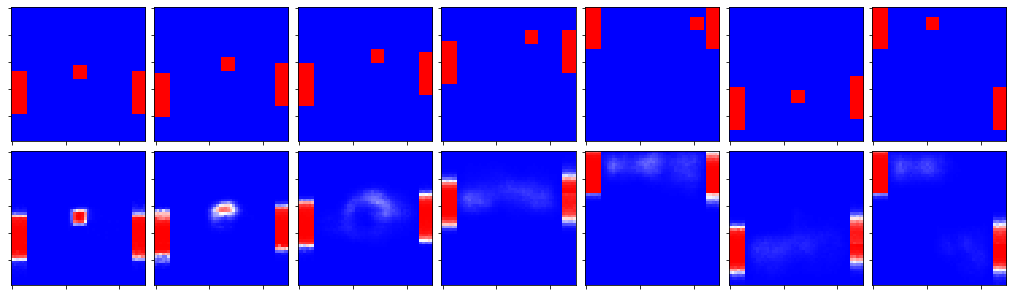

Epoch 8/250
100/100 [==============================] - 111s 1s/step - loss: 0.7643 - frames_loss: 0.0583 - lambda_1_loss: 0.7060 - frames_mean_squared_error: 0.0148 - frames_acc: 0.9824 - lambda_1_mean_squared_error: 222.2217 - lambda_1_acc: 0.9542 - val_loss: 1.1790 - val_frames_loss: 0.0549 - val_lambda_1_loss: 1.1241 - val_frames_mean_squared_error: 0.0139 - val_frames_acc: 0.9835 - val_lambda_1_mean_squared_error: 247.0654 - val_lambda_1_acc: 0.9271


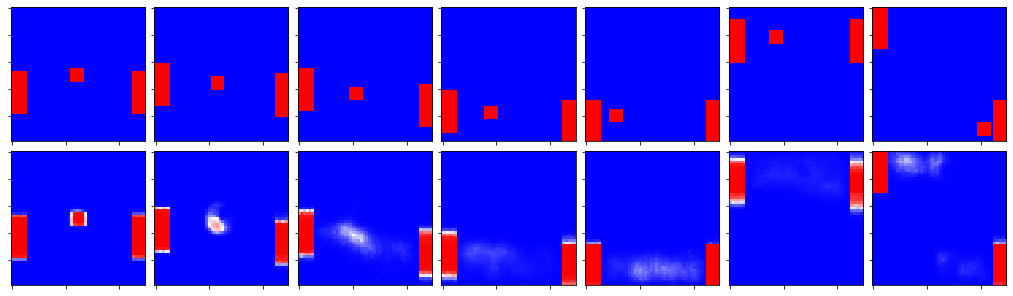

Epoch 9/250
100/100 [==============================] - 111s 1s/step - loss: 0.7549 - frames_loss: 0.0579 - lambda_1_loss: 0.6969 - frames_mean_squared_error: 0.0148 - frames_acc: 0.9823 - lambda_1_mean_squared_error: 195.1087 - lambda_1_acc: 0.9548 - val_loss: 0.5512 - val_frames_loss: 0.0541 - val_lambda_1_loss: 0.4971 - val_frames_mean_squared_error: 0.0139 - val_frames_acc: 0.9834 - val_lambda_1_mean_squared_error: 212.1691 - val_lambda_1_acc: 0.9678


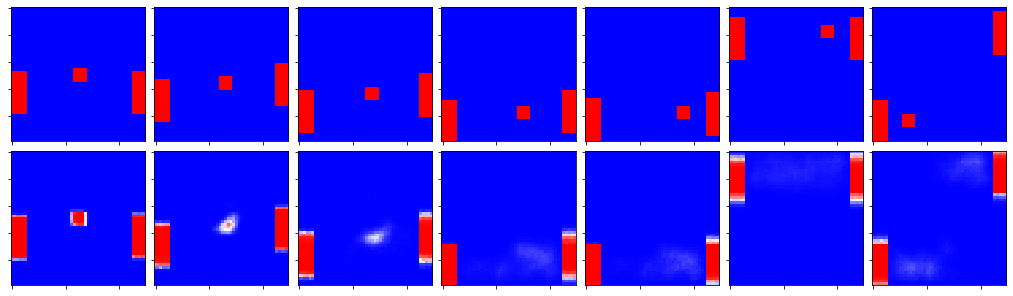

Epoch 10/250
100/100 [==============================] - 110s 1s/step - loss: 0.6814 - frames_loss: 0.0509 - lambda_1_loss: 0.6305 - frames_mean_squared_error: 0.0130 - frames_acc: 0.9847 - lambda_1_mean_squared_error: 251.7879 - lambda_1_acc: 0.9591 - val_loss: 0.7607 - val_frames_loss: 0.0584 - val_lambda_1_loss: 0.7023 - val_frames_mean_squared_error: 0.0148 - val_frames_acc: 0.9825 - val_lambda_1_mean_squared_error: 284.0048 - val_lambda_1_acc: 0.9545


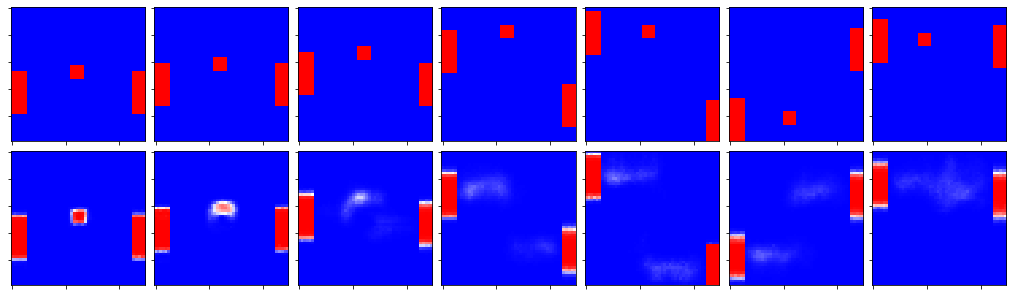

Epoch 11/250
100/100 [==============================] - 110s 1s/step - loss: 0.7397 - frames_loss: 0.0534 - lambda_1_loss: 0.6863 - frames_mean_squared_error: 0.0137 - frames_acc: 0.9837 - lambda_1_mean_squared_error: 214.2706 - lambda_1_acc: 0.9555 - val_loss: 0.8592 - val_frames_loss: 0.0590 - val_lambda_1_loss: 0.8002 - val_frames_mean_squared_error: 0.0153 - val_frames_acc: 0.9816 - val_lambda_1_mean_squared_error: 185.3347 - val_lambda_1_acc: 0.9481


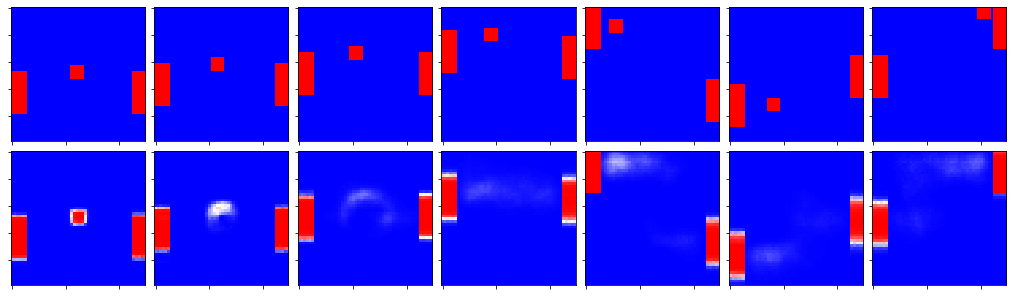

Epoch 12/250
100/100 [==============================] - 110s 1s/step - loss: 0.7513 - frames_loss: 0.0492 - lambda_1_loss: 0.7021 - frames_mean_squared_error: 0.0126 - frames_acc: 0.9851 - lambda_1_mean_squared_error: 238.1240 - lambda_1_acc: 0.9545 - val_loss: 1.0136 - val_frames_loss: 0.0458 - val_lambda_1_loss: 0.9678 - val_frames_mean_squared_error: 0.0117 - val_frames_acc: 0.9863 - val_lambda_1_mean_squared_error: 270.7249 - val_lambda_1_acc: 0.9373


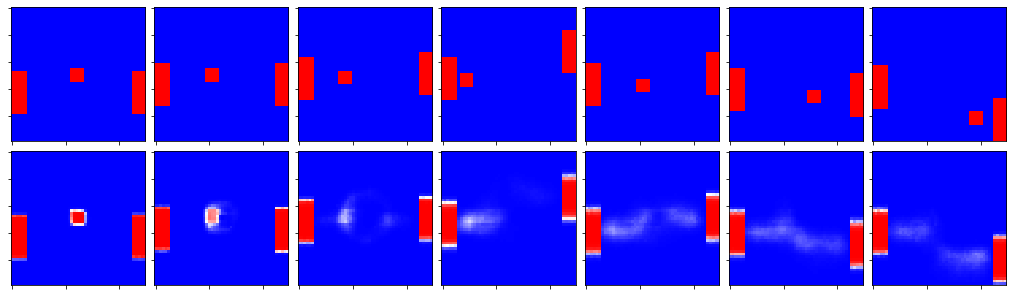

Epoch 13/250
100/100 [==============================] - 111s 1s/step - loss: 0.7648 - frames_loss: 0.0456 - lambda_1_loss: 0.7192 - frames_mean_squared_error: 0.0117 - frames_acc: 0.9862 - lambda_1_mean_squared_error: 302.9352 - lambda_1_acc: 0.9534 - val_loss: 0.3719 - val_frames_loss: 0.0462 - val_lambda_1_loss: 0.3257 - val_frames_mean_squared_error: 0.0121 - val_frames_acc: 0.9855 - val_lambda_1_mean_squared_error: 313.7532 - val_lambda_1_acc: 0.9789


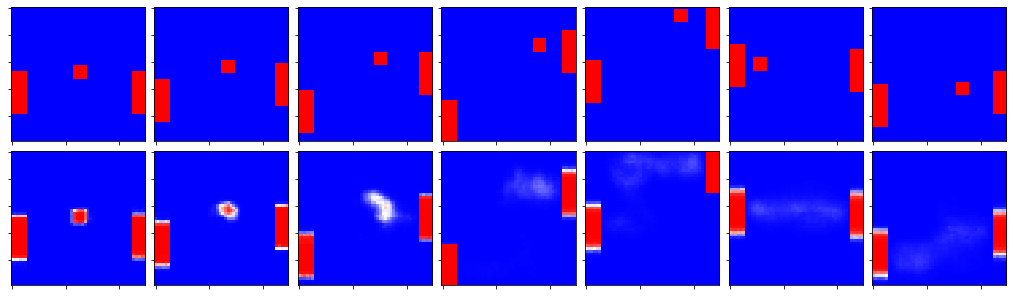

Epoch 14/250
100/100 [==============================] - 111s 1s/step - loss: 0.7164 - frames_loss: 0.0462 - lambda_1_loss: 0.6702 - frames_mean_squared_error: 0.0119 - frames_acc: 0.9859 - lambda_1_mean_squared_error: 280.4676 - lambda_1_acc: 0.9566 - val_loss: 1.1159 - val_frames_loss: 0.0501 - val_lambda_1_loss: 1.0657 - val_frames_mean_squared_error: 0.0130 - val_frames_acc: 0.9847 - val_lambda_1_mean_squared_error: 266.1121 - val_lambda_1_acc: 0.9309


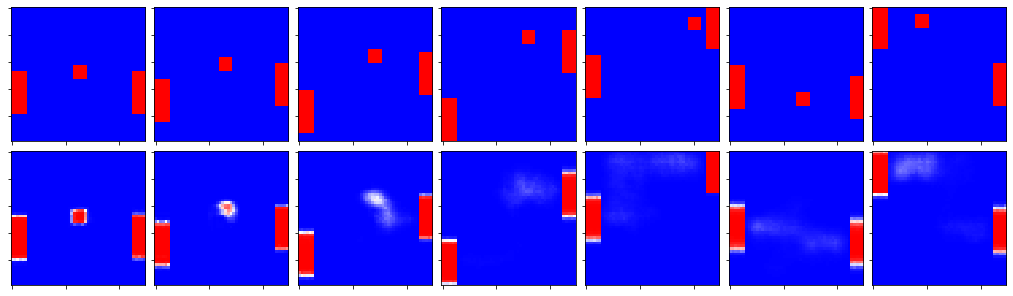

Epoch 15/250
100/100 [==============================] - 111s 1s/step - loss: 0.7566 - frames_loss: 0.0460 - lambda_1_loss: 0.7106 - frames_mean_squared_error: 0.0119 - frames_acc: 0.9860 - lambda_1_mean_squared_error: 255.0532 - lambda_1_acc: 0.9539 - val_loss: 0.6331 - val_frames_loss: 0.0551 - val_lambda_1_loss: 0.5781 - val_frames_mean_squared_error: 0.0141 - val_frames_acc: 0.9831 - val_lambda_1_mean_squared_error: 283.6802 - val_lambda_1_acc: 0.9625


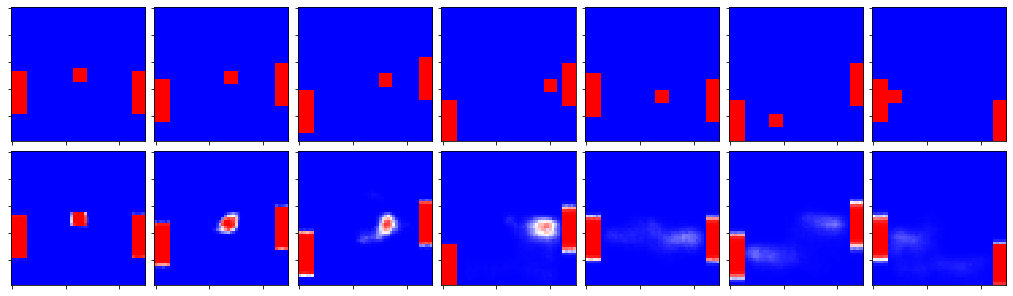

Epoch 16/250
100/100 [==============================] - 111s 1s/step - loss: 0.7169 - frames_loss: 0.0455 - lambda_1_loss: 0.6713 - frames_mean_squared_error: 0.0118 - frames_acc: 0.9860 - lambda_1_mean_squared_error: 234.1710 - lambda_1_acc: 0.9565 - val_loss: 0.7251 - val_frames_loss: 0.0416 - val_lambda_1_loss: 0.6835 - val_frames_mean_squared_error: 0.0106 - val_frames_acc: 0.9877 - val_lambda_1_mean_squared_error: 301.8355 - val_lambda_1_acc: 0.9557


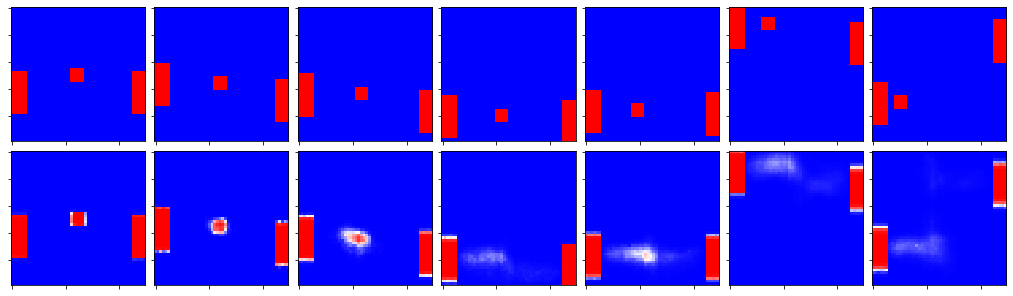

Epoch 17/250
100/100 [==============================] - 111s 1s/step - loss: 0.7386 - frames_loss: 0.0449 - lambda_1_loss: 0.6937 - frames_mean_squared_error: 0.0118 - frames_acc: 0.9860 - lambda_1_mean_squared_error: 318.8645 - lambda_1_acc: 0.9550 - val_loss: 1.0090 - val_frames_loss: 0.0469 - val_lambda_1_loss: 0.9622 - val_frames_mean_squared_error: 0.0123 - val_frames_acc: 0.9852 - val_lambda_1_mean_squared_error: 238.9432 - val_lambda_1_acc: 0.9376


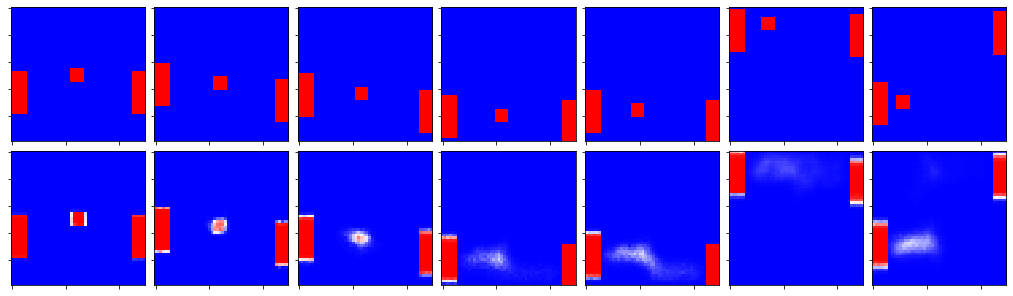

Epoch 18/250
100/100 [==============================] - 111s 1s/step - loss: 0.7892 - frames_loss: 0.0437 - lambda_1_loss: 0.7455 - frames_mean_squared_error: 0.0114 - frames_acc: 0.9864 - lambda_1_mean_squared_error: 282.5373 - lambda_1_acc: 0.9517 - val_loss: 0.7549 - val_frames_loss: 0.0413 - val_lambda_1_loss: 0.7136 - val_frames_mean_squared_error: 0.0107 - val_frames_acc: 0.9875 - val_lambda_1_mean_squared_error: 281.7820 - val_lambda_1_acc: 0.9537


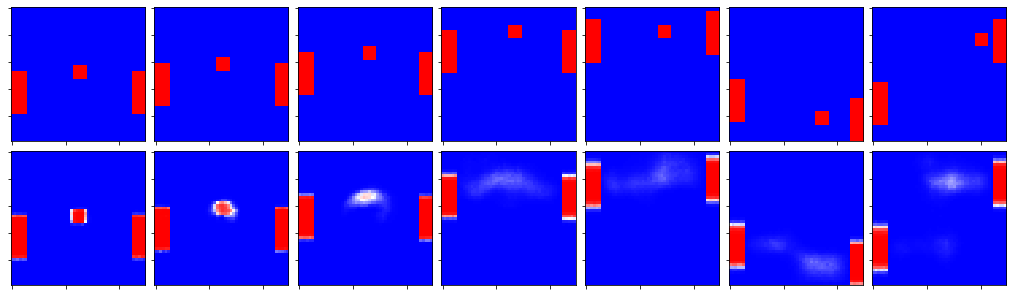

Epoch 19/250
100/100 [==============================] - 110s 1s/step - loss: 0.7399 - frames_loss: 0.0430 - lambda_1_loss: 0.6969 - frames_mean_squared_error: 0.0113 - frames_acc: 0.9866 - lambda_1_mean_squared_error: 298.2486 - lambda_1_acc: 0.9548 - val_loss: 1.4240 - val_frames_loss: 0.0400 - val_lambda_1_loss: 1.3840 - val_frames_mean_squared_error: 0.0104 - val_frames_acc: 0.9877 - val_lambda_1_mean_squared_error: 285.4868 - val_lambda_1_acc: 0.9103


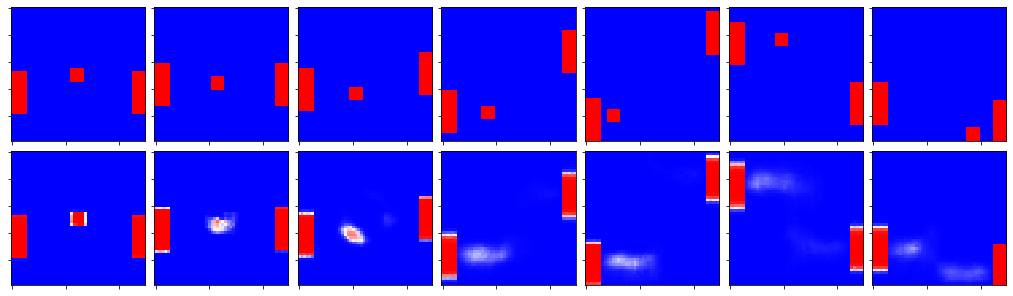

Epoch 20/250
100/100 [==============================] - 111s 1s/step - loss: 0.7517 - frames_loss: 0.0435 - lambda_1_loss: 0.7082 - frames_mean_squared_error: 0.0114 - frames_acc: 0.9865 - lambda_1_mean_squared_error: 287.5217 - lambda_1_acc: 0.9541 - val_loss: 0.6389 - val_frames_loss: 0.0402 - val_lambda_1_loss: 0.5988 - val_frames_mean_squared_error: 0.0104 - val_frames_acc: 0.9879 - val_lambda_1_mean_squared_error: 246.8453 - val_lambda_1_acc: 0.9612


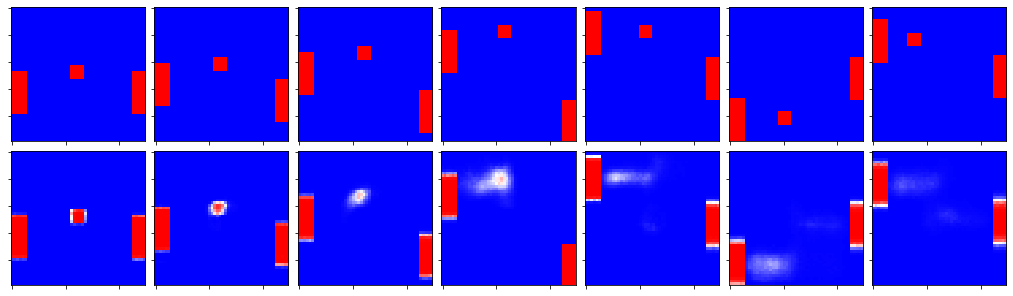

Epoch 21/250
100/100 [==============================] - 110s 1s/step - loss: 0.6861 - frames_loss: 0.0409 - lambda_1_loss: 0.6452 - frames_mean_squared_error: 0.0108 - frames_acc: 0.9872 - lambda_1_mean_squared_error: 314.5707 - lambda_1_acc: 0.9582 - val_loss: 0.5827 - val_frames_loss: 0.0573 - val_lambda_1_loss: 0.5253 - val_frames_mean_squared_error: 0.0151 - val_frames_acc: 0.9817 - val_lambda_1_mean_squared_error: 273.3369 - val_lambda_1_acc: 0.9659


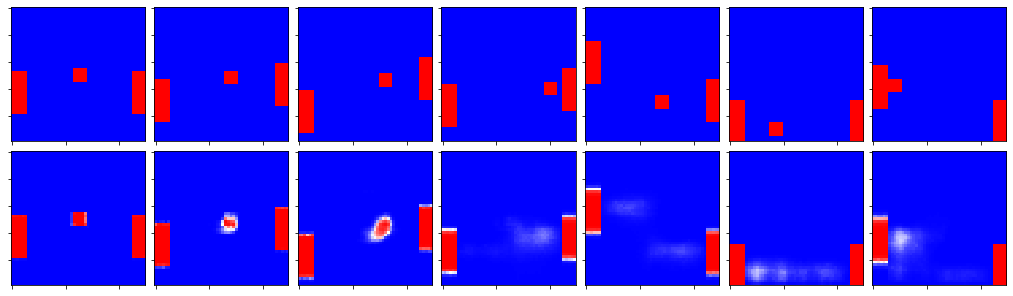

Epoch 22/250
100/100 [==============================] - 111s 1s/step - loss: 0.6644 - frames_loss: 0.0422 - lambda_1_loss: 0.6222 - frames_mean_squared_error: 0.0112 - frames_acc: 0.9866 - lambda_1_mean_squared_error: 375.7509 - lambda_1_acc: 0.9597 - val_loss: 0.6703 - val_frames_loss: 0.0395 - val_lambda_1_loss: 0.6308 - val_frames_mean_squared_error: 0.0104 - val_frames_acc: 0.9876 - val_lambda_1_mean_squared_error: 488.9487 - val_lambda_1_acc: 0.9591


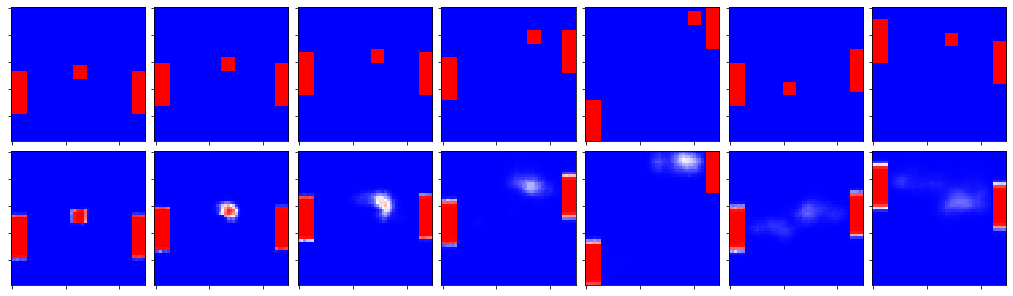

Epoch 23/250
100/100 [==============================] - 110s 1s/step - loss: 0.6997 - frames_loss: 0.0415 - lambda_1_loss: 0.6582 - frames_mean_squared_error: 0.0111 - frames_acc: 0.9866 - lambda_1_mean_squared_error: 421.5501 - lambda_1_acc: 0.9573 - val_loss: 0.4114 - val_frames_loss: 0.0405 - val_lambda_1_loss: 0.3709 - val_frames_mean_squared_error: 0.0109 - val_frames_acc: 0.9869 - val_lambda_1_mean_squared_error: 381.8670 - val_lambda_1_acc: 0.9760


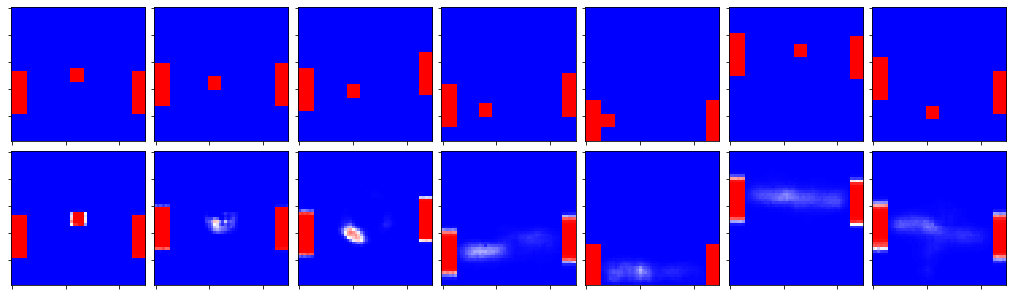

Epoch 24/250
100/100 [==============================] - 111s 1s/step - loss: 0.7228 - frames_loss: 0.0393 - lambda_1_loss: 0.6834 - frames_mean_squared_error: 0.0105 - frames_acc: 0.9875 - lambda_1_mean_squared_error: 429.0201 - lambda_1_acc: 0.9557 - val_loss: 0.4829 - val_frames_loss: 0.0385 - val_lambda_1_loss: 0.4444 - val_frames_mean_squared_error: 0.0105 - val_frames_acc: 0.9872 - val_lambda_1_mean_squared_error: 430.0274 - val_lambda_1_acc: 0.9712


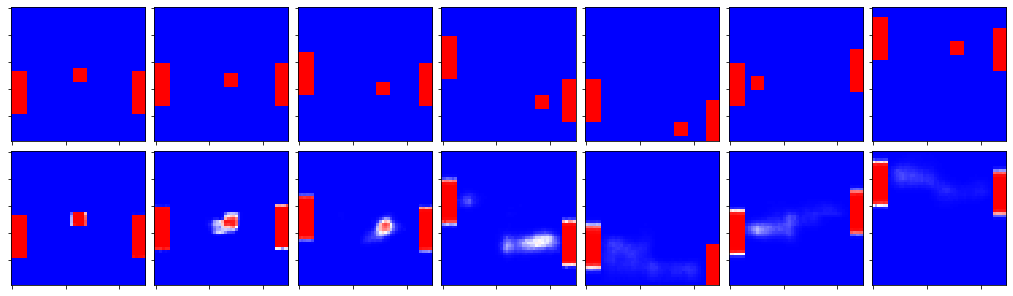

Epoch 25/250
100/100 [==============================] - 111s 1s/step - loss: 0.7578 - frames_loss: 0.0427 - lambda_1_loss: 0.7151 - frames_mean_squared_error: 0.0113 - frames_acc: 0.9865 - lambda_1_mean_squared_error: 407.9045 - lambda_1_acc: 0.9536 - val_loss: 0.7633 - val_frames_loss: 0.0459 - val_lambda_1_loss: 0.7174 - val_frames_mean_squared_error: 0.0124 - val_frames_acc: 0.9847 - val_lambda_1_mean_squared_error: 210.6796 - val_lambda_1_acc: 0.9535


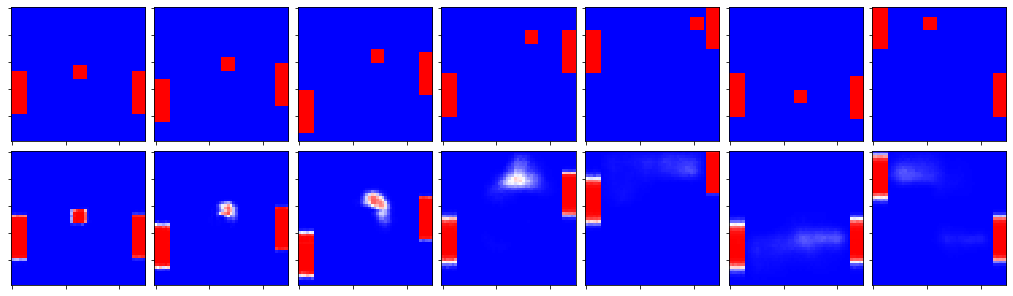

Epoch 26/250
100/100 [==============================] - 111s 1s/step - loss: 0.7175 - frames_loss: 0.0402 - lambda_1_loss: 0.6773 - frames_mean_squared_error: 0.0107 - frames_acc: 0.9871 - lambda_1_mean_squared_error: 296.8786 - lambda_1_acc: 0.9561 - val_loss: 0.9469 - val_frames_loss: 0.0375 - val_lambda_1_loss: 0.9095 - val_frames_mean_squared_error: 0.0100 - val_frames_acc: 0.9879 - val_lambda_1_mean_squared_error: 393.4334 - val_lambda_1_acc: 0.9410


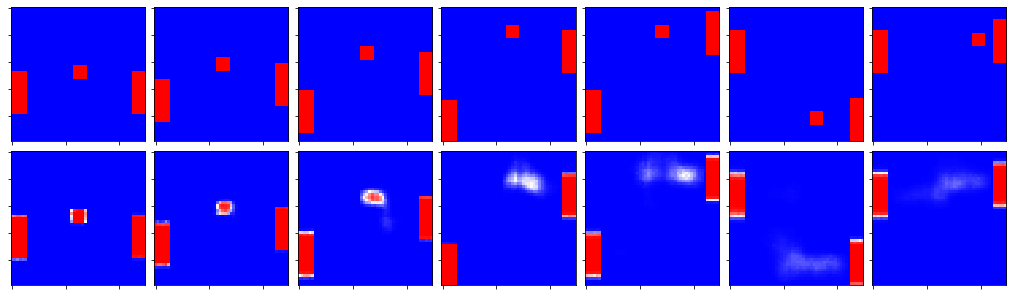

Epoch 27/250
100/100 [==============================] - 110s 1s/step - loss: 0.6752 - frames_loss: 0.0378 - lambda_1_loss: 0.6374 - frames_mean_squared_error: 0.0102 - frames_acc: 0.9878 - lambda_1_mean_squared_error: 403.3951 - lambda_1_acc: 0.9587 - val_loss: 0.8437 - val_frames_loss: 0.0359 - val_lambda_1_loss: 0.8078 - val_frames_mean_squared_error: 0.0095 - val_frames_acc: 0.9887 - val_lambda_1_mean_squared_error: 424.0875 - val_lambda_1_acc: 0.9476


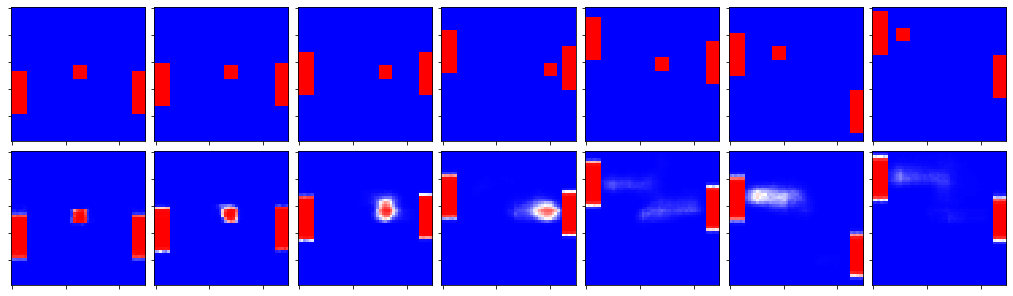

Epoch 28/250
100/100 [==============================] - 110s 1s/step - loss: 0.7668 - frames_loss: 0.0372 - lambda_1_loss: 0.7296 - frames_mean_squared_error: 0.0101 - frames_acc: 0.9879 - lambda_1_mean_squared_error: 434.1880 - lambda_1_acc: 0.9527 - val_loss: 0.6263 - val_frames_loss: 0.0370 - val_lambda_1_loss: 0.5894 - val_frames_mean_squared_error: 0.0101 - val_frames_acc: 0.9877 - val_lambda_1_mean_squared_error: 396.3300 - val_lambda_1_acc: 0.9618


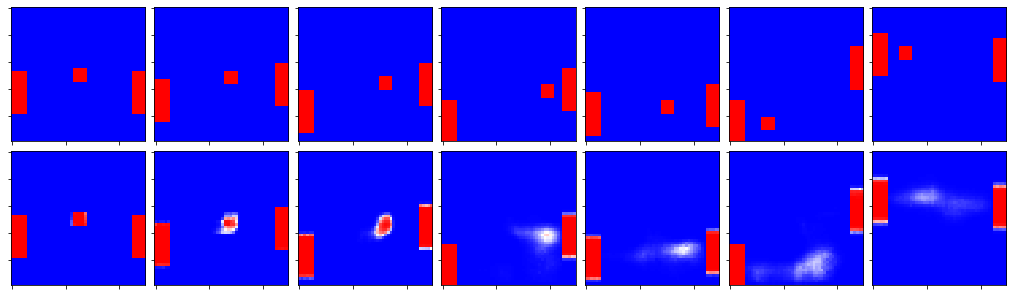

Epoch 29/250
100/100 [==============================] - 110s 1s/step - loss: 0.8104 - frames_loss: 0.0390 - lambda_1_loss: 0.7714 - frames_mean_squared_error: 0.0106 - frames_acc: 0.9871 - lambda_1_mean_squared_error: 361.7188 - lambda_1_acc: 0.9500 - val_loss: 0.7503 - val_frames_loss: 0.0404 - val_lambda_1_loss: 0.7099 - val_frames_mean_squared_error: 0.0109 - val_frames_acc: 0.9868 - val_lambda_1_mean_squared_error: 360.0610 - val_lambda_1_acc: 0.9540


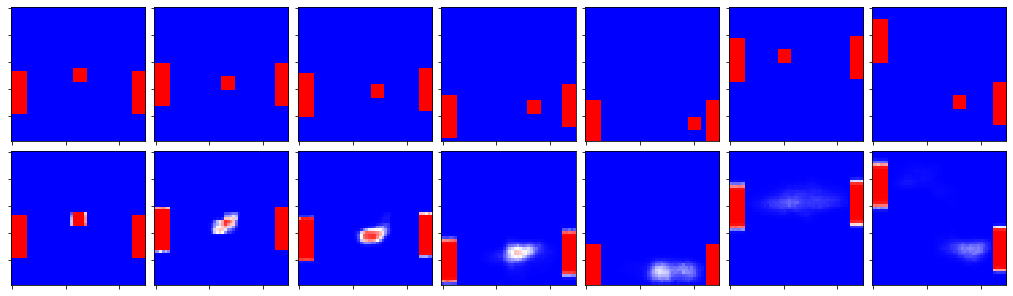

Epoch 30/250
100/100 [==============================] - 111s 1s/step - loss: 0.7680 - frames_loss: 0.0372 - lambda_1_loss: 0.7307 - frames_mean_squared_error: 0.0101 - frames_acc: 0.9878 - lambda_1_mean_squared_error: 370.4631 - lambda_1_acc: 0.9526 - val_loss: 0.2866 - val_frames_loss: 0.0343 - val_lambda_1_loss: 0.2523 - val_frames_mean_squared_error: 0.0094 - val_frames_acc: 0.9887 - val_lambda_1_mean_squared_error: 382.4079 - val_lambda_1_acc: 0.9836


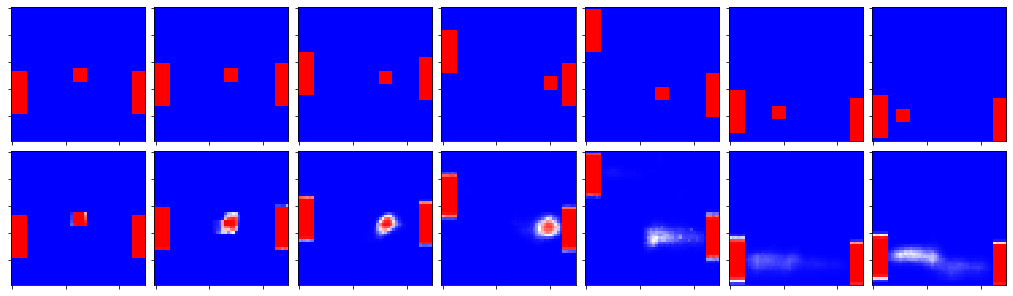

Epoch 31/250
100/100 [==============================] - 110s 1s/step - loss: 0.7094 - frames_loss: 0.0406 - lambda_1_loss: 0.6688 - frames_mean_squared_error: 0.0110 - frames_acc: 0.9866 - lambda_1_mean_squared_error: 323.6342 - lambda_1_acc: 0.9566 - val_loss: 0.4762 - val_frames_loss: 0.0375 - val_lambda_1_loss: 0.4387 - val_frames_mean_squared_error: 0.0103 - val_frames_acc: 0.9873 - val_lambda_1_mean_squared_error: 267.9896 - val_lambda_1_acc: 0.9716


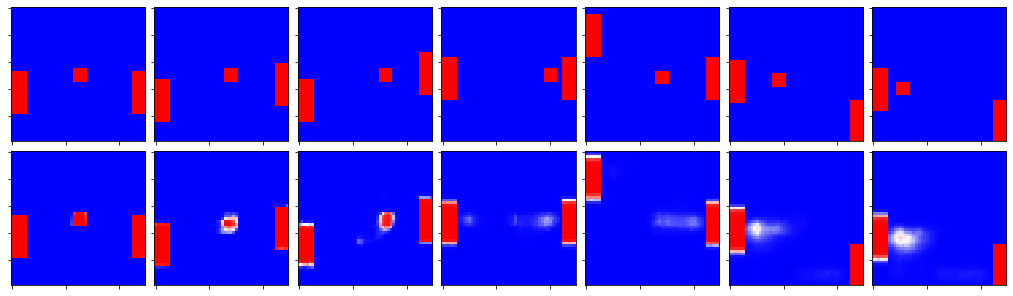

Epoch 32/250
100/100 [==============================] - 110s 1s/step - loss: 0.8283 - frames_loss: 0.0354 - lambda_1_loss: 0.7929 - frames_mean_squared_error: 0.0096 - frames_acc: 0.9884 - lambda_1_mean_squared_error: 362.9914 - lambda_1_acc: 0.9486 - val_loss: 0.5759 - val_frames_loss: 0.0336 - val_lambda_1_loss: 0.5423 - val_frames_mean_squared_error: 0.0093 - val_frames_acc: 0.9887 - val_lambda_1_mean_squared_error: 407.2330 - val_lambda_1_acc: 0.9648


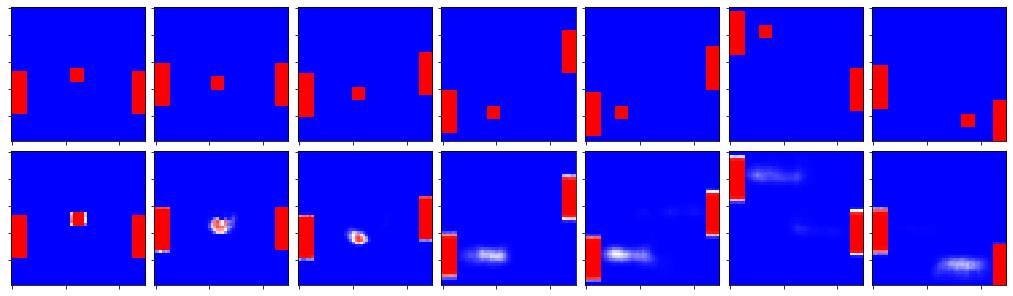

Epoch 33/250
100/100 [==============================] - 111s 1s/step - loss: 0.7594 - frames_loss: 0.0358 - lambda_1_loss: 0.7236 - frames_mean_squared_error: 0.0098 - frames_acc: 0.9880 - lambda_1_mean_squared_error: 382.1825 - lambda_1_acc: 0.9531 - val_loss: 1.1444 - val_frames_loss: 0.0373 - val_lambda_1_loss: 1.1072 - val_frames_mean_squared_error: 0.0101 - val_frames_acc: 0.9877 - val_lambda_1_mean_squared_error: 388.7892 - val_lambda_1_acc: 0.9282


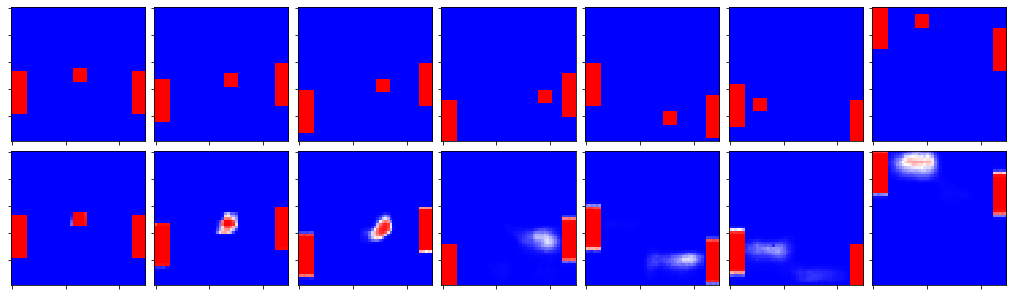

Epoch 34/250
100/100 [==============================] - 111s 1s/step - loss: 0.7054 - frames_loss: 0.0371 - lambda_1_loss: 0.6683 - frames_mean_squared_error: 0.0102 - frames_acc: 0.9875 - lambda_1_mean_squared_error: 356.5142 - lambda_1_acc: 0.9567 - val_loss: 0.7297 - val_frames_loss: 0.0387 - val_lambda_1_loss: 0.6910 - val_frames_mean_squared_error: 0.0106 - val_frames_acc: 0.9871 - val_lambda_1_mean_squared_error: 316.0786 - val_lambda_1_acc: 0.9552


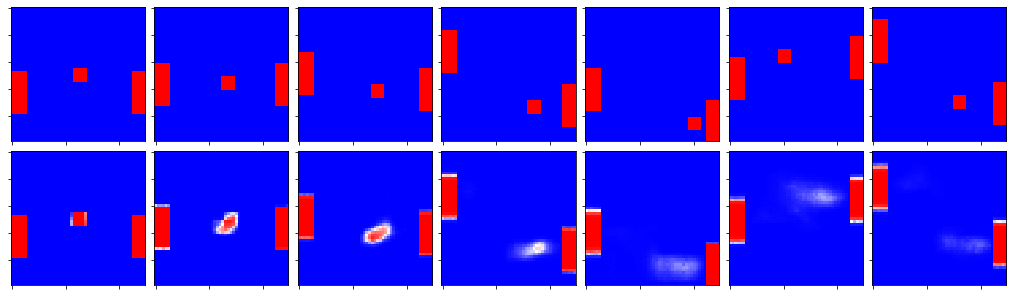

Epoch 35/250
100/100 [==============================] - 110s 1s/step - loss: 0.7724 - frames_loss: 0.0353 - lambda_1_loss: 0.7371 - frames_mean_squared_error: 0.0097 - frames_acc: 0.9881 - lambda_1_mean_squared_error: 339.6566 - lambda_1_acc: 0.9522 - val_loss: 0.3423 - val_frames_loss: 0.0335 - val_lambda_1_loss: 0.3088 - val_frames_mean_squared_error: 0.0093 - val_frames_acc: 0.9886 - val_lambda_1_mean_squared_error: 394.7755 - val_lambda_1_acc: 0.9800


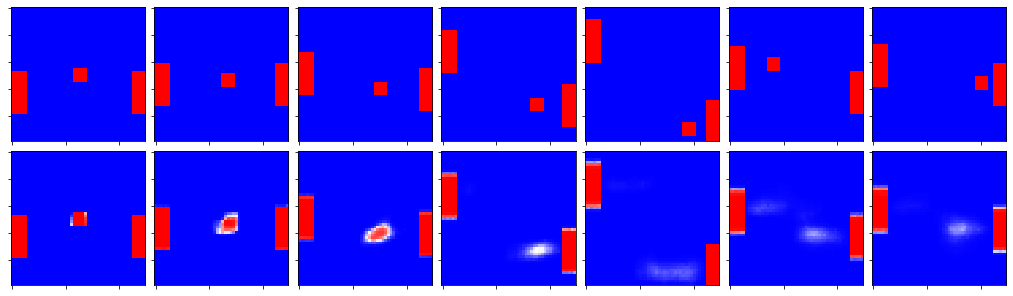

Epoch 36/250
100/100 [==============================] - 111s 1s/step - loss: 0.6935 - frames_loss: 0.0386 - lambda_1_loss: 0.6549 - frames_mean_squared_error: 0.0105 - frames_acc: 0.9871 - lambda_1_mean_squared_error: 354.6201 - lambda_1_acc: 0.9575 - val_loss: 0.3687 - val_frames_loss: 0.0430 - val_lambda_1_loss: 0.3257 - val_frames_mean_squared_error: 0.0118 - val_frames_acc: 0.9854 - val_lambda_1_mean_squared_error: 203.4206 - val_lambda_1_acc: 0.9789


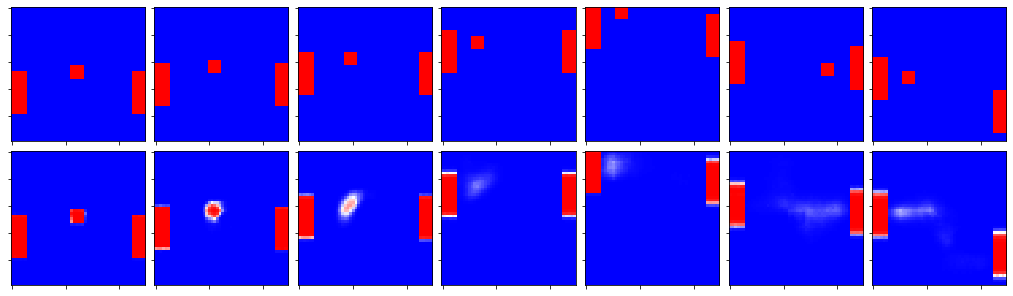

Epoch 37/250
100/100 [==============================] - 111s 1s/step - loss: 0.6902 - frames_loss: 0.0358 - lambda_1_loss: 0.6545 - frames_mean_squared_error: 0.0098 - frames_acc: 0.9880 - lambda_1_mean_squared_error: 273.6609 - lambda_1_acc: 0.9576 - val_loss: 0.6225 - val_frames_loss: 0.0331 - val_lambda_1_loss: 0.5894 - val_frames_mean_squared_error: 0.0091 - val_frames_acc: 0.9890 - val_lambda_1_mean_squared_error: 343.8383 - val_lambda_1_acc: 0.9618


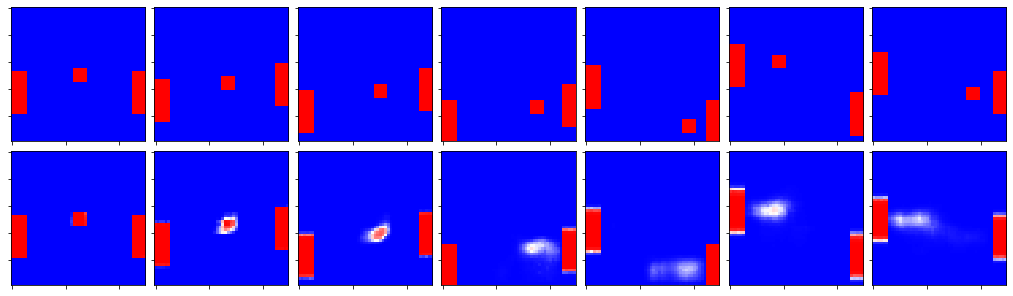

Epoch 38/250
100/100 [==============================] - 111s 1s/step - loss: 0.7030 - frames_loss: 0.0341 - lambda_1_loss: 0.6689 - frames_mean_squared_error: 0.0095 - frames_acc: 0.9884 - lambda_1_mean_squared_error: 350.3434 - lambda_1_acc: 0.9566 - val_loss: 0.6831 - val_frames_loss: 0.0335 - val_lambda_1_loss: 0.6496 - val_frames_mean_squared_error: 0.0092 - val_frames_acc: 0.9889 - val_lambda_1_mean_squared_error: 374.6745 - val_lambda_1_acc: 0.9579


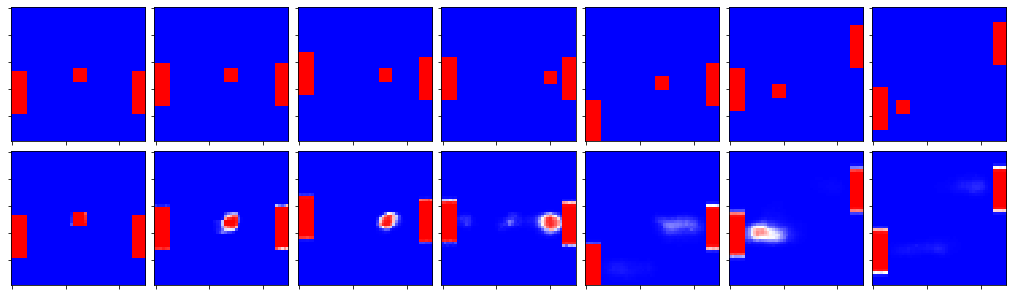

Epoch 39/250
100/100 [==============================] - 110s 1s/step - loss: 0.6929 - frames_loss: 0.0334 - lambda_1_loss: 0.6596 - frames_mean_squared_error: 0.0093 - frames_acc: 0.9886 - lambda_1_mean_squared_error: 372.6906 - lambda_1_acc: 0.9572 - val_loss: 0.5930 - val_frames_loss: 0.0338 - val_lambda_1_loss: 0.5592 - val_frames_mean_squared_error: 0.0095 - val_frames_acc: 0.9882 - val_lambda_1_mean_squared_error: 384.6619 - val_lambda_1_acc: 0.9637


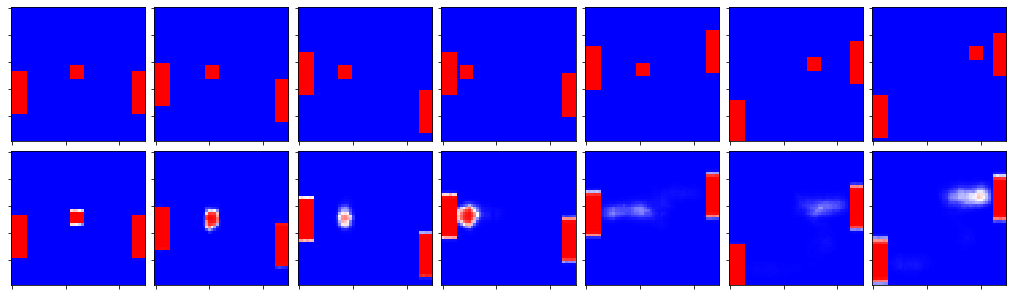

Epoch 40/250
100/100 [==============================] - 110s 1s/step - loss: 0.6995 - frames_loss: 0.0346 - lambda_1_loss: 0.6649 - frames_mean_squared_error: 0.0097 - frames_acc: 0.9881 - lambda_1_mean_squared_error: 345.2235 - lambda_1_acc: 0.9569 - val_loss: 1.0902 - val_frames_loss: 0.0319 - val_lambda_1_loss: 1.0582 - val_frames_mean_squared_error: 0.0089 - val_frames_acc: 0.9889 - val_lambda_1_mean_squared_error: 357.2703 - val_lambda_1_acc: 0.9314


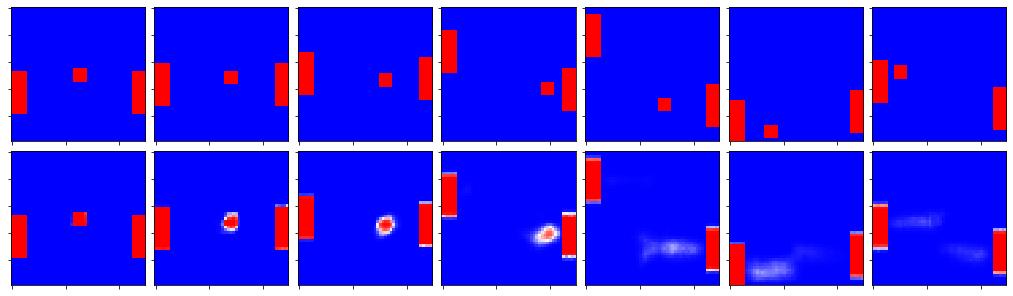

Epoch 41/250
100/100 [==============================] - 111s 1s/step - loss: 0.7320 - frames_loss: 0.0341 - lambda_1_loss: 0.6979 - frames_mean_squared_error: 0.0095 - frames_acc: 0.9882 - lambda_1_mean_squared_error: 339.6935 - lambda_1_acc: 0.9548 - val_loss: 0.7354 - val_frames_loss: 0.0331 - val_lambda_1_loss: 0.7023 - val_frames_mean_squared_error: 0.0093 - val_frames_acc: 0.9884 - val_lambda_1_mean_squared_error: 338.8075 - val_lambda_1_acc: 0.9545


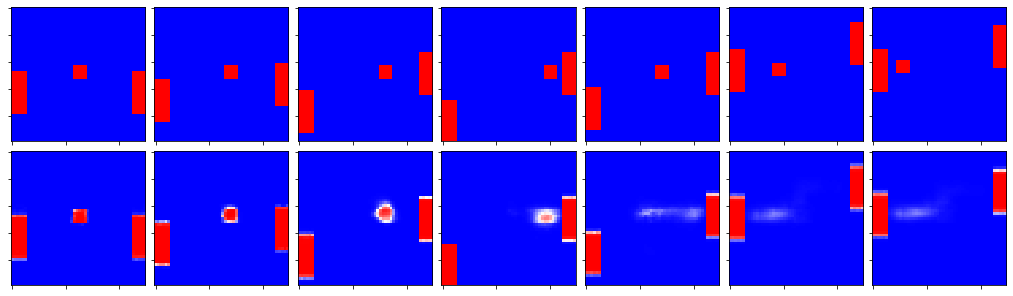

Epoch 42/250
100/100 [==============================] - 111s 1s/step - loss: 0.7648 - frames_loss: 0.0351 - lambda_1_loss: 0.7297 - frames_mean_squared_error: 0.0099 - frames_acc: 0.9877 - lambda_1_mean_squared_error: 315.5459 - lambda_1_acc: 0.9527 - val_loss: 0.5027 - val_frames_loss: 0.0338 - val_lambda_1_loss: 0.4688 - val_frames_mean_squared_error: 0.0094 - val_frames_acc: 0.9884 - val_lambda_1_mean_squared_error: 323.3925 - val_lambda_1_acc: 0.9696


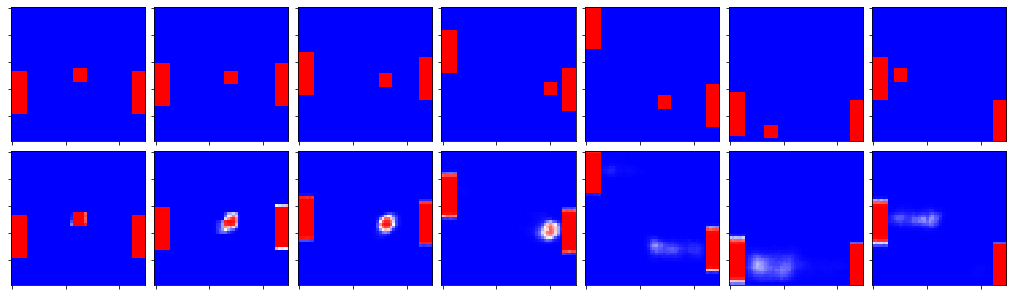

Epoch 43/250
100/100 [==============================] - 111s 1s/step - loss: 0.7101 - frames_loss: 0.0378 - lambda_1_loss: 0.6723 - frames_mean_squared_error: 0.0105 - frames_acc: 0.9869 - lambda_1_mean_squared_error: 251.5357 - lambda_1_acc: 0.9564 - val_loss: 0.2399 - val_frames_loss: 0.0347 - val_lambda_1_loss: 0.2052 - val_frames_mean_squared_error: 0.0098 - val_frames_acc: 0.9877 - val_lambda_1_mean_squared_error: 268.8087 - val_lambda_1_acc: 0.9867


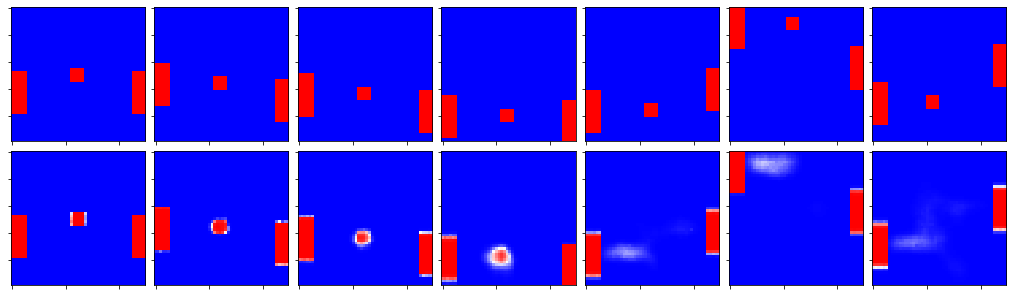

Epoch 44/250
100/100 [==============================] - 111s 1s/step - loss: 0.6994 - frames_loss: 0.0339 - lambda_1_loss: 0.6655 - frames_mean_squared_error: 0.0095 - frames_acc: 0.9881 - lambda_1_mean_squared_error: 279.3365 - lambda_1_acc: 0.9569 - val_loss: 0.5435 - val_frames_loss: 0.0313 - val_lambda_1_loss: 0.5122 - val_frames_mean_squared_error: 0.0088 - val_frames_acc: 0.9891 - val_lambda_1_mean_squared_error: 312.4535 - val_lambda_1_acc: 0.9668


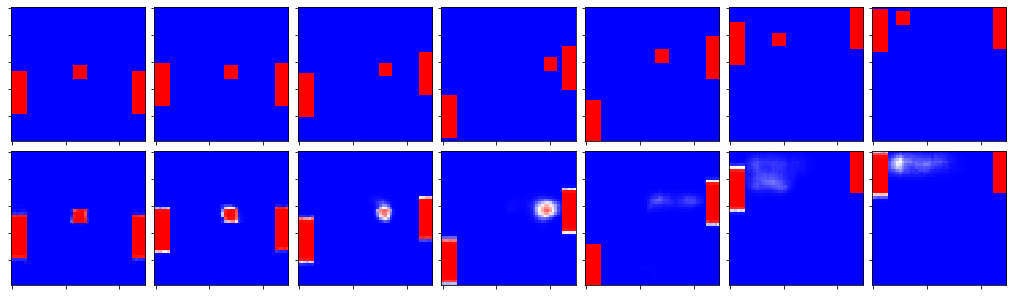

Epoch 45/250
100/100 [==============================] - 110s 1s/step - loss: 0.6957 - frames_loss: 0.0337 - lambda_1_loss: 0.6620 - frames_mean_squared_error: 0.0095 - frames_acc: 0.9882 - lambda_1_mean_squared_error: 292.0395 - lambda_1_acc: 0.9571 - val_loss: 1.0301 - val_frames_loss: 0.0321 - val_lambda_1_loss: 0.9980 - val_frames_mean_squared_error: 0.0090 - val_frames_acc: 0.9889 - val_lambda_1_mean_squared_error: 290.1851 - val_lambda_1_acc: 0.9353


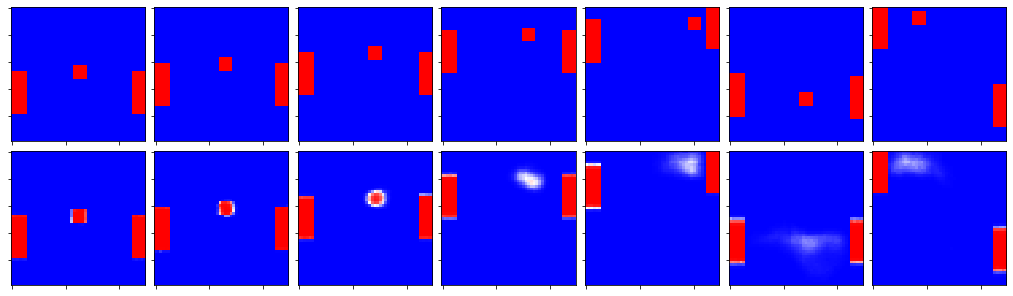

Epoch 46/250
100/100 [==============================] - 110s 1s/step - loss: 0.7458 - frames_loss: 0.0314 - lambda_1_loss: 0.7144 - frames_mean_squared_error: 0.0089 - frames_acc: 0.9889 - lambda_1_mean_squared_error: 325.4475 - lambda_1_acc: 0.9537 - val_loss: 0.4184 - val_frames_loss: 0.0324 - val_lambda_1_loss: 0.3860 - val_frames_mean_squared_error: 0.0093 - val_frames_acc: 0.9882 - val_lambda_1_mean_squared_error: 329.5047 - val_lambda_1_acc: 0.9750


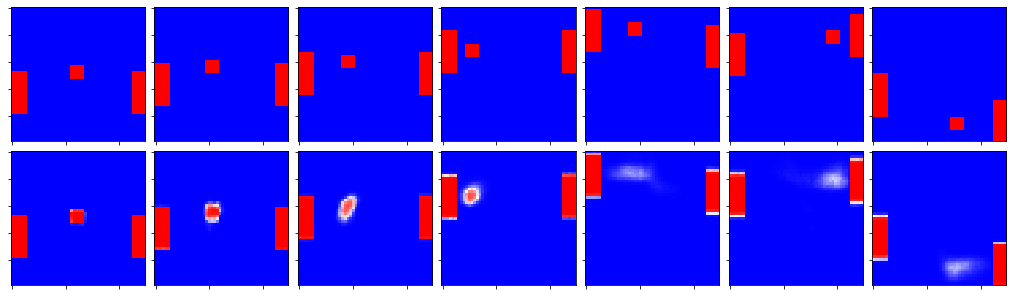

Epoch 47/250
100/100 [==============================] - 111s 1s/step - loss: 0.7038 - frames_loss: 0.0318 - lambda_1_loss: 0.6720 - frames_mean_squared_error: 0.0090 - frames_acc: 0.9887 - lambda_1_mean_squared_error: 335.1855 - lambda_1_acc: 0.9564 - val_loss: 0.7213 - val_frames_loss: 0.0340 - val_lambda_1_loss: 0.6873 - val_frames_mean_squared_error: 0.0097 - val_frames_acc: 0.9877 - val_lambda_1_mean_squared_error: 303.3180 - val_lambda_1_acc: 0.9554


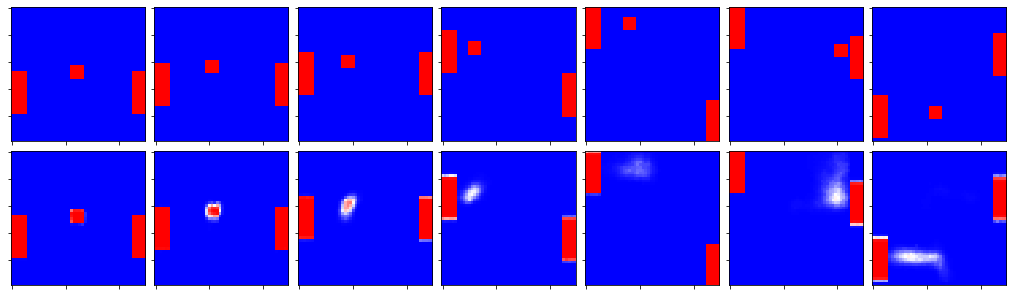

Epoch 48/250
100/100 [==============================] - 110s 1s/step - loss: 0.7433 - frames_loss: 0.0313 - lambda_1_loss: 0.7119 - frames_mean_squared_error: 0.0089 - frames_acc: 0.9889 - lambda_1_mean_squared_error: 313.0290 - lambda_1_acc: 0.9538 - val_loss: 0.7941 - val_frames_loss: 0.0296 - val_lambda_1_loss: 0.7645 - val_frames_mean_squared_error: 0.0084 - val_frames_acc: 0.9894 - val_lambda_1_mean_squared_error: 344.3193 - val_lambda_1_acc: 0.9504


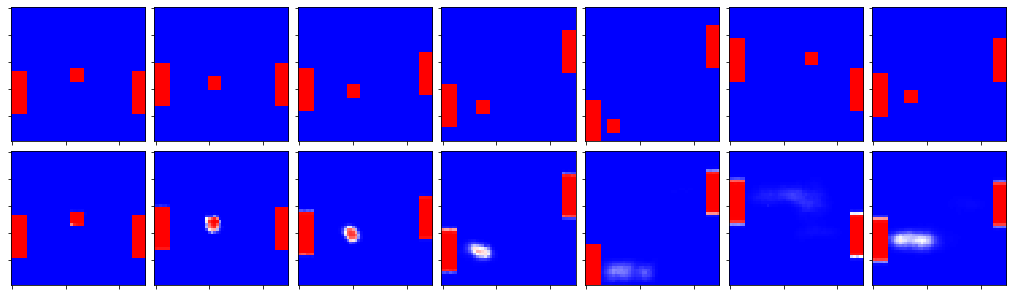

Epoch 49/250
100/100 [==============================] - 111s 1s/step - loss: 0.7183 - frames_loss: 0.0309 - lambda_1_loss: 0.6874 - frames_mean_squared_error: 0.0088 - frames_acc: 0.9890 - lambda_1_mean_squared_error: 336.1150 - lambda_1_acc: 0.9554 - val_loss: 0.7591 - val_frames_loss: 0.0304 - val_lambda_1_loss: 0.7287 - val_frames_mean_squared_error: 0.0087 - val_frames_acc: 0.9892 - val_lambda_1_mean_squared_error: 316.9956 - val_lambda_1_acc: 0.9528


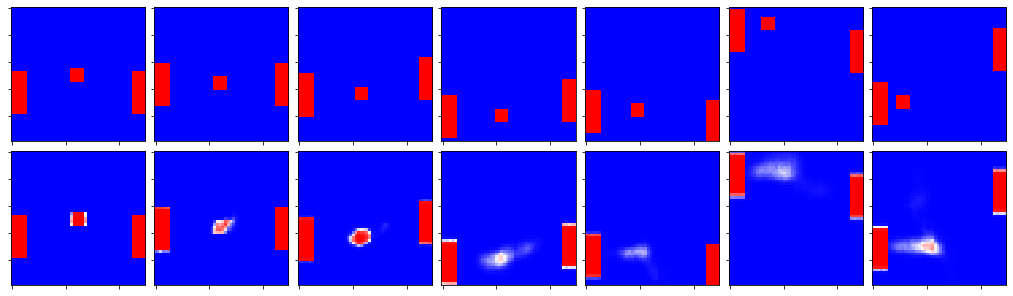

Epoch 50/250
100/100 [==============================] - 110s 1s/step - loss: 0.8545 - frames_loss: 0.0921 - lambda_1_loss: 0.7624 - frames_mean_squared_error: 0.0190 - frames_acc: 0.9774 - lambda_1_mean_squared_error: 172.4593 - lambda_1_acc: 0.9504 - val_loss: 0.6568 - val_frames_loss: 0.0617 - val_lambda_1_loss: 0.5950 - val_frames_mean_squared_error: 0.0154 - val_frames_acc: 0.9820 - val_lambda_1_mean_squared_error: 94.7952 - val_lambda_1_acc: 0.9614


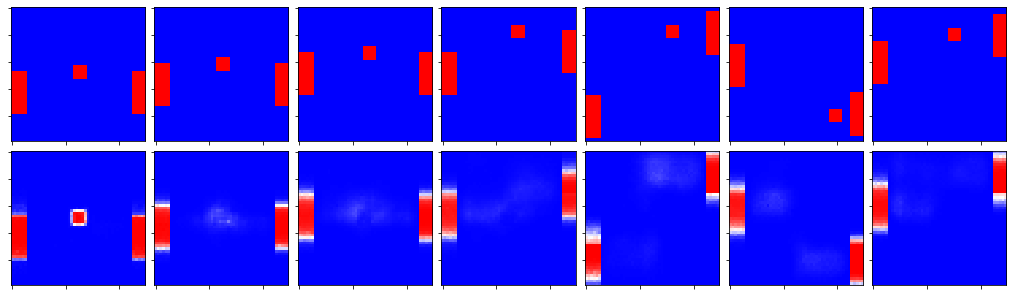

Epoch 51/250
100/100 [==============================] - 111s 1s/step - loss: 0.7822 - frames_loss: 0.0515 - lambda_1_loss: 0.7308 - frames_mean_squared_error: 0.0130 - frames_acc: 0.9850 - lambda_1_mean_squared_error: 181.5229 - lambda_1_acc: 0.9526 - val_loss: 0.4674 - val_frames_loss: 0.0456 - val_lambda_1_loss: 0.4218 - val_frames_mean_squared_error: 0.0116 - val_frames_acc: 0.9866 - val_lambda_1_mean_squared_error: 256.5152 - val_lambda_1_acc: 0.9727


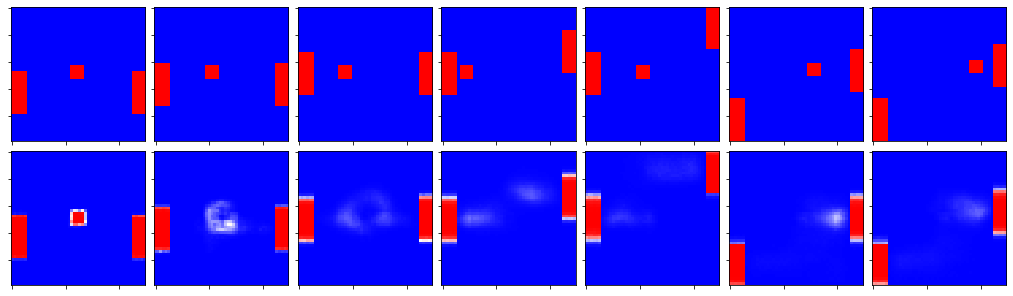

Epoch 52/250
100/100 [==============================] - 110s 1s/step - loss: 0.7307 - frames_loss: 0.0438 - lambda_1_loss: 0.6869 - frames_mean_squared_error: 0.0113 - frames_acc: 0.9868 - lambda_1_mean_squared_error: 322.6685 - lambda_1_acc: 0.9555 - val_loss: 0.7638 - val_frames_loss: 0.0464 - val_lambda_1_loss: 0.7174 - val_frames_mean_squared_error: 0.0123 - val_frames_acc: 0.9854 - val_lambda_1_mean_squared_error: 346.3053 - val_lambda_1_acc: 0.9535


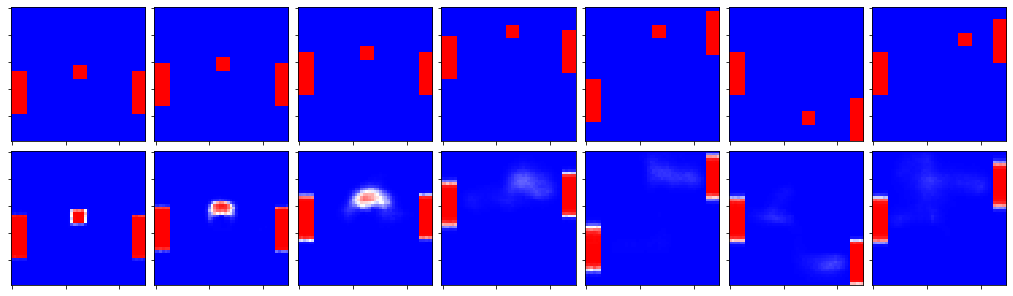

Epoch 53/250
100/100 [==============================] - 110s 1s/step - loss: 0.7009 - frames_loss: 0.0440 - lambda_1_loss: 0.6570 - frames_mean_squared_error: 0.0115 - frames_acc: 0.9864 - lambda_1_mean_squared_error: 322.9454 - lambda_1_acc: 0.9574 - val_loss: 0.7703 - val_frames_loss: 0.0416 - val_lambda_1_loss: 0.7287 - val_frames_mean_squared_error: 0.0109 - val_frames_acc: 0.9870 - val_lambda_1_mean_squared_error: 340.2625 - val_lambda_1_acc: 0.9528


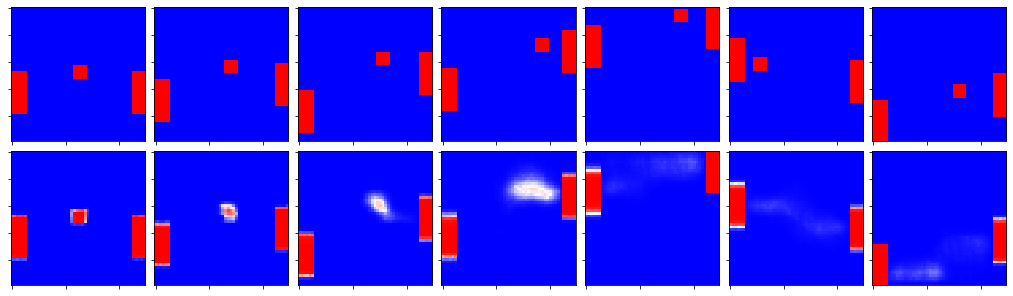

Epoch 54/250
100/100 [==============================] - 111s 1s/step - loss: 0.7135 - frames_loss: 0.0410 - lambda_1_loss: 0.6724 - frames_mean_squared_error: 0.0109 - frames_acc: 0.9871 - lambda_1_mean_squared_error: 376.6058 - lambda_1_acc: 0.9564 - val_loss: 0.4305 - val_frames_loss: 0.0389 - val_lambda_1_loss: 0.3916 - val_frames_mean_squared_error: 0.0103 - val_frames_acc: 0.9879 - val_lambda_1_mean_squared_error: 395.0431 - val_lambda_1_acc: 0.9746


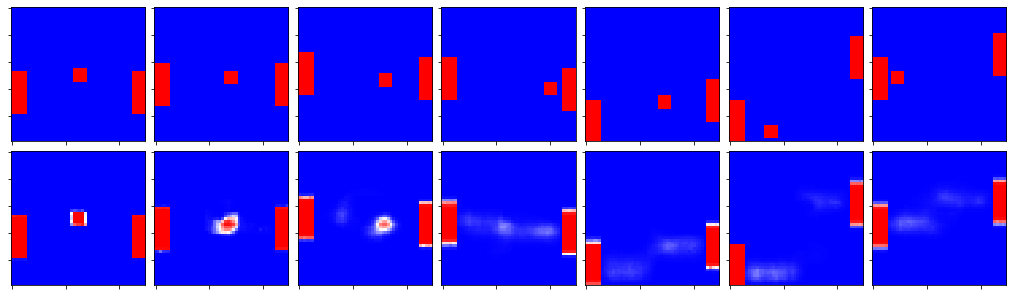

Epoch 55/250
100/100 [==============================] - 111s 1s/step - loss: 0.6957 - frames_loss: 0.0382 - lambda_1_loss: 0.6576 - frames_mean_squared_error: 0.0101 - frames_acc: 0.9880 - lambda_1_mean_squared_error: 457.0219 - lambda_1_acc: 0.9574 - val_loss: 0.6849 - val_frames_loss: 0.0372 - val_lambda_1_loss: 0.6477 - val_frames_mean_squared_error: 0.0098 - val_frames_acc: 0.9884 - val_lambda_1_mean_squared_error: 492.5241 - val_lambda_1_acc: 0.9580


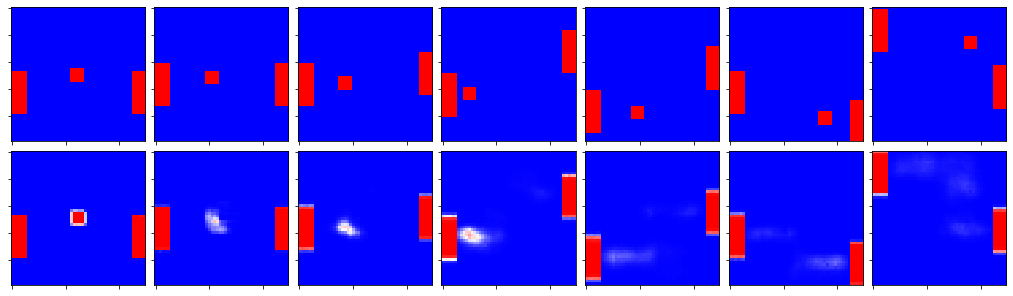

Epoch 56/250
100/100 [==============================] - 111s 1s/step - loss: 0.6850 - frames_loss: 0.0392 - lambda_1_loss: 0.6457 - frames_mean_squared_error: 0.0105 - frames_acc: 0.9875 - lambda_1_mean_squared_error: 461.8114 - lambda_1_acc: 0.9581 - val_loss: 1.4702 - val_frames_loss: 0.0373 - val_lambda_1_loss: 1.4329 - val_frames_mean_squared_error: 0.0099 - val_frames_acc: 0.9884 - val_lambda_1_mean_squared_error: 412.5612 - val_lambda_1_acc: 0.9071


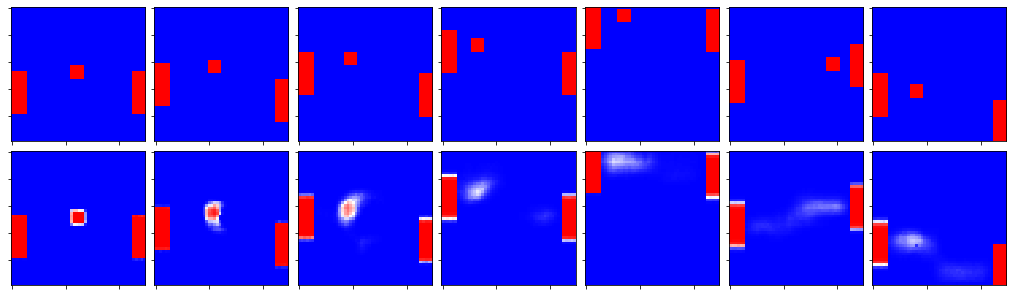

Epoch 57/250
100/100 [==============================] - 110s 1s/step - loss: 0.6432 - frames_loss: 0.0363 - lambda_1_loss: 0.6068 - frames_mean_squared_error: 0.0098 - frames_acc: 0.9884 - lambda_1_mean_squared_error: 500.0223 - lambda_1_acc: 0.9607 - val_loss: 0.8017 - val_frames_loss: 0.0391 - val_lambda_1_loss: 0.7626 - val_frames_mean_squared_error: 0.0106 - val_frames_acc: 0.9871 - val_lambda_1_mean_squared_error: 526.3243 - val_lambda_1_acc: 0.9506


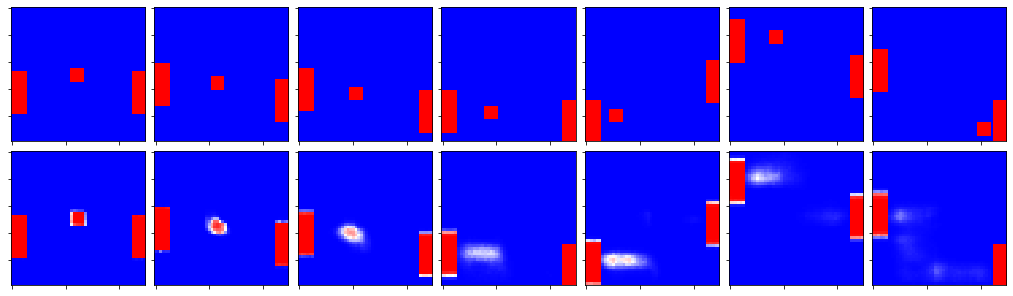

Epoch 58/250
100/100 [==============================] - 110s 1s/step - loss: 0.7081 - frames_loss: 0.0371 - lambda_1_loss: 0.6710 - frames_mean_squared_error: 0.0101 - frames_acc: 0.9878 - lambda_1_mean_squared_error: 510.5139 - lambda_1_acc: 0.9565 - val_loss: 0.3110 - val_frames_loss: 0.0361 - val_lambda_1_loss: 0.2749 - val_frames_mean_squared_error: 0.0097 - val_frames_acc: 0.9883 - val_lambda_1_mean_squared_error: 464.2926 - val_lambda_1_acc: 0.9822


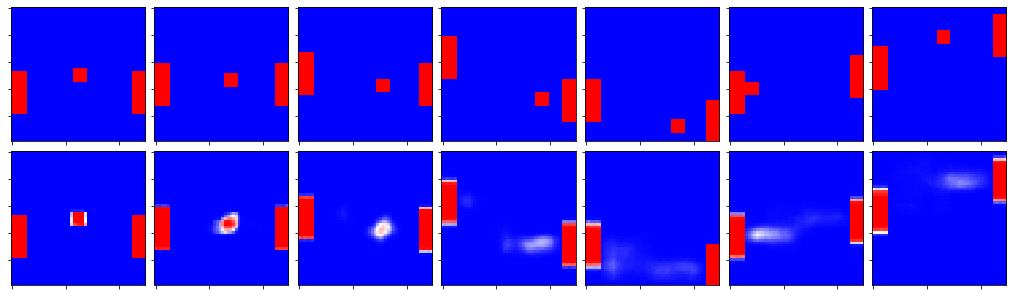

Epoch 59/250
100/100 [==============================] - 111s 1s/step - loss: 0.7917 - frames_loss: 0.0351 - lambda_1_loss: 0.7565 - frames_mean_squared_error: 0.0096 - frames_acc: 0.9885 - lambda_1_mean_squared_error: 528.3118 - lambda_1_acc: 0.9510 - val_loss: 0.8133 - val_frames_loss: 0.0338 - val_lambda_1_loss: 0.7795 - val_frames_mean_squared_error: 0.0093 - val_frames_acc: 0.9889 - val_lambda_1_mean_squared_error: 532.1027 - val_lambda_1_acc: 0.9495


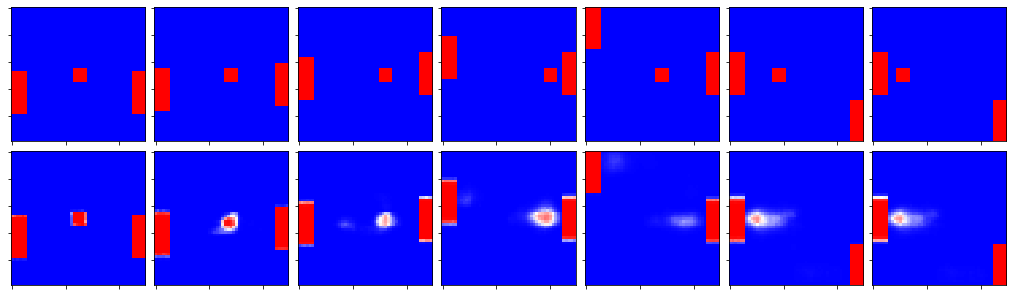

Epoch 60/250
100/100 [==============================] - 111s 1s/step - loss: 0.7597 - frames_loss: 0.0348 - lambda_1_loss: 0.7249 - frames_mean_squared_error: 0.0095 - frames_acc: 0.9884 - lambda_1_mean_squared_error: 556.3373 - lambda_1_acc: 0.9530 - val_loss: 0.6662 - val_frames_loss: 0.0335 - val_lambda_1_loss: 0.6327 - val_frames_mean_squared_error: 0.0091 - val_frames_acc: 0.9891 - val_lambda_1_mean_squared_error: 565.5740 - val_lambda_1_acc: 0.9590


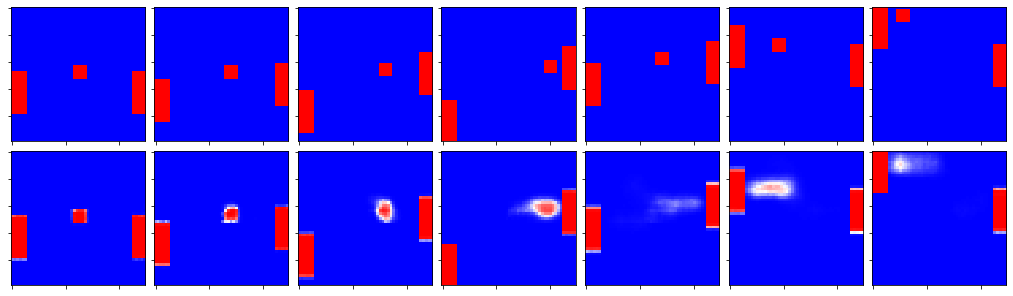

Epoch 61/250
100/100 [==============================] - 110s 1s/step - loss: 0.7212 - frames_loss: 0.0349 - lambda_1_loss: 0.6862 - frames_mean_squared_error: 0.0096 - frames_acc: 0.9883 - lambda_1_mean_squared_error: 550.5338 - lambda_1_acc: 0.9555 - val_loss: 1.0842 - val_frames_loss: 0.0335 - val_lambda_1_loss: 1.0507 - val_frames_mean_squared_error: 0.0092 - val_frames_acc: 0.9889 - val_lambda_1_mean_squared_error: 559.1371 - val_lambda_1_acc: 0.9319


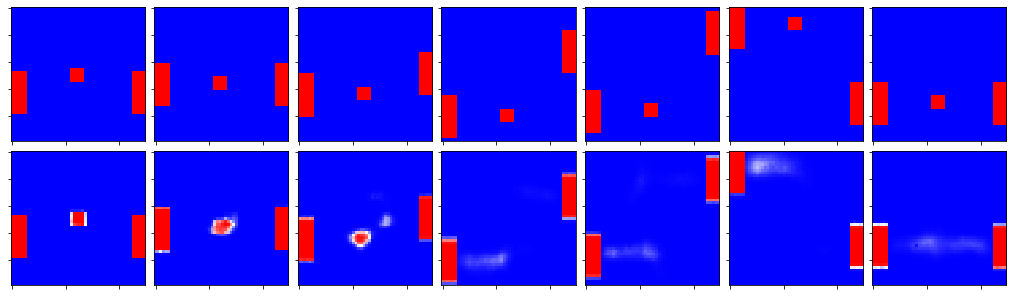

Epoch 62/250
100/100 [==============================] - 111s 1s/step - loss: 0.7508 - frames_loss: 0.0337 - lambda_1_loss: 0.7171 - frames_mean_squared_error: 0.0094 - frames_acc: 0.9885 - lambda_1_mean_squared_error: 591.5822 - lambda_1_acc: 0.9535 - val_loss: 0.7995 - val_frames_loss: 0.0350 - val_lambda_1_loss: 0.7645 - val_frames_mean_squared_error: 0.0097 - val_frames_acc: 0.9880 - val_lambda_1_mean_squared_error: 524.1188 - val_lambda_1_acc: 0.9504


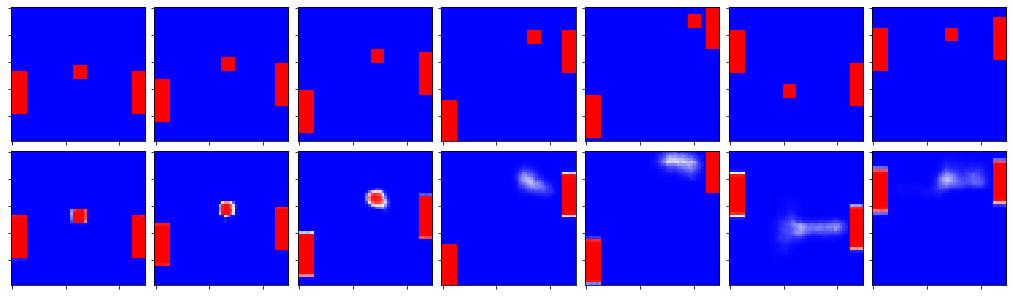

Epoch 63/250
100/100 [==============================] - 111s 1s/step - loss: 0.7353 - frames_loss: 0.0338 - lambda_1_loss: 0.7015 - frames_mean_squared_error: 0.0094 - frames_acc: 0.9885 - lambda_1_mean_squared_error: 559.7435 - lambda_1_acc: 0.9545 - val_loss: 1.0864 - val_frames_loss: 0.0320 - val_lambda_1_loss: 1.0544 - val_frames_mean_squared_error: 0.0088 - val_frames_acc: 0.9893 - val_lambda_1_mean_squared_error: 573.2885 - val_lambda_1_acc: 0.9316


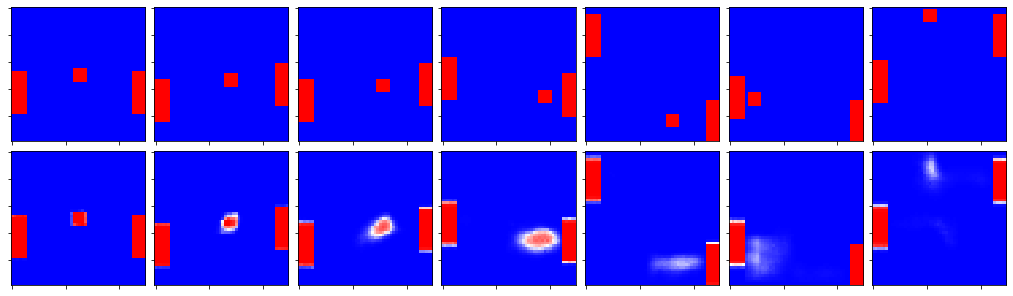

Epoch 64/250
100/100 [==============================] - 110s 1s/step - loss: 0.7274 - frames_loss: 0.0340 - lambda_1_loss: 0.6934 - frames_mean_squared_error: 0.0095 - frames_acc: 0.9882 - lambda_1_mean_squared_error: 552.1266 - lambda_1_acc: 0.9550 - val_loss: 0.6162 - val_frames_loss: 0.0325 - val_lambda_1_loss: 0.5837 - val_frames_mean_squared_error: 0.0091 - val_frames_acc: 0.9890 - val_lambda_1_mean_squared_error: 556.6805 - val_lambda_1_acc: 0.9622


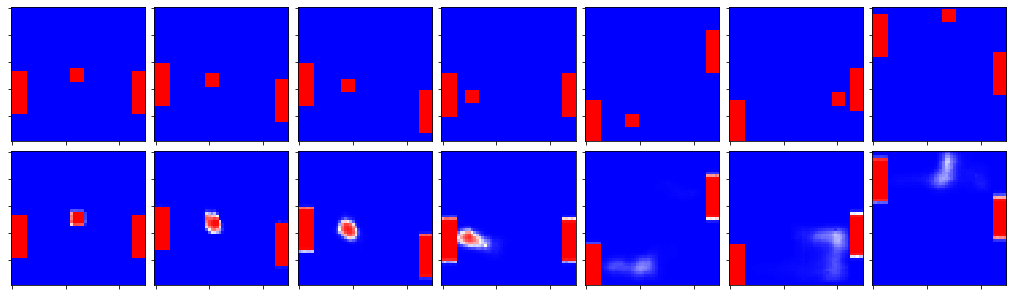

Epoch 65/250
100/100 [==============================] - 111s 1s/step - loss: 0.7100 - frames_loss: 0.0320 - lambda_1_loss: 0.6780 - frames_mean_squared_error: 0.0090 - frames_acc: 0.9889 - lambda_1_mean_squared_error: 591.8047 - lambda_1_acc: 0.9560 - val_loss: 0.4776 - val_frames_loss: 0.0313 - val_lambda_1_loss: 0.4463 - val_frames_mean_squared_error: 0.0087 - val_frames_acc: 0.9892 - val_lambda_1_mean_squared_error: 581.9116 - val_lambda_1_acc: 0.9711


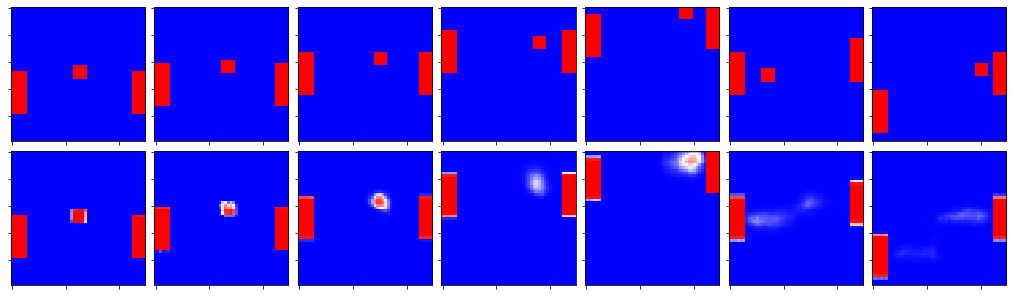

Epoch 66/250
100/100 [==============================] - 110s 1s/step - loss: 0.7606 - frames_loss: 0.0320 - lambda_1_loss: 0.7287 - frames_mean_squared_error: 0.0090 - frames_acc: 0.9889 - lambda_1_mean_squared_error: 588.3371 - lambda_1_acc: 0.9528 - val_loss: 0.4975 - val_frames_loss: 0.0324 - val_lambda_1_loss: 0.4651 - val_frames_mean_squared_error: 0.0091 - val_frames_acc: 0.9887 - val_lambda_1_mean_squared_error: 617.6031 - val_lambda_1_acc: 0.9698


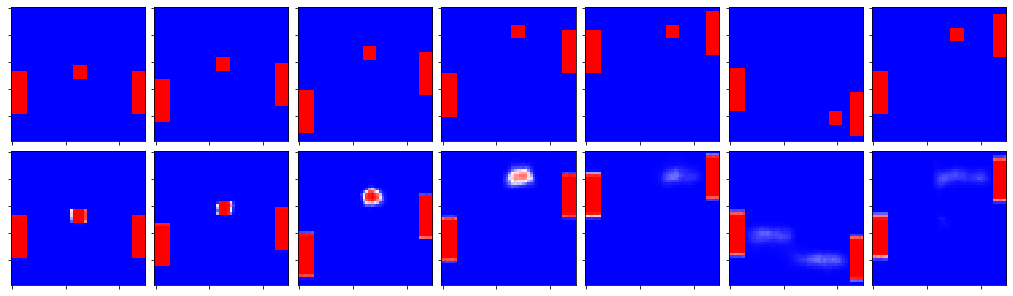

Epoch 67/250
100/100 [==============================] - 110s 1s/step - loss: 0.6933 - frames_loss: 0.0314 - lambda_1_loss: 0.6618 - frames_mean_squared_error: 0.0089 - frames_acc: 0.9889 - lambda_1_mean_squared_error: 623.2512 - lambda_1_acc: 0.9571 - val_loss: 1.0731 - val_frames_loss: 0.0337 - val_lambda_1_loss: 1.0394 - val_frames_mean_squared_error: 0.0095 - val_frames_acc: 0.9881 - val_lambda_1_mean_squared_error: 578.5038 - val_lambda_1_acc: 0.9326


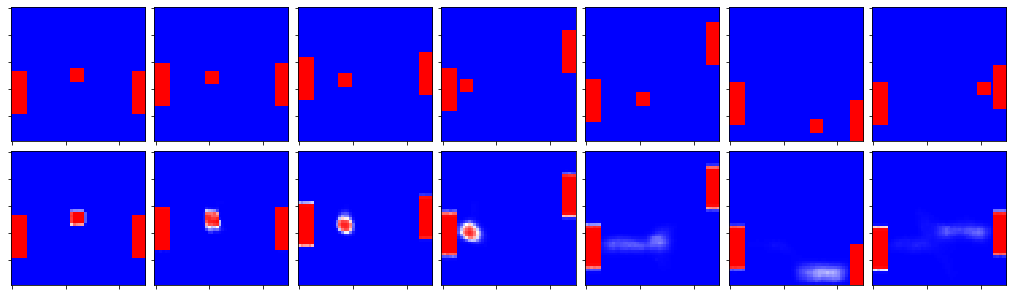

Epoch 68/250
100/100 [==============================] - 111s 1s/step - loss: 0.6817 - frames_loss: 0.0332 - lambda_1_loss: 0.6485 - frames_mean_squared_error: 0.0094 - frames_acc: 0.9882 - lambda_1_mean_squared_error: 543.0688 - lambda_1_acc: 0.9580 - val_loss: 0.3248 - val_frames_loss: 0.0311 - val_lambda_1_loss: 0.2937 - val_frames_mean_squared_error: 0.0088 - val_frames_acc: 0.9890 - val_lambda_1_mean_squared_error: 529.0254 - val_lambda_1_acc: 0.9810


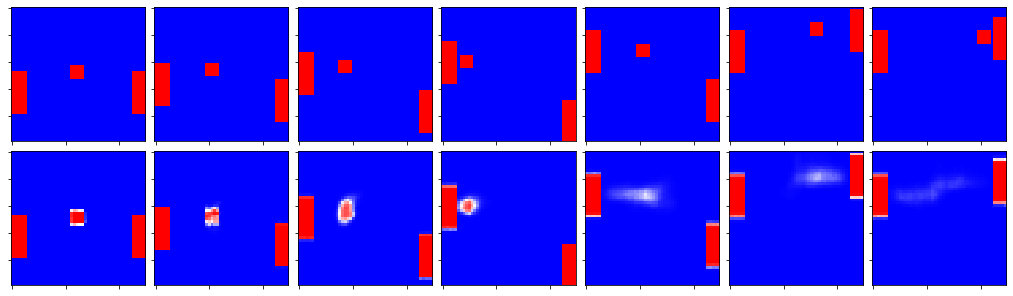

Epoch 69/250
100/100 [==============================] - 111s 1s/step - loss: 0.7308 - frames_loss: 0.0308 - lambda_1_loss: 0.7000 - frames_mean_squared_error: 0.0088 - frames_acc: 0.9891 - lambda_1_mean_squared_error: 567.1348 - lambda_1_acc: 0.9546 - val_loss: 0.6381 - val_frames_loss: 0.0300 - val_lambda_1_loss: 0.6082 - val_frames_mean_squared_error: 0.0085 - val_frames_acc: 0.9893 - val_lambda_1_mean_squared_error: 586.8484 - val_lambda_1_acc: 0.9606


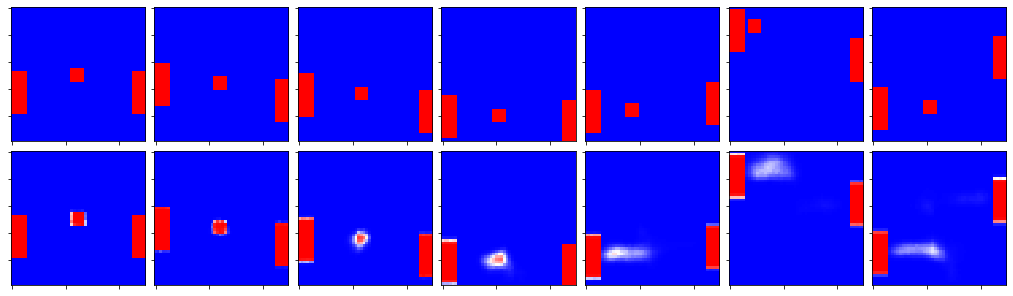

Epoch 70/250
100/100 [==============================] - 111s 1s/step - loss: 0.8034 - frames_loss: 0.0320 - lambda_1_loss: 0.7713 - frames_mean_squared_error: 0.0091 - frames_acc: 0.9886 - lambda_1_mean_squared_error: 550.8772 - lambda_1_acc: 0.9500 - val_loss: 0.5276 - val_frames_loss: 0.0324 - val_lambda_1_loss: 0.4952 - val_frames_mean_squared_error: 0.0093 - val_frames_acc: 0.9882 - val_lambda_1_mean_squared_error: 539.9540 - val_lambda_1_acc: 0.9679


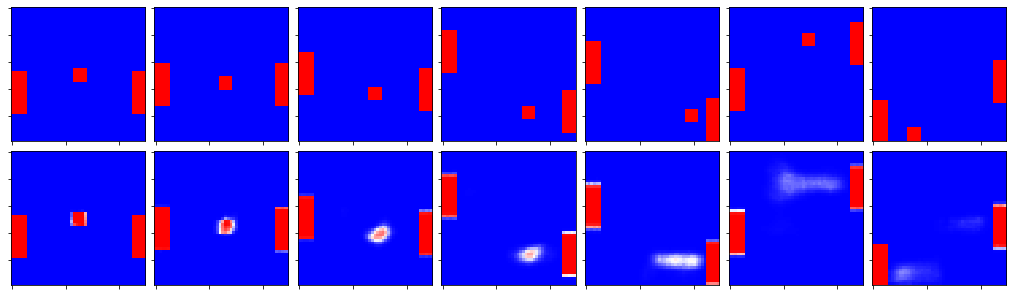

Epoch 71/250
100/100 [==============================] - 111s 1s/step - loss: 0.7308 - frames_loss: 0.0309 - lambda_1_loss: 0.6999 - frames_mean_squared_error: 0.0089 - frames_acc: 0.9888 - lambda_1_mean_squared_error: 548.1212 - lambda_1_acc: 0.9546 - val_loss: 0.4434 - val_frames_loss: 0.0292 - val_lambda_1_loss: 0.4142 - val_frames_mean_squared_error: 0.0084 - val_frames_acc: 0.9894 - val_lambda_1_mean_squared_error: 560.6365 - val_lambda_1_acc: 0.9731


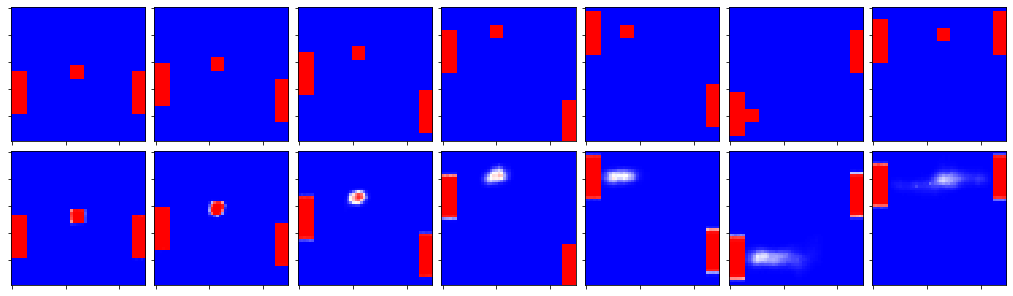

Epoch 72/250
100/100 [==============================] - 111s 1s/step - loss: 0.7501 - frames_loss: 0.0298 - lambda_1_loss: 0.7203 - frames_mean_squared_error: 0.0085 - frames_acc: 0.9892 - lambda_1_mean_squared_error: 585.3823 - lambda_1_acc: 0.9533 - val_loss: 0.6950 - val_frames_loss: 0.0341 - val_lambda_1_loss: 0.6609 - val_frames_mean_squared_error: 0.0098 - val_frames_acc: 0.9874 - val_lambda_1_mean_squared_error: 617.4944 - val_lambda_1_acc: 0.9572


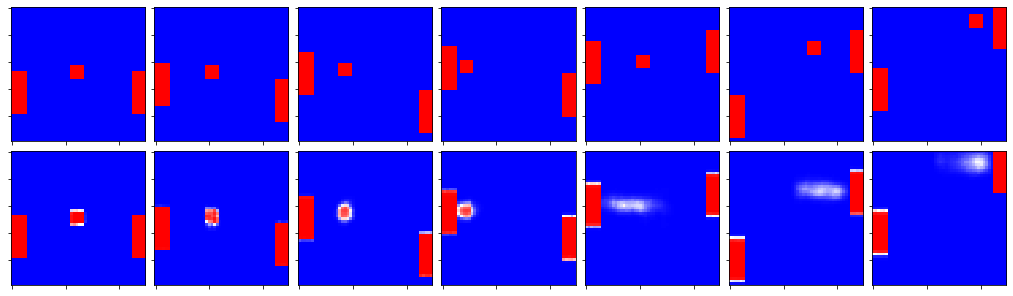

Epoch 73/250
100/100 [==============================] - 111s 1s/step - loss: 0.7238 - frames_loss: 0.0299 - lambda_1_loss: 0.6939 - frames_mean_squared_error: 0.0086 - frames_acc: 0.9891 - lambda_1_mean_squared_error: 580.2761 - lambda_1_acc: 0.9550 - val_loss: 1.1084 - val_frames_loss: 0.0295 - val_lambda_1_loss: 1.0789 - val_frames_mean_squared_error: 0.0085 - val_frames_acc: 0.9892 - val_lambda_1_mean_squared_error: 624.6258 - val_lambda_1_acc: 0.9301


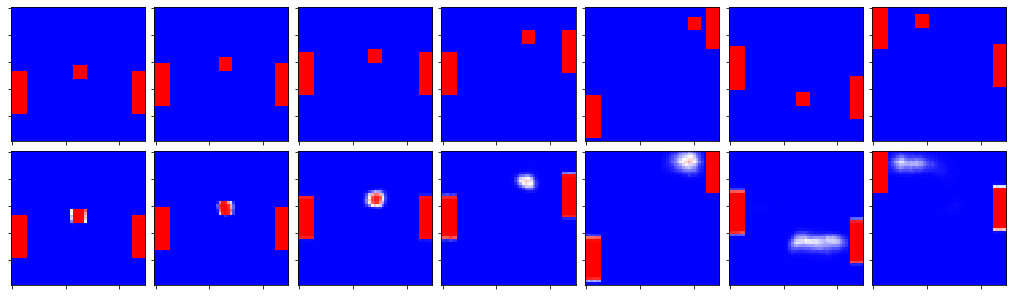

Epoch 74/250
100/100 [==============================] - 110s 1s/step - loss: 0.7650 - frames_loss: 0.0294 - lambda_1_loss: 0.7355 - frames_mean_squared_error: 0.0085 - frames_acc: 0.9892 - lambda_1_mean_squared_error: 596.8010 - lambda_1_acc: 0.9523 - val_loss: 0.3817 - val_frames_loss: 0.0296 - val_lambda_1_loss: 0.3521 - val_frames_mean_squared_error: 0.0085 - val_frames_acc: 0.9891 - val_lambda_1_mean_squared_error: 575.4438 - val_lambda_1_acc: 0.9772


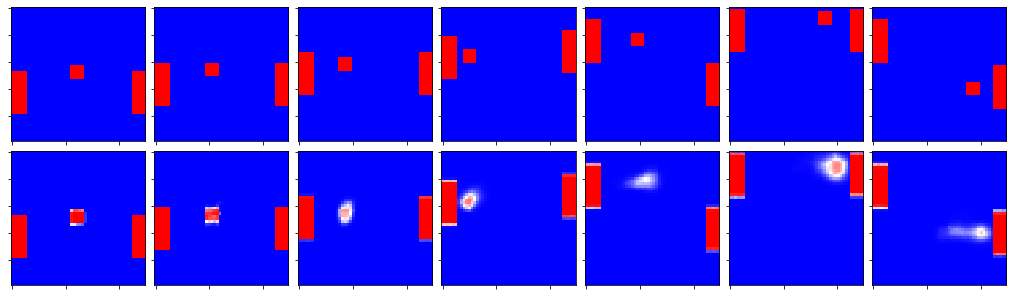

Epoch 75/250
100/100 [==============================] - 111s 1s/step - loss: 0.7456 - frames_loss: 0.0316 - lambda_1_loss: 0.7141 - frames_mean_squared_error: 0.0091 - frames_acc: 0.9884 - lambda_1_mean_squared_error: 521.9682 - lambda_1_acc: 0.9537 - val_loss: 0.5241 - val_frames_loss: 0.0308 - val_lambda_1_loss: 0.4933 - val_frames_mean_squared_error: 0.0089 - val_frames_acc: 0.9886 - val_lambda_1_mean_squared_error: 480.3123 - val_lambda_1_acc: 0.9680


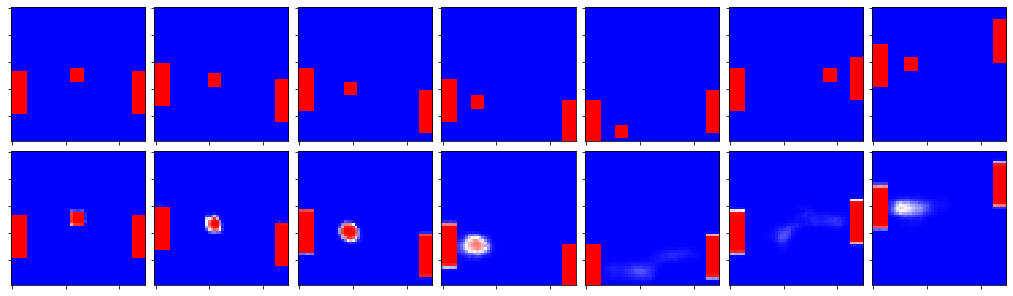

Epoch 76/250
100/100 [==============================] - 111s 1s/step - loss: 0.7787 - frames_loss: 0.0295 - lambda_1_loss: 0.7493 - frames_mean_squared_error: 0.0085 - frames_acc: 0.9891 - lambda_1_mean_squared_error: 508.7527 - lambda_1_acc: 0.9514 - val_loss: 1.0500 - val_frames_loss: 0.0276 - val_lambda_1_loss: 1.0224 - val_frames_mean_squared_error: 0.0079 - val_frames_acc: 0.9900 - val_lambda_1_mean_squared_error: 551.7078 - val_lambda_1_acc: 0.9337


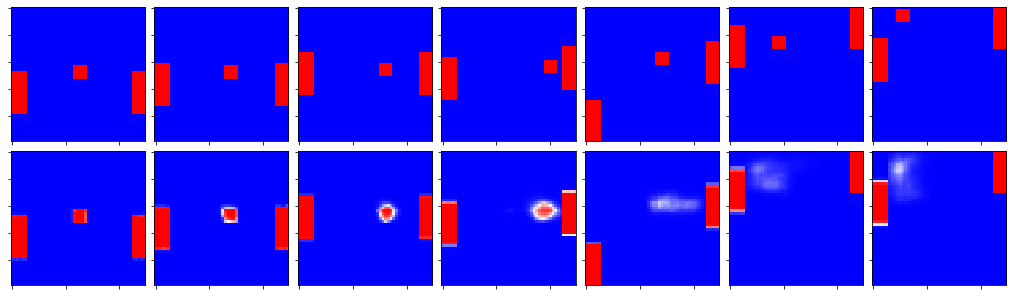

Epoch 77/250
100/100 [==============================] - 111s 1s/step - loss: 0.7723 - frames_loss: 0.0285 - lambda_1_loss: 0.7438 - frames_mean_squared_error: 0.0082 - frames_acc: 0.9895 - lambda_1_mean_squared_error: 573.2306 - lambda_1_acc: 0.9518 - val_loss: 0.3368 - val_frames_loss: 0.0280 - val_lambda_1_loss: 0.3088 - val_frames_mean_squared_error: 0.0081 - val_frames_acc: 0.9895 - val_lambda_1_mean_squared_error: 517.1300 - val_lambda_1_acc: 0.9800


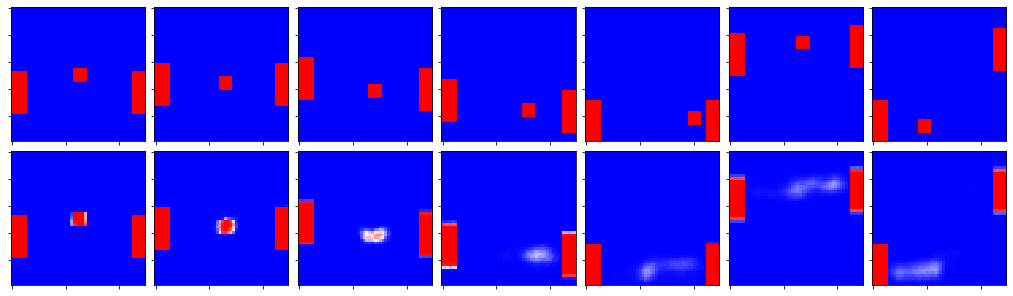

Epoch 78/250
100/100 [==============================] - 111s 1s/step - loss: 0.7387 - frames_loss: 0.0287 - lambda_1_loss: 0.7100 - frames_mean_squared_error: 0.0083 - frames_acc: 0.9893 - lambda_1_mean_squared_error: 572.3033 - lambda_1_acc: 0.9540 - val_loss: 0.8293 - val_frames_loss: 0.0290 - val_lambda_1_loss: 0.8002 - val_frames_mean_squared_error: 0.0084 - val_frames_acc: 0.9893 - val_lambda_1_mean_squared_error: 515.9756 - val_lambda_1_acc: 0.9481


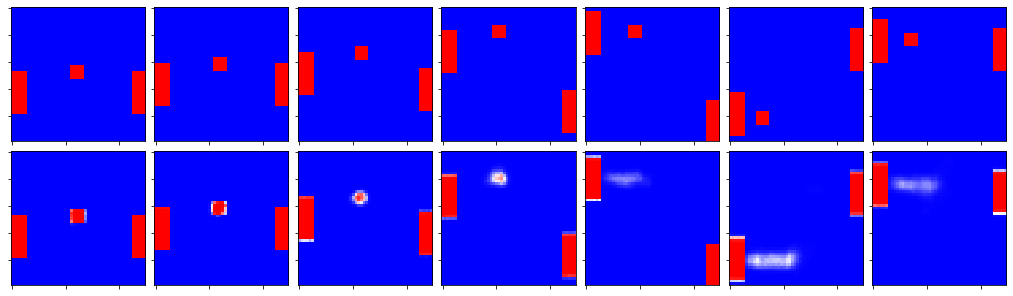

Epoch 79/250
100/100 [==============================] - 111s 1s/step - loss: 0.7424 - frames_loss: 0.0280 - lambda_1_loss: 0.7143 - frames_mean_squared_error: 0.0082 - frames_acc: 0.9895 - lambda_1_mean_squared_error: 549.6418 - lambda_1_acc: 0.9537 - val_loss: 0.4185 - val_frames_loss: 0.0269 - val_lambda_1_loss: 0.3916 - val_frames_mean_squared_error: 0.0078 - val_frames_acc: 0.9900 - val_lambda_1_mean_squared_error: 584.1868 - val_lambda_1_acc: 0.9746


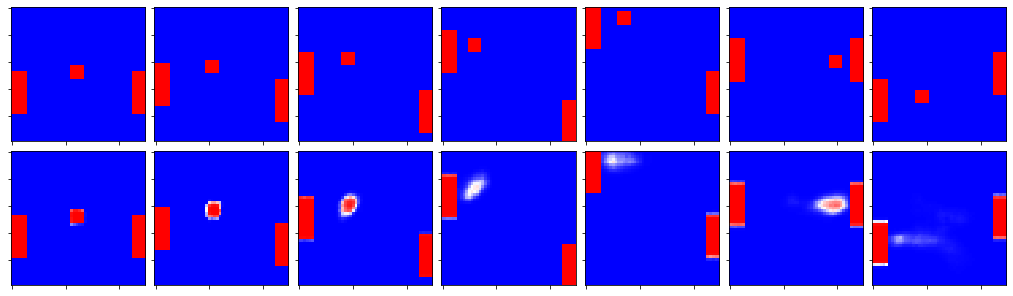

Epoch 80/250
100/100 [==============================] - 111s 1s/step - loss: 0.7087 - frames_loss: 0.0283 - lambda_1_loss: 0.6805 - frames_mean_squared_error: 0.0082 - frames_acc: 0.9894 - lambda_1_mean_squared_error: 561.6703 - lambda_1_acc: 0.9559 - val_loss: 0.6154 - val_frames_loss: 0.0279 - val_lambda_1_loss: 0.5875 - val_frames_mean_squared_error: 0.0081 - val_frames_acc: 0.9896 - val_lambda_1_mean_squared_error: 522.4578 - val_lambda_1_acc: 0.9619


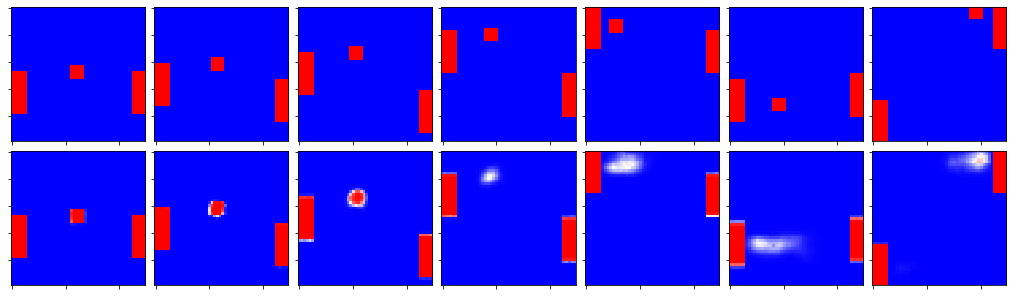

Epoch 81/250
100/100 [==============================] - 111s 1s/step - loss: 0.7131 - frames_loss: 0.0289 - lambda_1_loss: 0.6842 - frames_mean_squared_error: 0.0084 - frames_acc: 0.9891 - lambda_1_mean_squared_error: 526.0182 - lambda_1_acc: 0.9556 - val_loss: 0.8100 - val_frames_loss: 0.0286 - val_lambda_1_loss: 0.7814 - val_frames_mean_squared_error: 0.0084 - val_frames_acc: 0.9892 - val_lambda_1_mean_squared_error: 475.7468 - val_lambda_1_acc: 0.9493


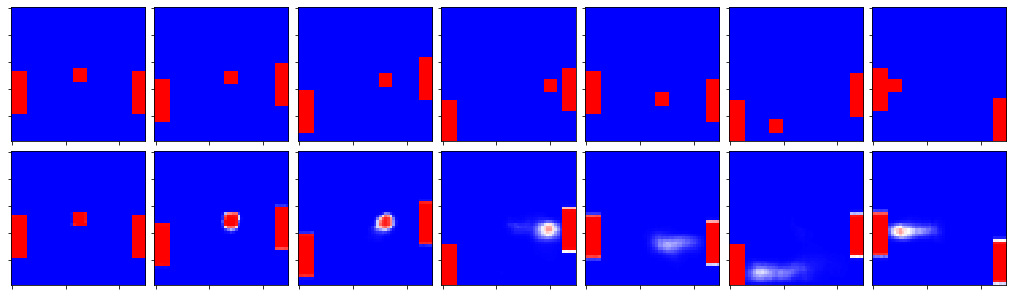

Epoch 82/250
100/100 [==============================] - 110s 1s/step - loss: 0.6379 - frames_loss: 0.0297 - lambda_1_loss: 0.6082 - frames_mean_squared_error: 0.0087 - frames_acc: 0.9888 - lambda_1_mean_squared_error: 466.3083 - lambda_1_acc: 0.9606 - val_loss: 0.6414 - val_frames_loss: 0.0275 - val_lambda_1_loss: 0.6138 - val_frames_mean_squared_error: 0.0080 - val_frames_acc: 0.9896 - val_lambda_1_mean_squared_error: 453.7690 - val_lambda_1_acc: 0.9602


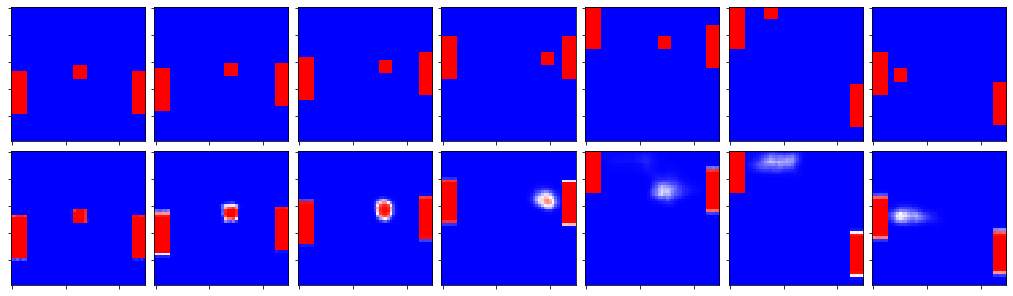

Epoch 83/250
100/100 [==============================] - 111s 1s/step - loss: 0.6863 - frames_loss: 0.0273 - lambda_1_loss: 0.6589 - frames_mean_squared_error: 0.0080 - frames_acc: 0.9896 - lambda_1_mean_squared_error: 500.4217 - lambda_1_acc: 0.9573 - val_loss: 0.7184 - val_frames_loss: 0.0274 - val_lambda_1_loss: 0.6910 - val_frames_mean_squared_error: 0.0081 - val_frames_acc: 0.9895 - val_lambda_1_mean_squared_error: 525.7276 - val_lambda_1_acc: 0.9552


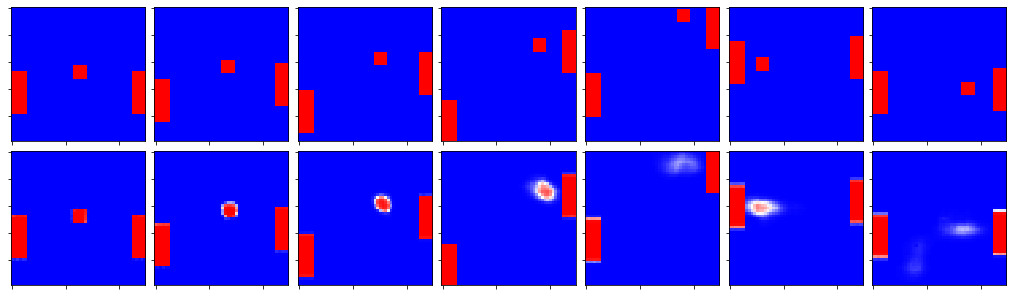

Epoch 84/250
100/100 [==============================] - 110s 1s/step - loss: 0.7776 - frames_loss: 0.0270 - lambda_1_loss: 0.7505 - frames_mean_squared_error: 0.0079 - frames_acc: 0.9896 - lambda_1_mean_squared_error: 544.7171 - lambda_1_acc: 0.9513 - val_loss: 1.0060 - val_frames_loss: 0.0325 - val_lambda_1_loss: 0.9735 - val_frames_mean_squared_error: 0.0094 - val_frames_acc: 0.9878 - val_lambda_1_mean_squared_error: 556.4279 - val_lambda_1_acc: 0.9369


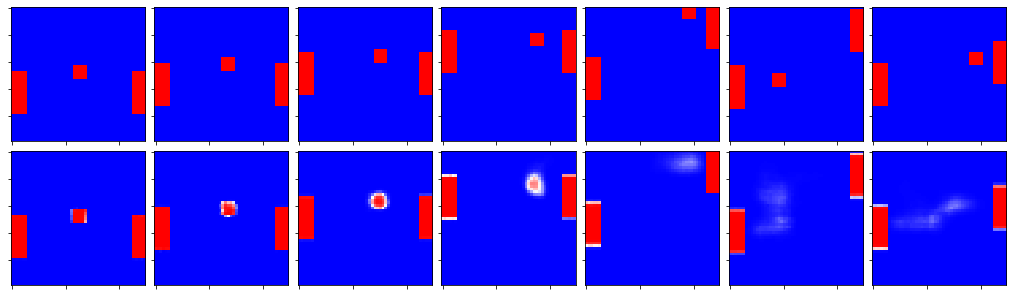

Epoch 85/250
100/100 [==============================] - 111s 1s/step - loss: 0.7186 - frames_loss: 0.0308 - lambda_1_loss: 0.6878 - frames_mean_squared_error: 0.0090 - frames_acc: 0.9882 - lambda_1_mean_squared_error: 451.0461 - lambda_1_acc: 0.9554 - val_loss: 0.5416 - val_frames_loss: 0.0294 - val_lambda_1_loss: 0.5122 - val_frames_mean_squared_error: 0.0087 - val_frames_acc: 0.9886 - val_lambda_1_mean_squared_error: 349.5148 - val_lambda_1_acc: 0.9668


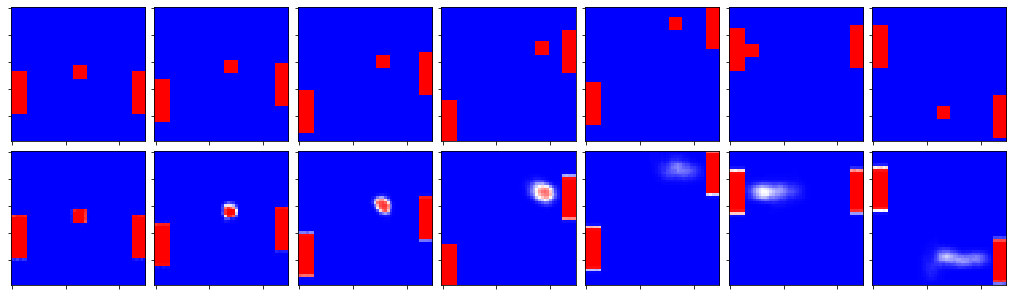

Epoch 86/250
100/100 [==============================] - 111s 1s/step - loss: 0.6546 - frames_loss: 0.0276 - lambda_1_loss: 0.6270 - frames_mean_squared_error: 0.0081 - frames_acc: 0.9894 - lambda_1_mean_squared_error: 429.4450 - lambda_1_acc: 0.9594 - val_loss: 0.0371 - val_frames_loss: 0.0258 - val_lambda_1_loss: 0.0113 - val_frames_mean_squared_error: 0.0076 - val_frames_acc: 0.9901 - val_lambda_1_mean_squared_error: 487.2808 - val_lambda_1_acc: 0.9993


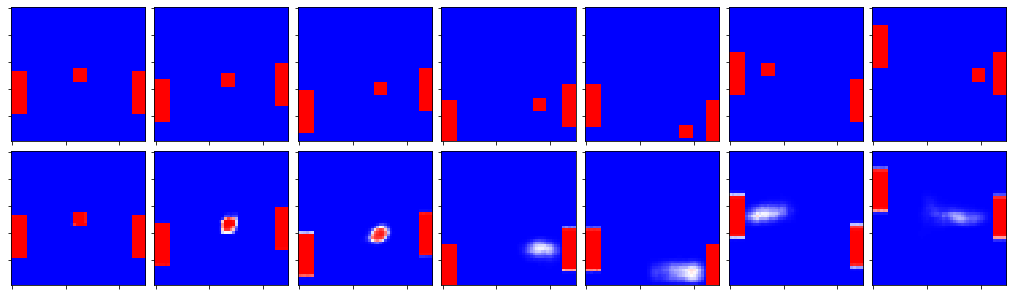

Epoch 87/250
100/100 [==============================] - 110s 1s/step - loss: 0.7265 - frames_loss: 0.0278 - lambda_1_loss: 0.6988 - frames_mean_squared_error: 0.0082 - frames_acc: 0.9893 - lambda_1_mean_squared_error: 487.8019 - lambda_1_acc: 0.9547 - val_loss: 0.5260 - val_frames_loss: 0.0289 - val_lambda_1_loss: 0.4971 - val_frames_mean_squared_error: 0.0084 - val_frames_acc: 0.9892 - val_lambda_1_mean_squared_error: 413.1259 - val_lambda_1_acc: 0.9678


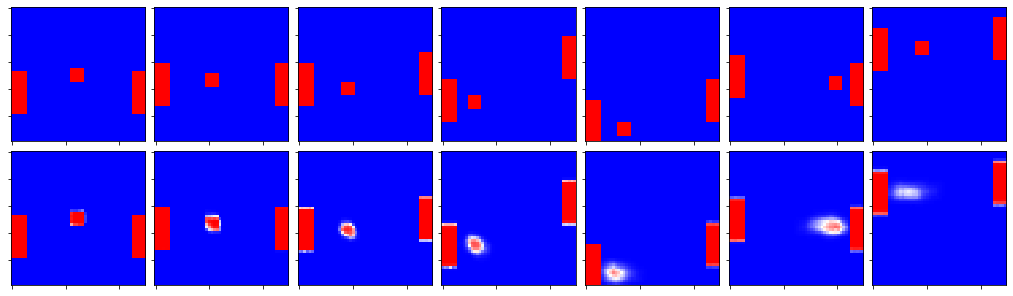

Epoch 88/250
100/100 [==============================] - 111s 1s/step - loss: 0.6700 - frames_loss: 0.0295 - lambda_1_loss: 0.6405 - frames_mean_squared_error: 0.0087 - frames_acc: 0.9886 - lambda_1_mean_squared_error: 413.7668 - lambda_1_acc: 0.9585 - val_loss: 0.2261 - val_frames_loss: 0.0284 - val_lambda_1_loss: 0.1977 - val_frames_mean_squared_error: 0.0084 - val_frames_acc: 0.9888 - val_lambda_1_mean_squared_error: 393.3436 - val_lambda_1_acc: 0.9872


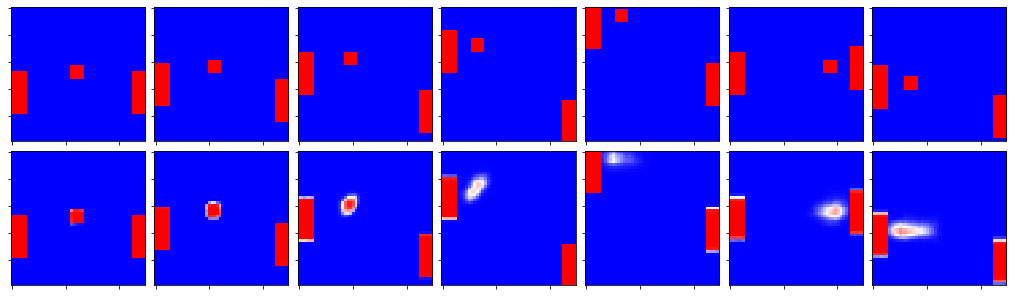

Epoch 89/250
100/100 [==============================] - 111s 1s/step - loss: 0.8006 - frames_loss: 0.0266 - lambda_1_loss: 0.7740 - frames_mean_squared_error: 0.0078 - frames_acc: 0.9897 - lambda_1_mean_squared_error: 427.5249 - lambda_1_acc: 0.9498 - val_loss: 0.4053 - val_frames_loss: 0.0249 - val_lambda_1_loss: 0.3804 - val_frames_mean_squared_error: 0.0074 - val_frames_acc: 0.9902 - val_lambda_1_mean_squared_error: 475.1938 - val_lambda_1_acc: 0.9753


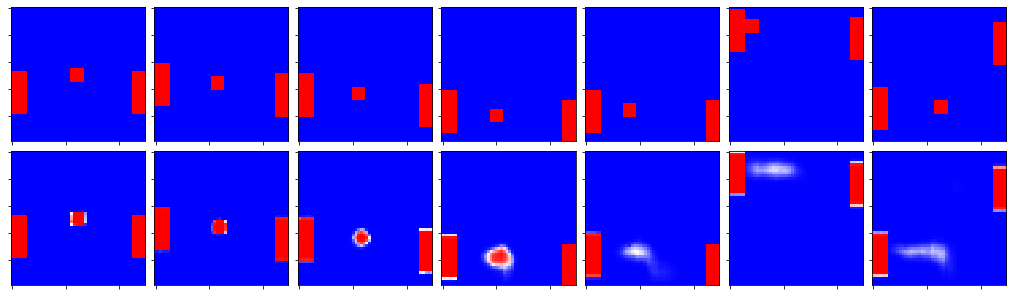

Epoch 90/250
100/100 [==============================] - 110s 1s/step - loss: 0.7229 - frames_loss: 0.0272 - lambda_1_loss: 0.6957 - frames_mean_squared_error: 0.0081 - frames_acc: 0.9893 - lambda_1_mean_squared_error: 458.0479 - lambda_1_acc: 0.9549 - val_loss: 0.5969 - val_frames_loss: 0.0264 - val_lambda_1_loss: 0.5705 - val_frames_mean_squared_error: 0.0078 - val_frames_acc: 0.9896 - val_lambda_1_mean_squared_error: 404.0268 - val_lambda_1_acc: 0.9630


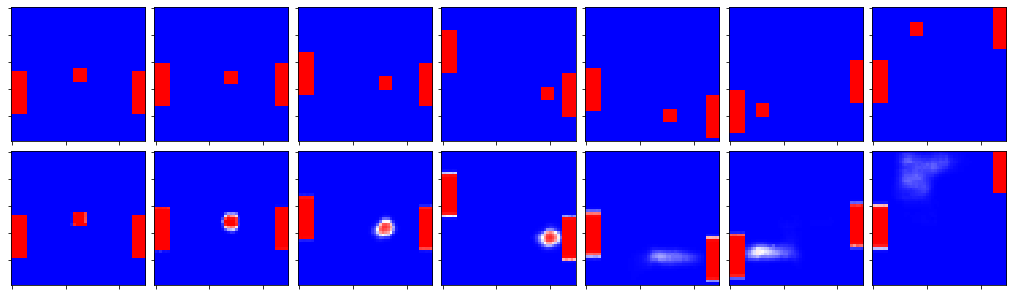

Epoch 91/250
100/100 [==============================] - 111s 1s/step - loss: 0.6752 - frames_loss: 0.0266 - lambda_1_loss: 0.6486 - frames_mean_squared_error: 0.0079 - frames_acc: 0.9895 - lambda_1_mean_squared_error: 435.5122 - lambda_1_acc: 0.9579 - val_loss: 0.5917 - val_frames_loss: 0.0249 - val_lambda_1_loss: 0.5668 - val_frames_mean_squared_error: 0.0074 - val_frames_acc: 0.9903 - val_lambda_1_mean_squared_error: 445.0301 - val_lambda_1_acc: 0.9633


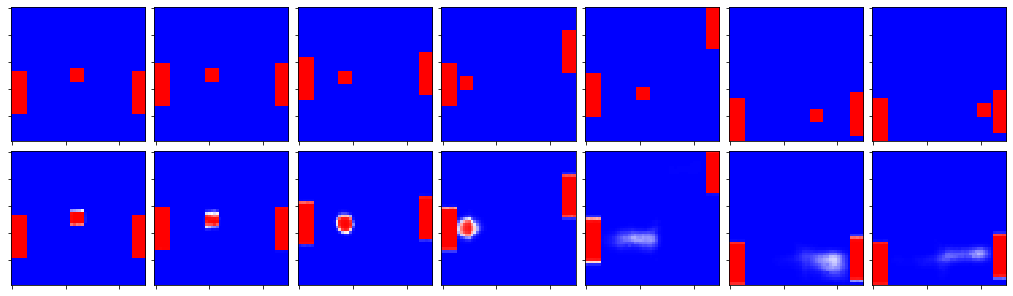

Epoch 92/250
100/100 [==============================] - 111s 1s/step - loss: 0.7178 - frames_loss: 0.0256 - lambda_1_loss: 0.6922 - frames_mean_squared_error: 0.0076 - frames_acc: 0.9900 - lambda_1_mean_squared_error: 467.4494 - lambda_1_acc: 0.9551 - val_loss: 0.9135 - val_frames_loss: 0.0248 - val_lambda_1_loss: 0.8887 - val_frames_mean_squared_error: 0.0073 - val_frames_acc: 0.9903 - val_lambda_1_mean_squared_error: 470.5016 - val_lambda_1_acc: 0.9424


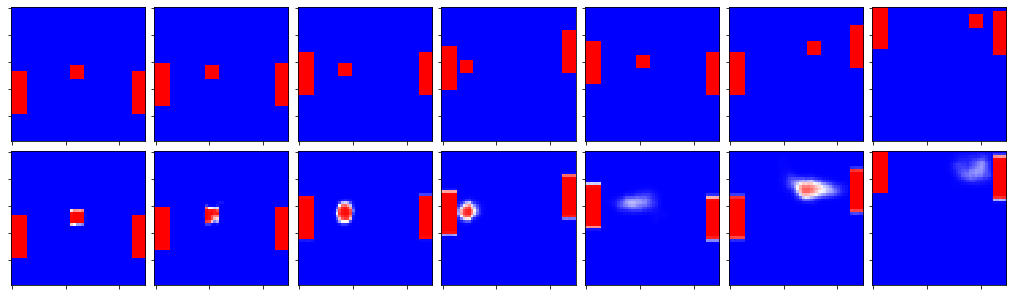

Epoch 93/250
100/100 [==============================] - 110s 1s/step - loss: 0.7418 - frames_loss: 0.0258 - lambda_1_loss: 0.7160 - frames_mean_squared_error: 0.0076 - frames_acc: 0.9899 - lambda_1_mean_squared_error: 464.4672 - lambda_1_acc: 0.9536 - val_loss: 0.8029 - val_frames_loss: 0.0253 - val_lambda_1_loss: 0.7776 - val_frames_mean_squared_error: 0.0075 - val_frames_acc: 0.9901 - val_lambda_1_mean_squared_error: 443.7495 - val_lambda_1_acc: 0.9496


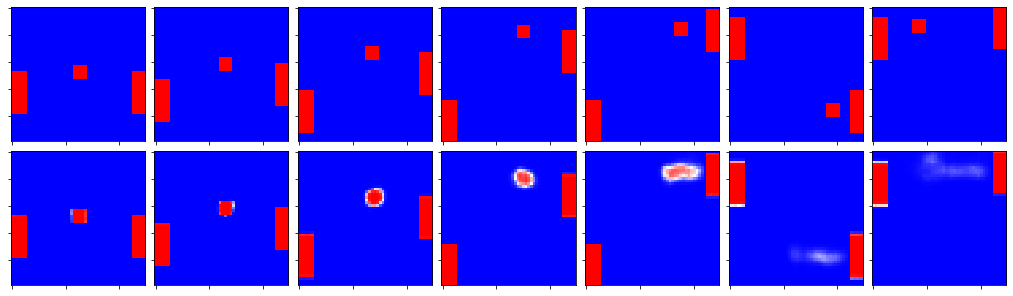

Epoch 94/250
100/100 [==============================] - 111s 1s/step - loss: 0.7103 - frames_loss: 0.0270 - lambda_1_loss: 0.6834 - frames_mean_squared_error: 0.0080 - frames_acc: 0.9893 - lambda_1_mean_squared_error: 436.4950 - lambda_1_acc: 0.9557 - val_loss: 0.5966 - val_frames_loss: 0.0261 - val_lambda_1_loss: 0.5705 - val_frames_mean_squared_error: 0.0079 - val_frames_acc: 0.9892 - val_lambda_1_mean_squared_error: 418.0528 - val_lambda_1_acc: 0.9630


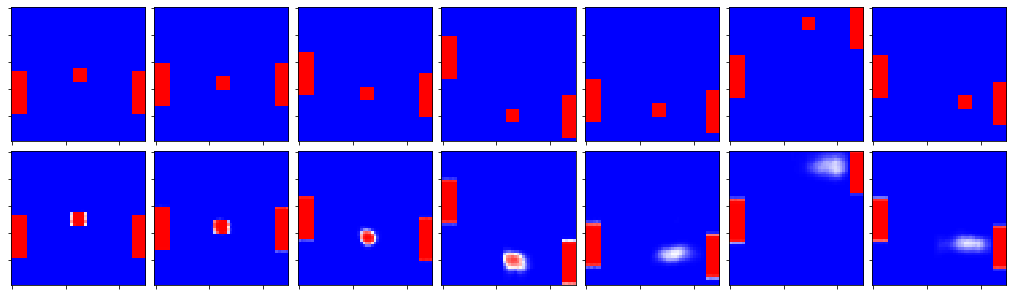

Epoch 95/250
100/100 [==============================] - 110s 1s/step - loss: 0.7296 - frames_loss: 0.0253 - lambda_1_loss: 0.7043 - frames_mean_squared_error: 0.0075 - frames_acc: 0.9900 - lambda_1_mean_squared_error: 440.0009 - lambda_1_acc: 0.9543 - val_loss: 0.9960 - val_frames_loss: 0.0282 - val_lambda_1_loss: 0.9678 - val_frames_mean_squared_error: 0.0084 - val_frames_acc: 0.9887 - val_lambda_1_mean_squared_error: 454.7461 - val_lambda_1_acc: 0.9373


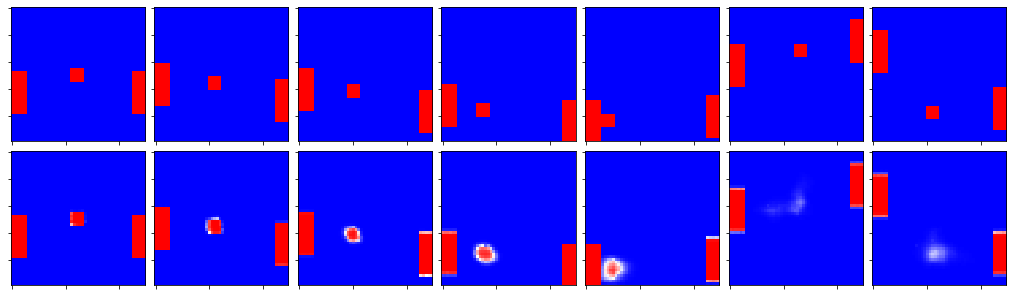

Epoch 96/250
100/100 [==============================] - 111s 1s/step - loss: 0.6883 - frames_loss: 0.0248 - lambda_1_loss: 0.6635 - frames_mean_squared_error: 0.0074 - frames_acc: 0.9901 - lambda_1_mean_squared_error: 452.0310 - lambda_1_acc: 0.9570 - val_loss: 0.6610 - val_frames_loss: 0.0264 - val_lambda_1_loss: 0.6345 - val_frames_mean_squared_error: 0.0079 - val_frames_acc: 0.9893 - val_lambda_1_mean_squared_error: 482.0294 - val_lambda_1_acc: 0.9589


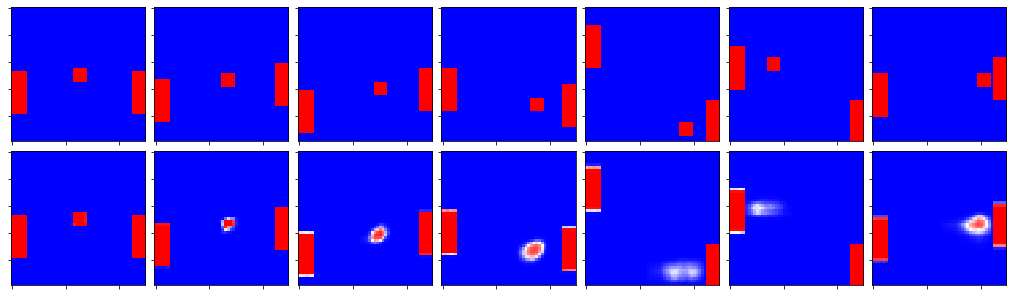

Epoch 97/250
100/100 [==============================] - 111s 1s/step - loss: 0.7231 - frames_loss: 0.0259 - lambda_1_loss: 0.6972 - frames_mean_squared_error: 0.0077 - frames_acc: 0.9898 - lambda_1_mean_squared_error: 425.5934 - lambda_1_acc: 0.9548 - val_loss: 0.4113 - val_frames_loss: 0.0234 - val_lambda_1_loss: 0.3879 - val_frames_mean_squared_error: 0.0070 - val_frames_acc: 0.9906 - val_lambda_1_mean_squared_error: 446.2394 - val_lambda_1_acc: 0.9749


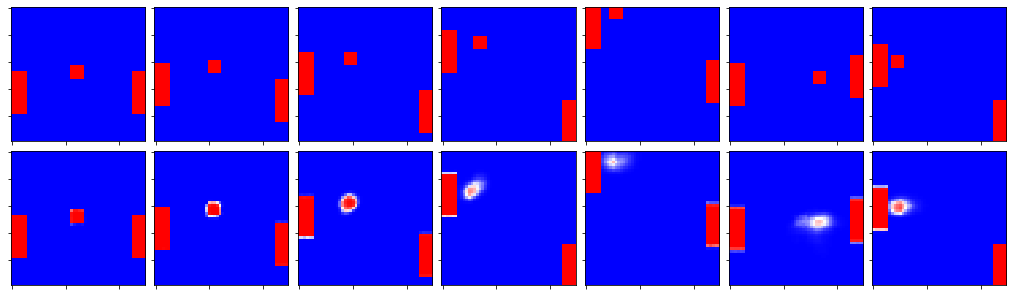

Epoch 98/250
100/100 [==============================] - 111s 1s/step - loss: 0.7141 - frames_loss: 0.0248 - lambda_1_loss: 0.6894 - frames_mean_squared_error: 0.0074 - frames_acc: 0.9900 - lambda_1_mean_squared_error: 451.7907 - lambda_1_acc: 0.9553 - val_loss: 0.7815 - val_frames_loss: 0.0245 - val_lambda_1_loss: 0.7569 - val_frames_mean_squared_error: 0.0072 - val_frames_acc: 0.9903 - val_lambda_1_mean_squared_error: 466.9382 - val_lambda_1_acc: 0.9509


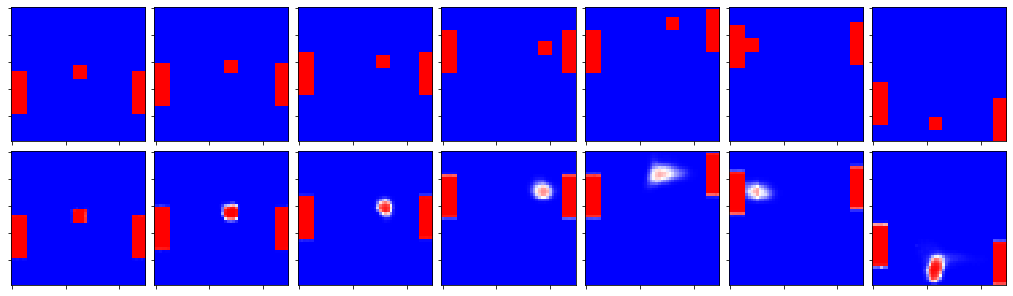

Epoch 99/250
100/100 [==============================] - 110s 1s/step - loss: 0.7465 - frames_loss: 0.0253 - lambda_1_loss: 0.7212 - frames_mean_squared_error: 0.0075 - frames_acc: 0.9899 - lambda_1_mean_squared_error: 431.8369 - lambda_1_acc: 0.9532 - val_loss: 0.9204 - val_frames_loss: 0.0260 - val_lambda_1_loss: 0.8944 - val_frames_mean_squared_error: 0.0077 - val_frames_acc: 0.9896 - val_lambda_1_mean_squared_error: 400.9247 - val_lambda_1_acc: 0.9420


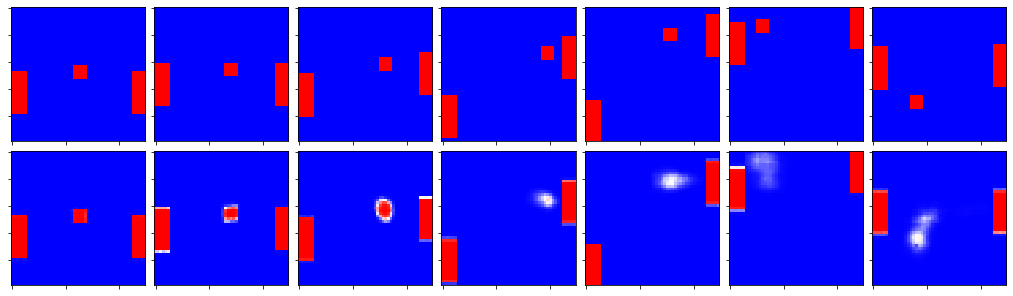

Epoch 100/250
100/100 [==============================] - 110s 1s/step - loss: 0.6746 - frames_loss: 0.0244 - lambda_1_loss: 0.6501 - frames_mean_squared_error: 0.0073 - frames_acc: 0.9902 - lambda_1_mean_squared_error: 429.6070 - lambda_1_acc: 0.9579 - val_loss: 1.3684 - val_frames_loss: 0.0259 - val_lambda_1_loss: 1.3425 - val_frames_mean_squared_error: 0.0079 - val_frames_acc: 0.9892 - val_lambda_1_mean_squared_error: 432.7704 - val_lambda_1_acc: 0.9130


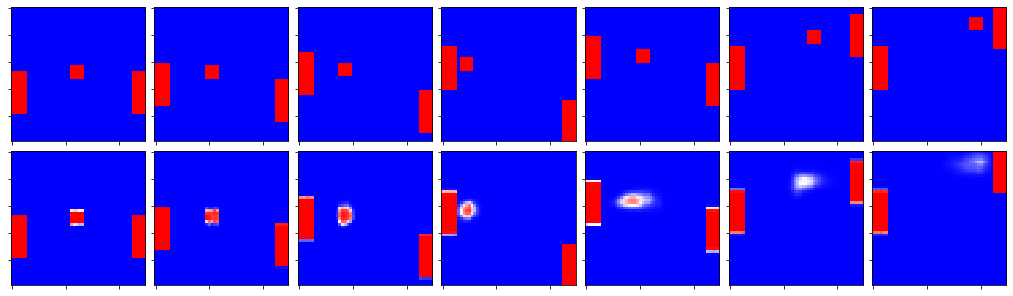

Epoch 101/250
100/100 [==============================] - 111s 1s/step - loss: 0.7004 - frames_loss: 0.0264 - lambda_1_loss: 0.6740 - frames_mean_squared_error: 0.0079 - frames_acc: 0.9894 - lambda_1_mean_squared_error: 414.9577 - lambda_1_acc: 0.9563 - val_loss: 0.9883 - val_frames_loss: 0.0243 - val_lambda_1_loss: 0.9641 - val_frames_mean_squared_error: 0.0073 - val_frames_acc: 0.9901 - val_lambda_1_mean_squared_error: 359.3348 - val_lambda_1_acc: 0.9375


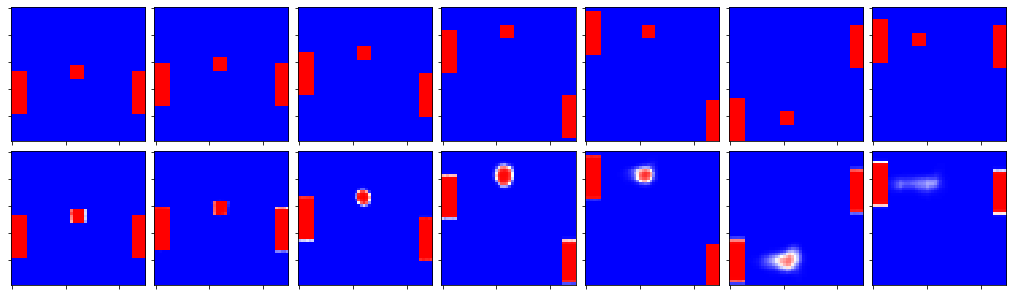

Epoch 102/250
100/100 [==============================] - 111s 1s/step - loss: 0.6800 - frames_loss: 0.0242 - lambda_1_loss: 0.6558 - frames_mean_squared_error: 0.0072 - frames_acc: 0.9902 - lambda_1_mean_squared_error: 394.8674 - lambda_1_acc: 0.9575 - val_loss: 0.7439 - val_frames_loss: 0.0227 - val_lambda_1_loss: 0.7212 - val_frames_mean_squared_error: 0.0067 - val_frames_acc: 0.9910 - val_lambda_1_mean_squared_error: 437.8499 - val_lambda_1_acc: 0.9532


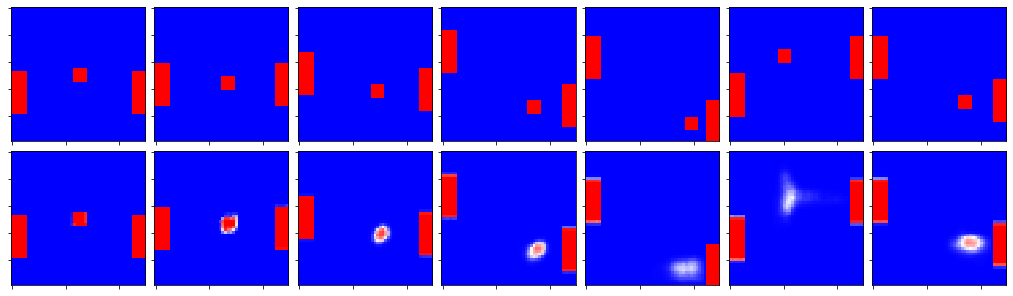

Epoch 103/250
100/100 [==============================] - 110s 1s/step - loss: 0.6924 - frames_loss: 0.0238 - lambda_1_loss: 0.6686 - frames_mean_squared_error: 0.0071 - frames_acc: 0.9904 - lambda_1_mean_squared_error: 418.6203 - lambda_1_acc: 0.9567 - val_loss: 0.7066 - val_frames_loss: 0.0231 - val_lambda_1_loss: 0.6835 - val_frames_mean_squared_error: 0.0069 - val_frames_acc: 0.9907 - val_lambda_1_mean_squared_error: 414.2289 - val_lambda_1_acc: 0.9557


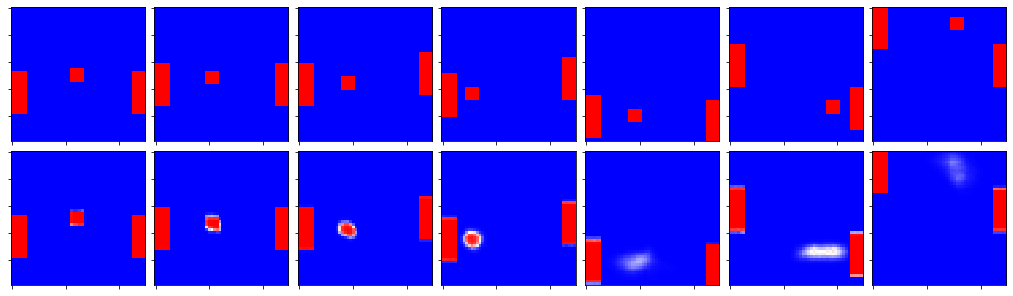

Epoch 104/250
100/100 [==============================] - 111s 1s/step - loss: 0.7507 - frames_loss: 0.0243 - lambda_1_loss: 0.7264 - frames_mean_squared_error: 0.0073 - frames_acc: 0.9901 - lambda_1_mean_squared_error: 416.0898 - lambda_1_acc: 0.9529 - val_loss: 0.6037 - val_frames_loss: 0.0237 - val_lambda_1_loss: 0.5799 - val_frames_mean_squared_error: 0.0072 - val_frames_acc: 0.9901 - val_lambda_1_mean_squared_error: 421.5600 - val_lambda_1_acc: 0.9624


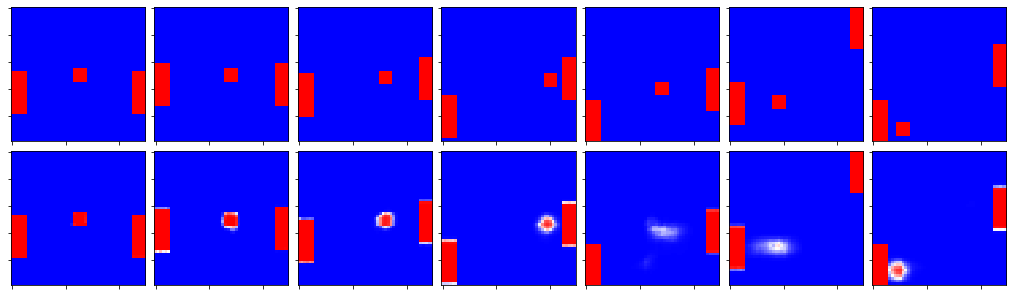

Epoch 105/250
100/100 [==============================] - 111s 1s/step - loss: 0.6957 - frames_loss: 0.0247 - lambda_1_loss: 0.6710 - frames_mean_squared_error: 0.0074 - frames_acc: 0.9899 - lambda_1_mean_squared_error: 400.2771 - lambda_1_acc: 0.9565 - val_loss: 0.5364 - val_frames_loss: 0.0242 - val_lambda_1_loss: 0.5122 - val_frames_mean_squared_error: 0.0073 - val_frames_acc: 0.9901 - val_lambda_1_mean_squared_error: 379.3888 - val_lambda_1_acc: 0.9668


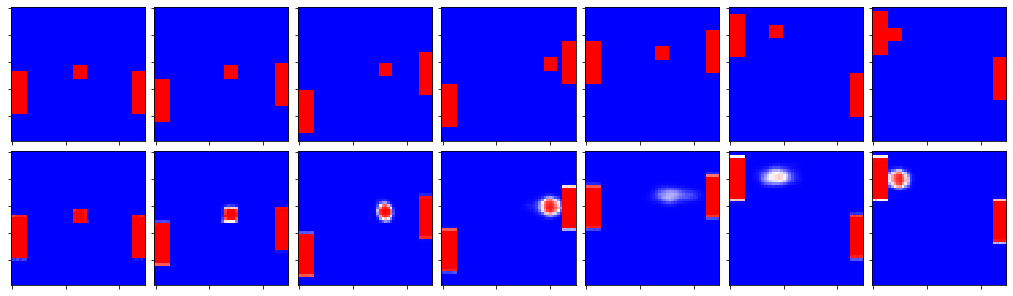

Epoch 106/250
100/100 [==============================] - 110s 1s/step - loss: 0.7663 - frames_loss: 0.0242 - lambda_1_loss: 0.7422 - frames_mean_squared_error: 0.0072 - frames_acc: 0.9902 - lambda_1_mean_squared_error: 382.4081 - lambda_1_acc: 0.9519 - val_loss: 0.4838 - val_frames_loss: 0.0225 - val_lambda_1_loss: 0.4613 - val_frames_mean_squared_error: 0.0067 - val_frames_acc: 0.9909 - val_lambda_1_mean_squared_error: 387.7404 - val_lambda_1_acc: 0.9701


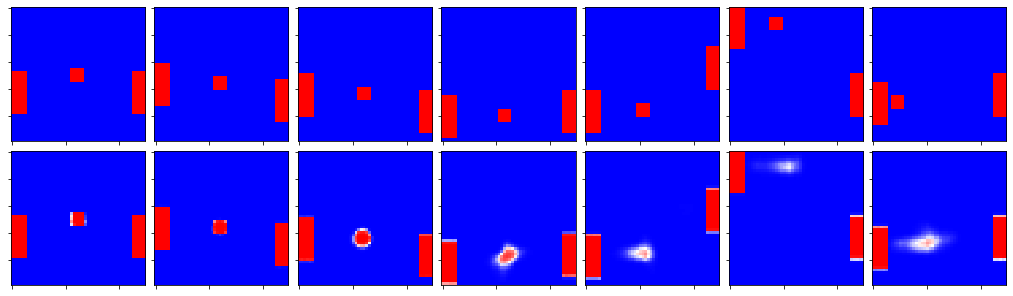

Epoch 107/250
100/100 [==============================] - 111s 1s/step - loss: 0.7033 - frames_loss: 0.0235 - lambda_1_loss: 0.6798 - frames_mean_squared_error: 0.0071 - frames_acc: 0.9903 - lambda_1_mean_squared_error: 398.5328 - lambda_1_acc: 0.9559 - val_loss: 0.6961 - val_frames_loss: 0.0239 - val_lambda_1_loss: 0.6722 - val_frames_mean_squared_error: 0.0073 - val_frames_acc: 0.9899 - val_lambda_1_mean_squared_error: 417.0051 - val_lambda_1_acc: 0.9564


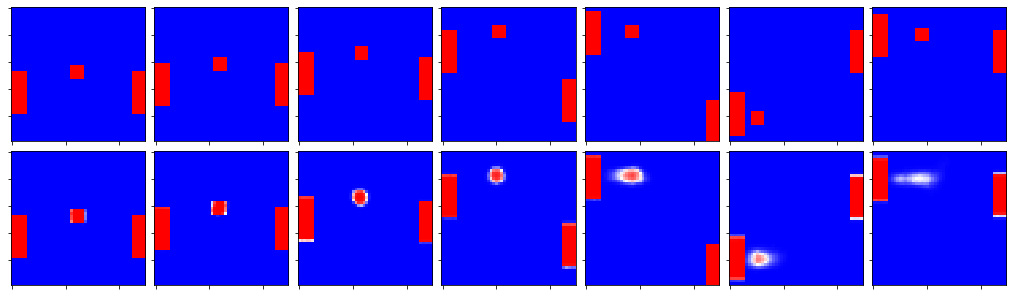

Epoch 108/250
100/100 [==============================] - 110s 1s/step - loss: 0.7675 - frames_loss: 0.0283 - lambda_1_loss: 0.7393 - frames_mean_squared_error: 0.0084 - frames_acc: 0.9887 - lambda_1_mean_squared_error: 308.8326 - lambda_1_acc: 0.9521 - val_loss: 0.9903 - val_frames_loss: 0.0281 - val_lambda_1_loss: 0.9622 - val_frames_mean_squared_error: 0.0084 - val_frames_acc: 0.9885 - val_lambda_1_mean_squared_error: 285.5342 - val_lambda_1_acc: 0.9376


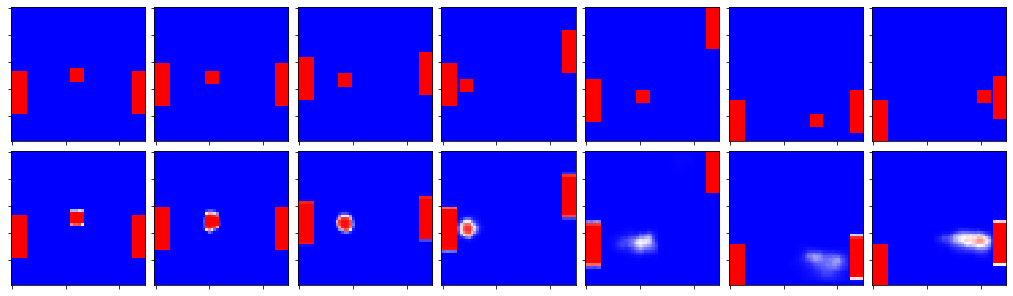

Epoch 109/250
100/100 [==============================] - 111s 1s/step - loss: 0.7068 - frames_loss: 0.0232 - lambda_1_loss: 0.6835 - frames_mean_squared_error: 0.0070 - frames_acc: 0.9905 - lambda_1_mean_squared_error: 336.9957 - lambda_1_acc: 0.9557 - val_loss: 0.5267 - val_frames_loss: 0.0240 - val_lambda_1_loss: 0.5027 - val_frames_mean_squared_error: 0.0073 - val_frames_acc: 0.9900 - val_lambda_1_mean_squared_error: 377.5432 - val_lambda_1_acc: 0.9674


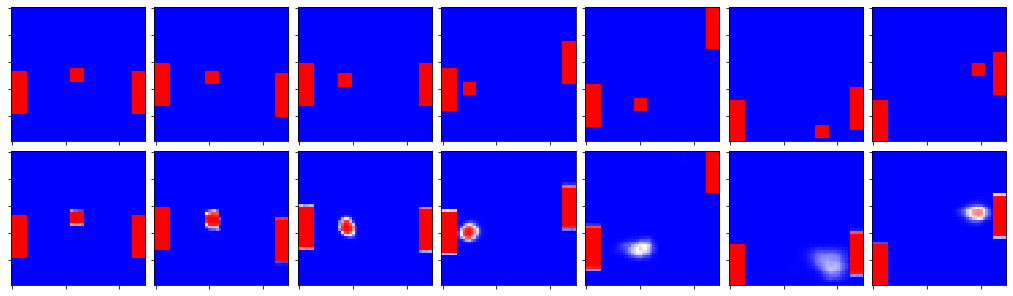

Epoch 110/250
100/100 [==============================] - 111s 1s/step - loss: 0.6838 - frames_loss: 0.0232 - lambda_1_loss: 0.6606 - frames_mean_squared_error: 0.0070 - frames_acc: 0.9904 - lambda_1_mean_squared_error: 390.0621 - lambda_1_acc: 0.9572 - val_loss: 0.5827 - val_frames_loss: 0.0291 - val_lambda_1_loss: 0.5536 - val_frames_mean_squared_error: 0.0084 - val_frames_acc: 0.9885 - val_lambda_1_mean_squared_error: 383.2492 - val_lambda_1_acc: 0.9641


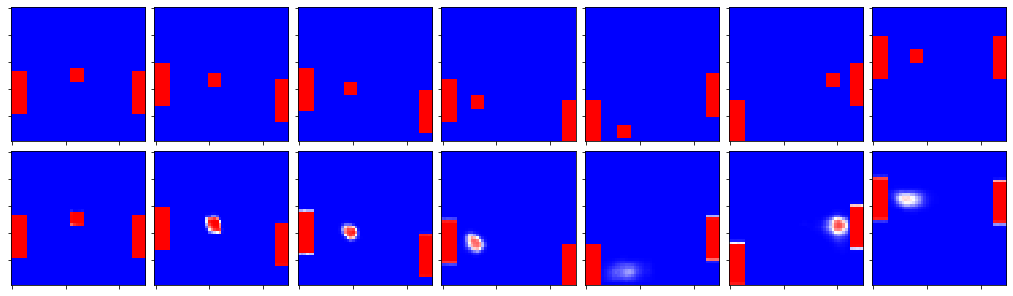

Epoch 111/250
100/100 [==============================] - 111s 1s/step - loss: 0.6776 - frames_loss: 0.0255 - lambda_1_loss: 0.6521 - frames_mean_squared_error: 0.0077 - frames_acc: 0.9895 - lambda_1_mean_squared_error: 329.3815 - lambda_1_acc: 0.9577 - val_loss: 0.9765 - val_frames_loss: 0.0238 - val_lambda_1_loss: 0.9528 - val_frames_mean_squared_error: 0.0072 - val_frames_acc: 0.9900 - val_lambda_1_mean_squared_error: 357.9067 - val_lambda_1_acc: 0.9382


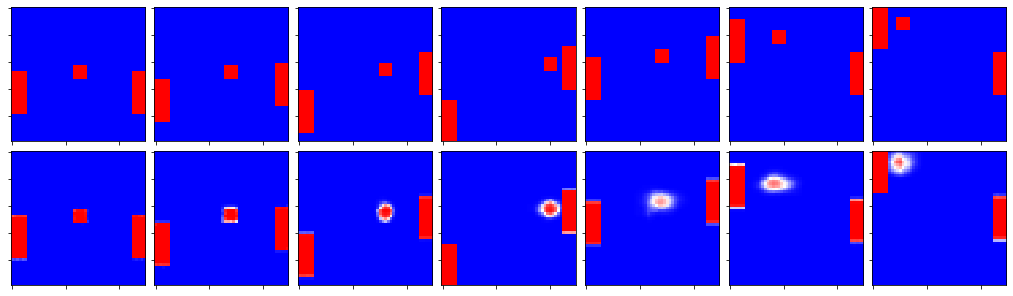

Epoch 112/250
100/100 [==============================] - 111s 1s/step - loss: 0.7099 - frames_loss: 0.0230 - lambda_1_loss: 0.6869 - frames_mean_squared_error: 0.0069 - frames_acc: 0.9905 - lambda_1_mean_squared_error: 353.8083 - lambda_1_acc: 0.9555 - val_loss: 0.9933 - val_frames_loss: 0.0217 - val_lambda_1_loss: 0.9716 - val_frames_mean_squared_error: 0.0065 - val_frames_acc: 0.9913 - val_lambda_1_mean_squared_error: 365.3951 - val_lambda_1_acc: 0.9370


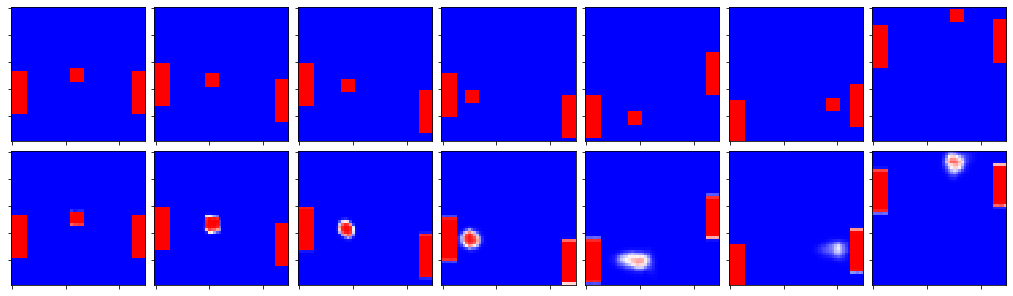

Epoch 113/250
100/100 [==============================] - 111s 1s/step - loss: 0.7693 - frames_loss: 0.0222 - lambda_1_loss: 0.7471 - frames_mean_squared_error: 0.0067 - frames_acc: 0.9908 - lambda_1_mean_squared_error: 376.1253 - lambda_1_acc: 0.9516 - val_loss: 0.6282 - val_frames_loss: 0.0256 - val_lambda_1_loss: 0.6025 - val_frames_mean_squared_error: 0.0077 - val_frames_acc: 0.9894 - val_lambda_1_mean_squared_error: 399.3174 - val_lambda_1_acc: 0.9609


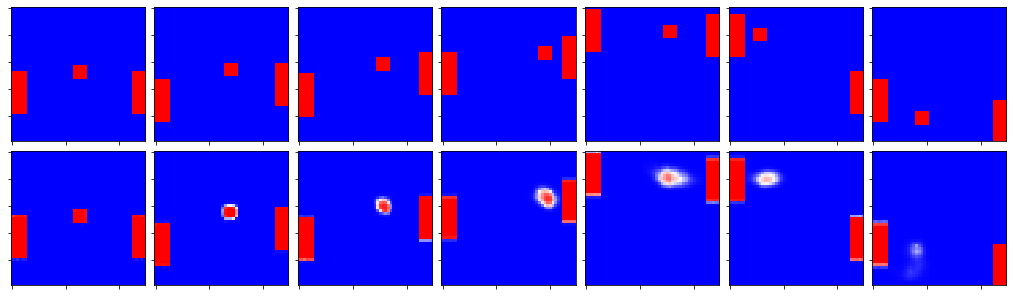

Epoch 114/250
100/100 [==============================] - 110s 1s/step - loss: 0.7026 - frames_loss: 0.0230 - lambda_1_loss: 0.6796 - frames_mean_squared_error: 0.0070 - frames_acc: 0.9904 - lambda_1_mean_squared_error: 373.5213 - lambda_1_acc: 0.9559 - val_loss: 0.8195 - val_frames_loss: 0.0230 - val_lambda_1_loss: 0.7965 - val_frames_mean_squared_error: 0.0070 - val_frames_acc: 0.9904 - val_lambda_1_mean_squared_error: 362.0129 - val_lambda_1_acc: 0.9484


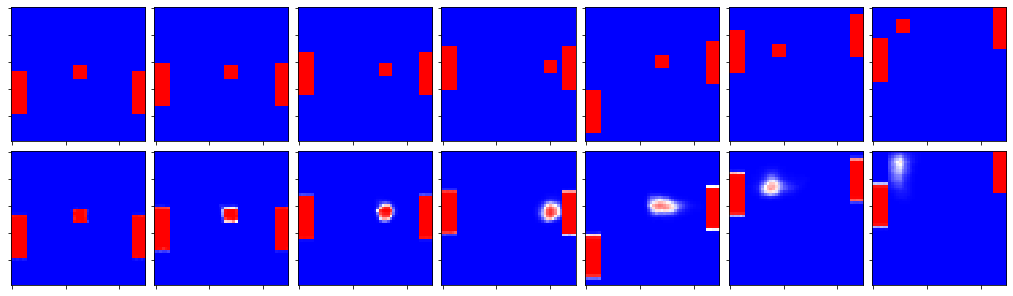

Epoch 115/250
100/100 [==============================] - 110s 1s/step - loss: 0.6556 - frames_loss: 0.0221 - lambda_1_loss: 0.6335 - frames_mean_squared_error: 0.0067 - frames_acc: 0.9907 - lambda_1_mean_squared_error: 370.3188 - lambda_1_acc: 0.9589 - val_loss: 0.8629 - val_frames_loss: 0.0212 - val_lambda_1_loss: 0.8417 - val_frames_mean_squared_error: 0.0064 - val_frames_acc: 0.9912 - val_lambda_1_mean_squared_error: 377.6812 - val_lambda_1_acc: 0.9454


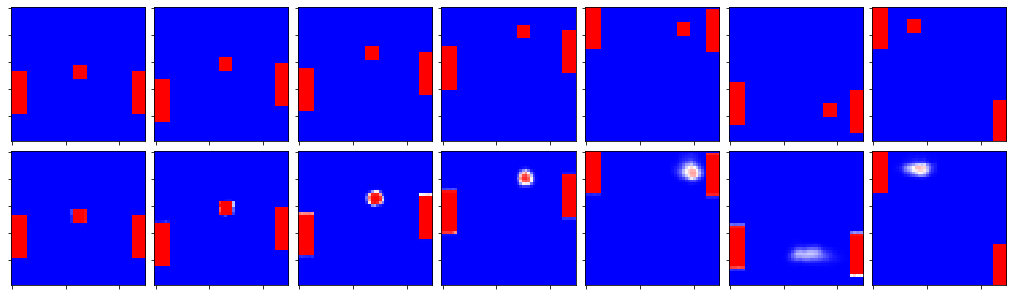

Epoch 116/250
100/100 [==============================] - 110s 1s/step - loss: 0.6533 - frames_loss: 0.0224 - lambda_1_loss: 0.6309 - frames_mean_squared_error: 0.0068 - frames_acc: 0.9905 - lambda_1_mean_squared_error: 376.1321 - lambda_1_acc: 0.9591 - val_loss: 0.6705 - val_frames_loss: 0.0227 - val_lambda_1_loss: 0.6477 - val_frames_mean_squared_error: 0.0069 - val_frames_acc: 0.9905 - val_lambda_1_mean_squared_error: 353.2179 - val_lambda_1_acc: 0.9580


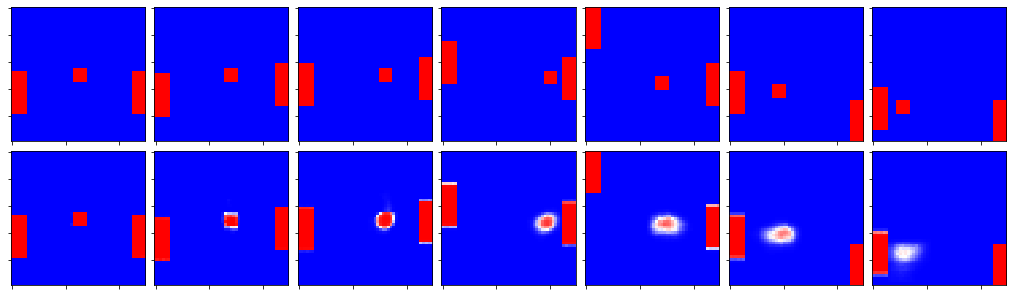

Epoch 117/250
100/100 [==============================] - 111s 1s/step - loss: 0.7154 - frames_loss: 0.0239 - lambda_1_loss: 0.6916 - frames_mean_squared_error: 0.0072 - frames_acc: 0.9900 - lambda_1_mean_squared_error: 335.5750 - lambda_1_acc: 0.9552 - val_loss: 0.7358 - val_frames_loss: 0.0222 - val_lambda_1_loss: 0.7136 - val_frames_mean_squared_error: 0.0068 - val_frames_acc: 0.9905 - val_lambda_1_mean_squared_error: 327.3699 - val_lambda_1_acc: 0.9537


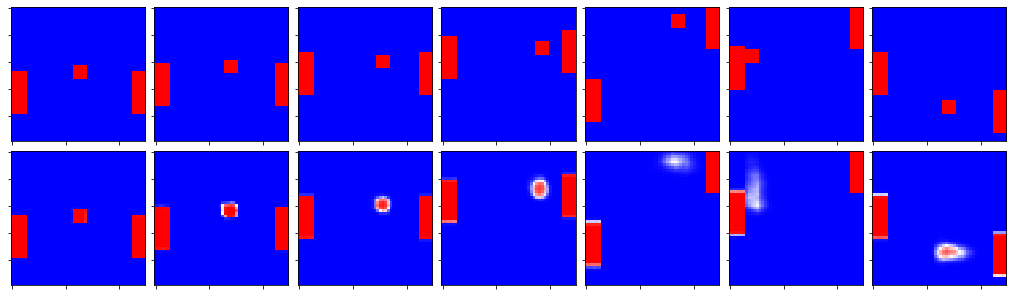

Epoch 118/250
100/100 [==============================] - 110s 1s/step - loss: 0.7103 - frames_loss: 0.0223 - lambda_1_loss: 0.6880 - frames_mean_squared_error: 0.0068 - frames_acc: 0.9906 - lambda_1_mean_squared_error: 338.8713 - lambda_1_acc: 0.9554 - val_loss: 0.8545 - val_frames_loss: 0.0204 - val_lambda_1_loss: 0.8341 - val_frames_mean_squared_error: 0.0062 - val_frames_acc: 0.9914 - val_lambda_1_mean_squared_error: 334.1315 - val_lambda_1_acc: 0.9459


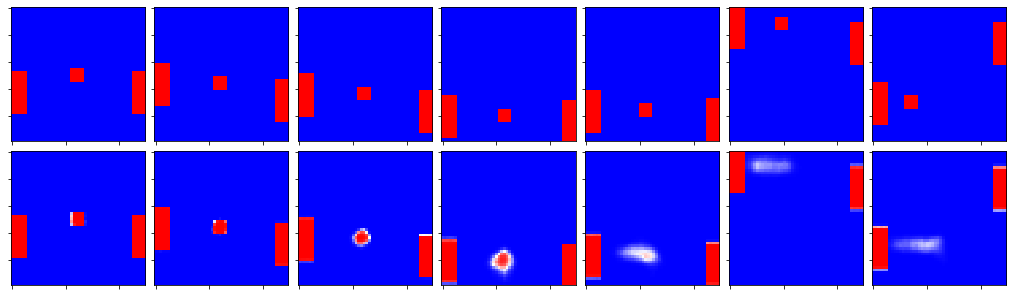

Epoch 119/250
100/100 [==============================] - 111s 1s/step - loss: 0.7289 - frames_loss: 0.0234 - lambda_1_loss: 0.7055 - frames_mean_squared_error: 0.0071 - frames_acc: 0.9903 - lambda_1_mean_squared_error: 320.1990 - lambda_1_acc: 0.9543 - val_loss: 0.5537 - val_frames_loss: 0.0208 - val_lambda_1_loss: 0.5329 - val_frames_mean_squared_error: 0.0063 - val_frames_acc: 0.9913 - val_lambda_1_mean_squared_error: 337.0400 - val_lambda_1_acc: 0.9655


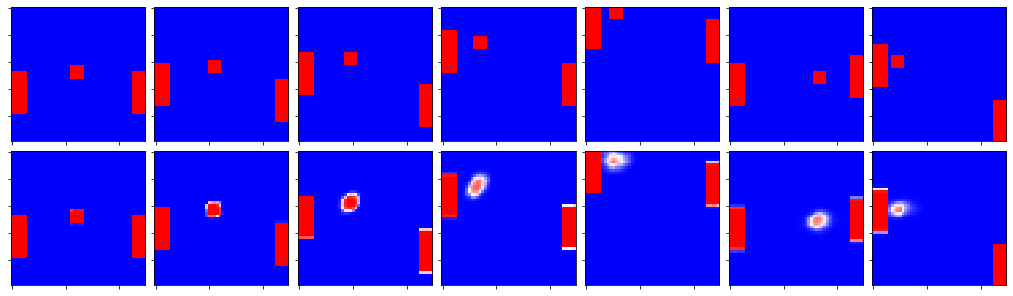

Epoch 120/250
100/100 [==============================] - 111s 1s/step - loss: 0.6660 - frames_loss: 0.0227 - lambda_1_loss: 0.6433 - frames_mean_squared_error: 0.0069 - frames_acc: 0.9904 - lambda_1_mean_squared_error: 330.4736 - lambda_1_acc: 0.9583 - val_loss: 0.3280 - val_frames_loss: 0.0249 - val_lambda_1_loss: 0.3032 - val_frames_mean_squared_error: 0.0075 - val_frames_acc: 0.9896 - val_lambda_1_mean_squared_error: 365.6164 - val_lambda_1_acc: 0.9803


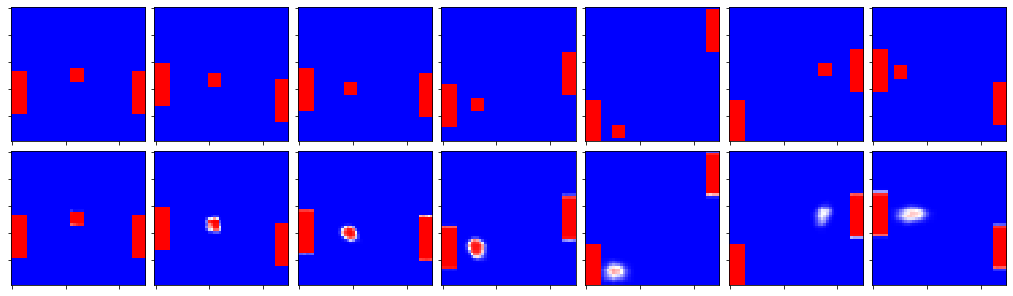

Epoch 121/250
100/100 [==============================] - 111s 1s/step - loss: 0.7639 - frames_loss: 0.0235 - lambda_1_loss: 0.7404 - frames_mean_squared_error: 0.0070 - frames_acc: 0.9903 - lambda_1_mean_squared_error: 306.9657 - lambda_1_acc: 0.9520 - val_loss: 0.9330 - val_frames_loss: 0.0216 - val_lambda_1_loss: 0.9113 - val_frames_mean_squared_error: 0.0065 - val_frames_acc: 0.9910 - val_lambda_1_mean_squared_error: 321.2230 - val_lambda_1_acc: 0.9409


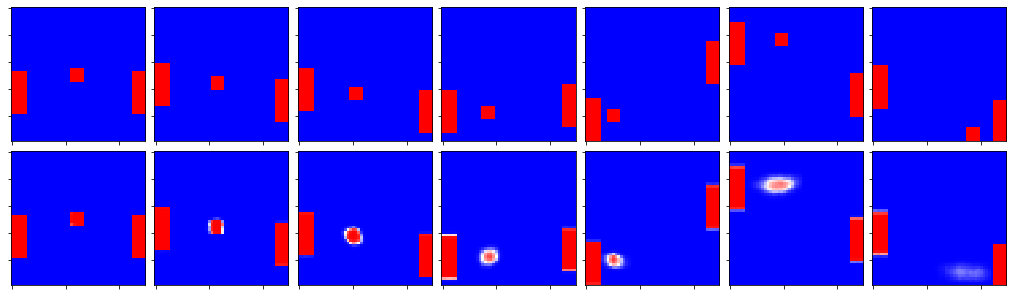

Epoch 122/250
100/100 [==============================] - 110s 1s/step - loss: 0.7257 - frames_loss: 0.0207 - lambda_1_loss: 0.7050 - frames_mean_squared_error: 0.0063 - frames_acc: 0.9913 - lambda_1_mean_squared_error: 342.3070 - lambda_1_acc: 0.9543 - val_loss: 0.2968 - val_frames_loss: 0.0200 - val_lambda_1_loss: 0.2768 - val_frames_mean_squared_error: 0.0061 - val_frames_acc: 0.9914 - val_lambda_1_mean_squared_error: 354.9380 - val_lambda_1_acc: 0.9821


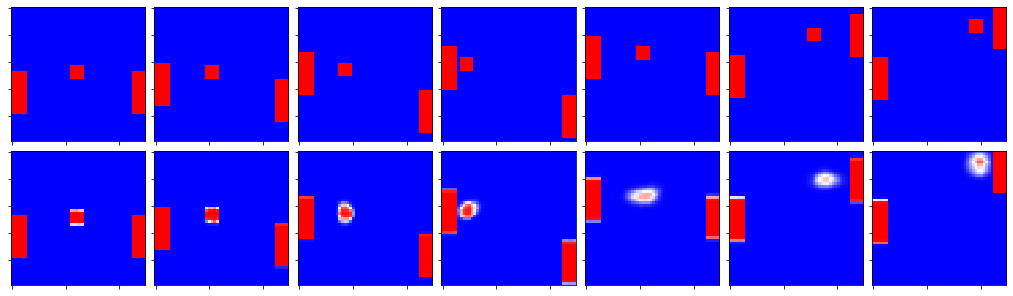

Epoch 123/250
100/100 [==============================] - 111s 1s/step - loss: 0.7734 - frames_loss: 0.0242 - lambda_1_loss: 0.7492 - frames_mean_squared_error: 0.0072 - frames_acc: 0.9902 - lambda_1_mean_squared_error: 287.6819 - lambda_1_acc: 0.9514 - val_loss: 0.5131 - val_frames_loss: 0.0217 - val_lambda_1_loss: 0.4914 - val_frames_mean_squared_error: 0.0066 - val_frames_acc: 0.9909 - val_lambda_1_mean_squared_error: 320.1854 - val_lambda_1_acc: 0.9681


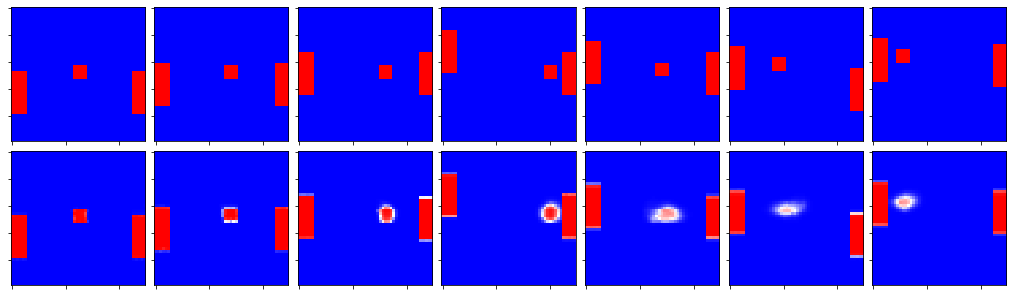

Epoch 124/250
100/100 [==============================] - 110s 1s/step - loss: 0.6941 - frames_loss: 0.0219 - lambda_1_loss: 0.6721 - frames_mean_squared_error: 0.0067 - frames_acc: 0.9908 - lambda_1_mean_squared_error: 316.7342 - lambda_1_acc: 0.9564 - val_loss: 0.7753 - val_frames_loss: 0.0203 - val_lambda_1_loss: 0.7551 - val_frames_mean_squared_error: 0.0061 - val_frames_acc: 0.9915 - val_lambda_1_mean_squared_error: 326.8513 - val_lambda_1_acc: 0.9510


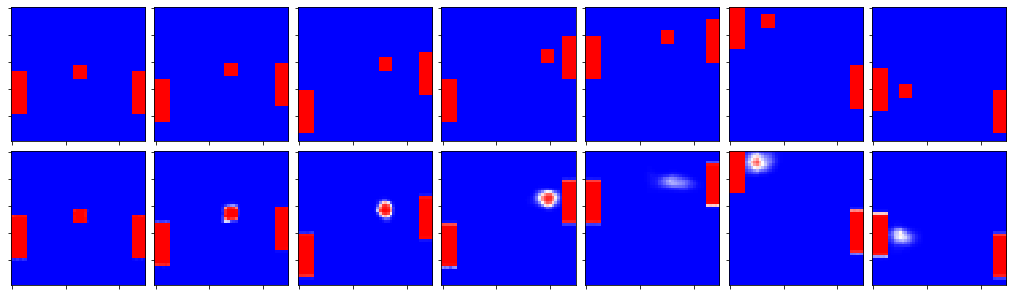

Epoch 125/250
100/100 [==============================] - 111s 1s/step - loss: 0.7189 - frames_loss: 0.0210 - lambda_1_loss: 0.6979 - frames_mean_squared_error: 0.0064 - frames_acc: 0.9911 - lambda_1_mean_squared_error: 339.2263 - lambda_1_acc: 0.9548 - val_loss: 1.3006 - val_frames_loss: 0.0221 - val_lambda_1_loss: 1.2785 - val_frames_mean_squared_error: 0.0069 - val_frames_acc: 0.9903 - val_lambda_1_mean_squared_error: 328.1786 - val_lambda_1_acc: 0.9171


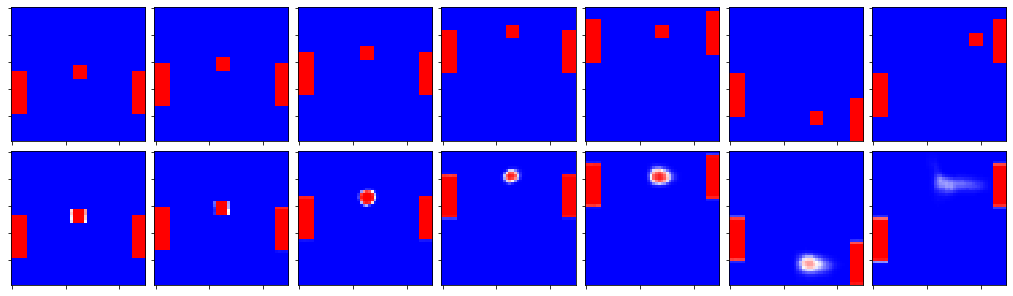

Epoch 126/250
100/100 [==============================] - 110s 1s/step - loss: 0.7391 - frames_loss: 0.0211 - lambda_1_loss: 0.7180 - frames_mean_squared_error: 0.0064 - frames_acc: 0.9911 - lambda_1_mean_squared_error: 336.8970 - lambda_1_acc: 0.9535 - val_loss: 0.6307 - val_frames_loss: 0.0207 - val_lambda_1_loss: 0.6101 - val_frames_mean_squared_error: 0.0063 - val_frames_acc: 0.9912 - val_lambda_1_mean_squared_error: 320.8913 - val_lambda_1_acc: 0.9604


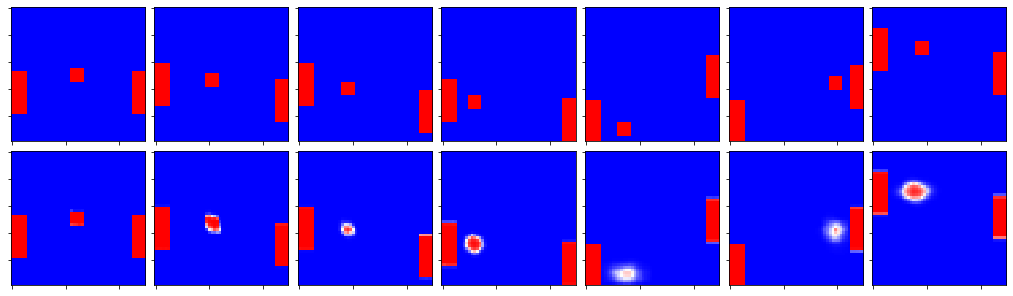

Epoch 127/250
100/100 [==============================] - 111s 1s/step - loss: 0.7584 - frames_loss: 0.0215 - lambda_1_loss: 0.7369 - frames_mean_squared_error: 0.0065 - frames_acc: 0.9909 - lambda_1_mean_squared_error: 321.2335 - lambda_1_acc: 0.9522 - val_loss: 0.9556 - val_frames_loss: 0.0197 - val_lambda_1_loss: 0.9358 - val_frames_mean_squared_error: 0.0061 - val_frames_acc: 0.9915 - val_lambda_1_mean_squared_error: 333.9529 - val_lambda_1_acc: 0.9393


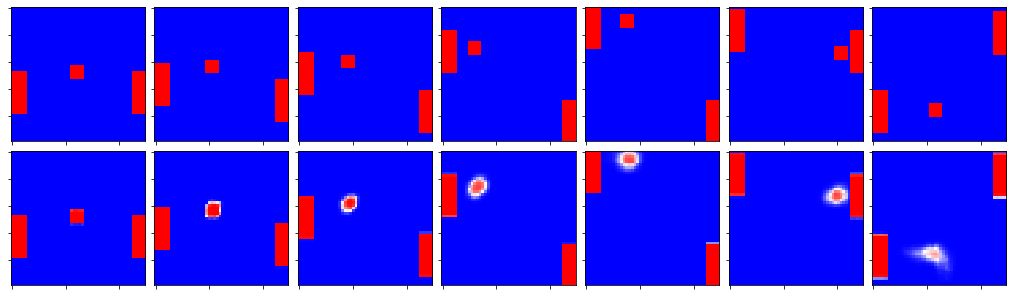

Epoch 128/250
100/100 [==============================] - 111s 1s/step - loss: 0.7279 - frames_loss: 0.0207 - lambda_1_loss: 0.7072 - frames_mean_squared_error: 0.0063 - frames_acc: 0.9912 - lambda_1_mean_squared_error: 340.6115 - lambda_1_acc: 0.9542 - val_loss: 0.4819 - val_frames_loss: 0.0243 - val_lambda_1_loss: 0.4576 - val_frames_mean_squared_error: 0.0073 - val_frames_acc: 0.9899 - val_lambda_1_mean_squared_error: 291.8610 - val_lambda_1_acc: 0.9703


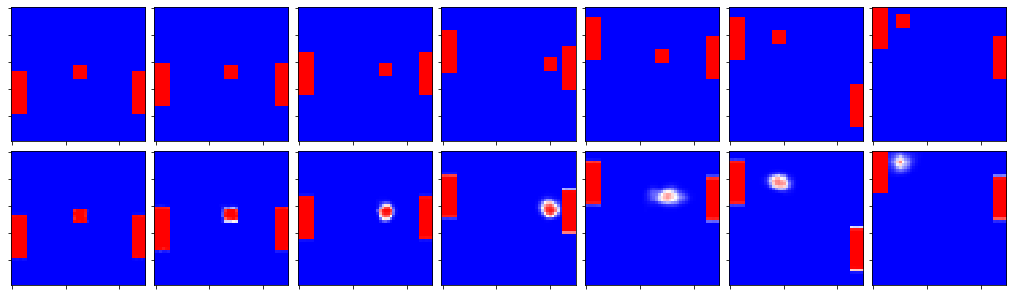

Epoch 129/250
100/100 [==============================] - 111s 1s/step - loss: 0.6869 - frames_loss: 0.0210 - lambda_1_loss: 0.6658 - frames_mean_squared_error: 0.0064 - frames_acc: 0.9910 - lambda_1_mean_squared_error: 328.0721 - lambda_1_acc: 0.9568 - val_loss: 0.5590 - val_frames_loss: 0.0243 - val_lambda_1_loss: 0.5348 - val_frames_mean_squared_error: 0.0074 - val_frames_acc: 0.9896 - val_lambda_1_mean_squared_error: 331.8401 - val_lambda_1_acc: 0.9653


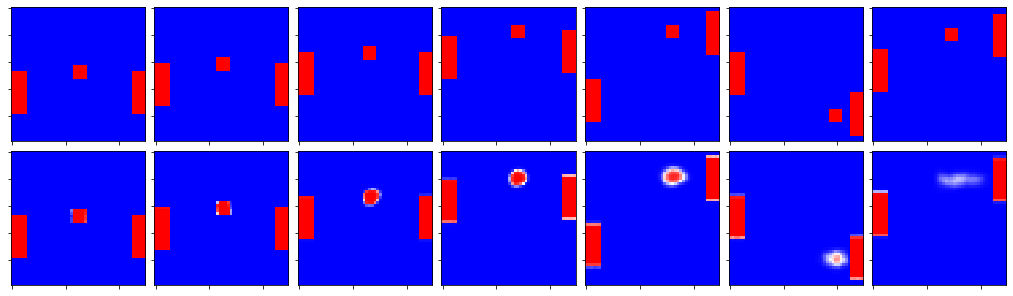

Epoch 130/250
100/100 [==============================] - 110s 1s/step - loss: 0.7059 - frames_loss: 0.0225 - lambda_1_loss: 0.6833 - frames_mean_squared_error: 0.0068 - frames_acc: 0.9906 - lambda_1_mean_squared_error: 294.9716 - lambda_1_acc: 0.9557 - val_loss: 0.9452 - val_frames_loss: 0.0207 - val_lambda_1_loss: 0.9245 - val_frames_mean_squared_error: 0.0063 - val_frames_acc: 0.9911 - val_lambda_1_mean_squared_error: 297.2746 - val_lambda_1_acc: 0.9401


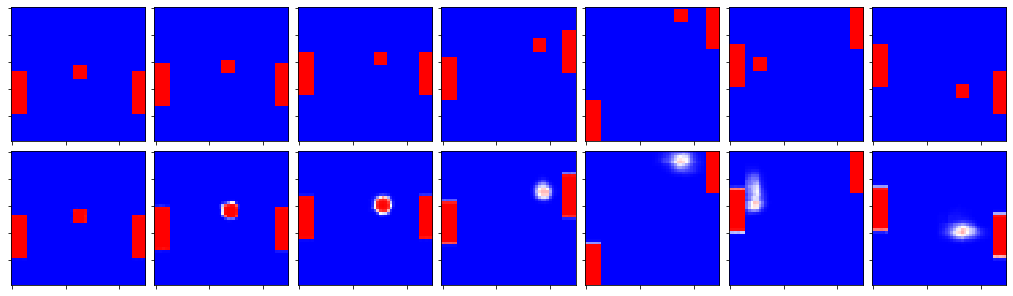

Epoch 131/250
100/100 [==============================] - 111s 1s/step - loss: 0.7073 - frames_loss: 0.0194 - lambda_1_loss: 0.6879 - frames_mean_squared_error: 0.0059 - frames_acc: 0.9918 - lambda_1_mean_squared_error: 328.6437 - lambda_1_acc: 0.9554 - val_loss: 0.2435 - val_frames_loss: 0.0194 - val_lambda_1_loss: 0.2241 - val_frames_mean_squared_error: 0.0059 - val_frames_acc: 0.9918 - val_lambda_1_mean_squared_error: 353.9585 - val_lambda_1_acc: 0.9855


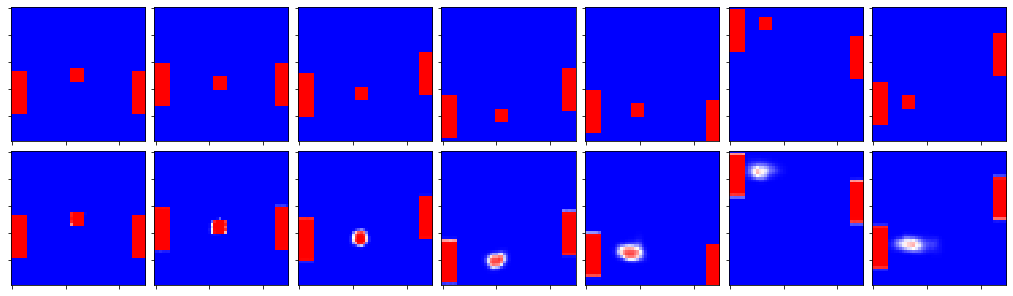

Epoch 132/250
100/100 [==============================] - 111s 1s/step - loss: 0.6588 - frames_loss: 0.0212 - lambda_1_loss: 0.6376 - frames_mean_squared_error: 0.0065 - frames_acc: 0.9910 - lambda_1_mean_squared_error: 319.0840 - lambda_1_acc: 0.9587 - val_loss: 0.8610 - val_frames_loss: 0.0193 - val_lambda_1_loss: 0.8417 - val_frames_mean_squared_error: 0.0059 - val_frames_acc: 0.9917 - val_lambda_1_mean_squared_error: 316.1786 - val_lambda_1_acc: 0.9454


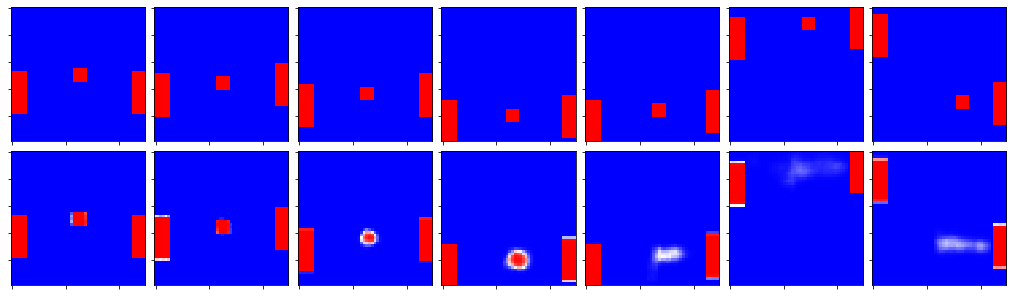

Epoch 133/250
100/100 [==============================] - 111s 1s/step - loss: 0.6539 - frames_loss: 0.0197 - lambda_1_loss: 0.6342 - frames_mean_squared_error: 0.0060 - frames_acc: 0.9916 - lambda_1_mean_squared_error: 326.7770 - lambda_1_acc: 0.9589 - val_loss: 0.3381 - val_frames_loss: 0.0180 - val_lambda_1_loss: 0.3201 - val_frames_mean_squared_error: 0.0055 - val_frames_acc: 0.9923 - val_lambda_1_mean_squared_error: 340.2285 - val_lambda_1_acc: 0.9792


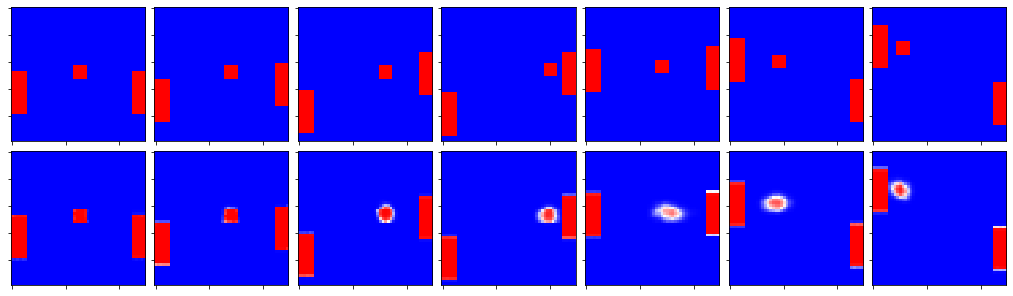

Epoch 134/250
100/100 [==============================] - 111s 1s/step - loss: 0.7411 - frames_loss: 0.0194 - lambda_1_loss: 0.7217 - frames_mean_squared_error: 0.0059 - frames_acc: 0.9917 - lambda_1_mean_squared_error: 340.9304 - lambda_1_acc: 0.9532 - val_loss: 0.8390 - val_frames_loss: 0.0199 - val_lambda_1_loss: 0.8191 - val_frames_mean_squared_error: 0.0062 - val_frames_acc: 0.9913 - val_lambda_1_mean_squared_error: 363.4256 - val_lambda_1_acc: 0.9469


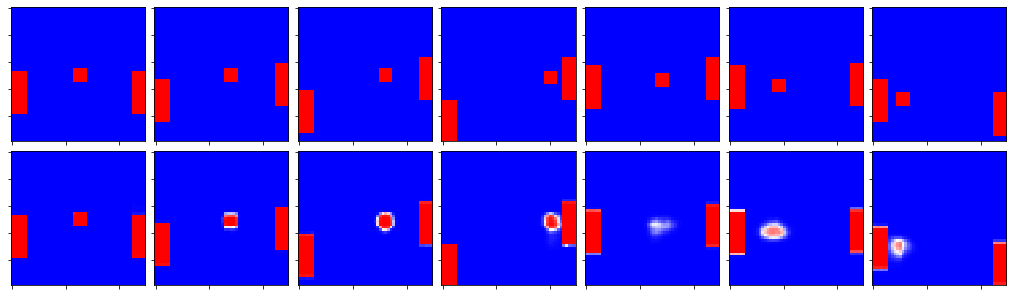

Epoch 135/250
100/100 [==============================] - 110s 1s/step - loss: 0.7094 - frames_loss: 0.0235 - lambda_1_loss: 0.6859 - frames_mean_squared_error: 0.0069 - frames_acc: 0.9905 - lambda_1_mean_squared_error: 272.2101 - lambda_1_acc: 0.9555 - val_loss: 0.6979 - val_frames_loss: 0.0201 - val_lambda_1_loss: 0.6779 - val_frames_mean_squared_error: 0.0061 - val_frames_acc: 0.9915 - val_lambda_1_mean_squared_error: 293.5945 - val_lambda_1_acc: 0.9561


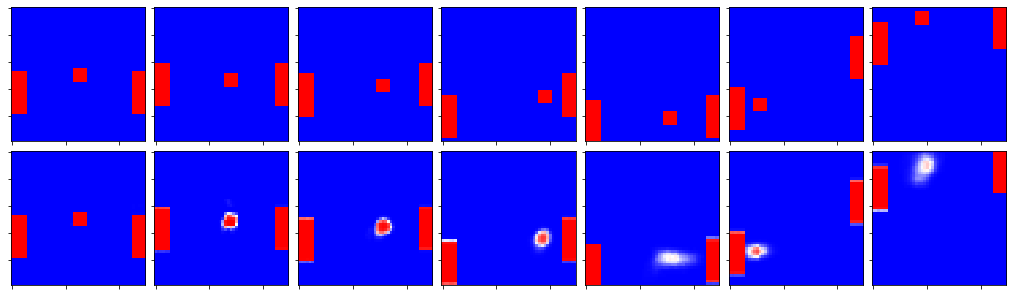

Epoch 136/250
100/100 [==============================] - 111s 1s/step - loss: 0.7122 - frames_loss: 0.0197 - lambda_1_loss: 0.6925 - frames_mean_squared_error: 0.0060 - frames_acc: 0.9916 - lambda_1_mean_squared_error: 317.4194 - lambda_1_acc: 0.9551 - val_loss: 1.3909 - val_frames_loss: 0.0201 - val_lambda_1_loss: 1.3708 - val_frames_mean_squared_error: 0.0062 - val_frames_acc: 0.9913 - val_lambda_1_mean_squared_error: 304.5387 - val_lambda_1_acc: 0.9111


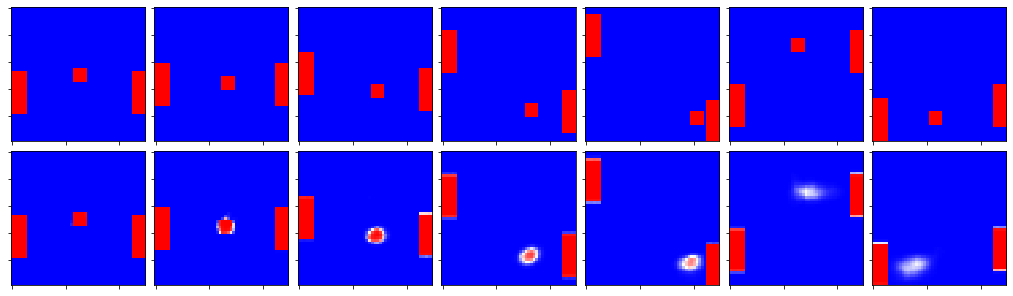

Epoch 137/250
100/100 [==============================] - 111s 1s/step - loss: 0.7487 - frames_loss: 0.0193 - lambda_1_loss: 0.7294 - frames_mean_squared_error: 0.0059 - frames_acc: 0.9918 - lambda_1_mean_squared_error: 315.9122 - lambda_1_acc: 0.9527 - val_loss: 1.0277 - val_frames_loss: 0.0185 - val_lambda_1_loss: 1.0092 - val_frames_mean_squared_error: 0.0056 - val_frames_acc: 0.9921 - val_lambda_1_mean_squared_error: 324.1777 - val_lambda_1_acc: 0.9346


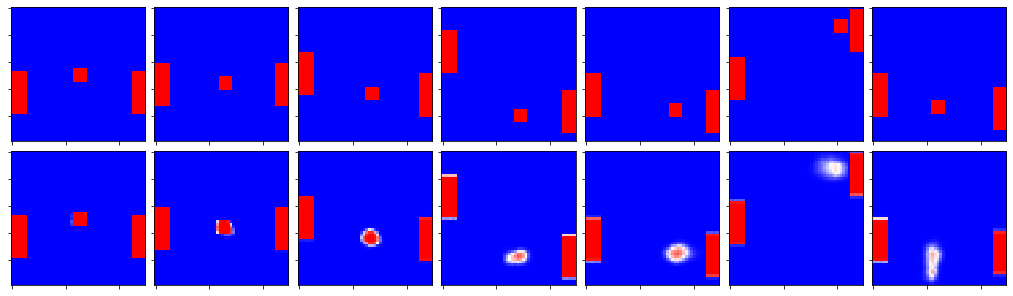

Epoch 138/250
100/100 [==============================] - 111s 1s/step - loss: 0.7184 - frames_loss: 0.0199 - lambda_1_loss: 0.6986 - frames_mean_squared_error: 0.0061 - frames_acc: 0.9915 - lambda_1_mean_squared_error: 318.6681 - lambda_1_acc: 0.9547 - val_loss: 0.5425 - val_frames_loss: 0.0209 - val_lambda_1_loss: 0.5216 - val_frames_mean_squared_error: 0.0065 - val_frames_acc: 0.9909 - val_lambda_1_mean_squared_error: 315.1263 - val_lambda_1_acc: 0.9662


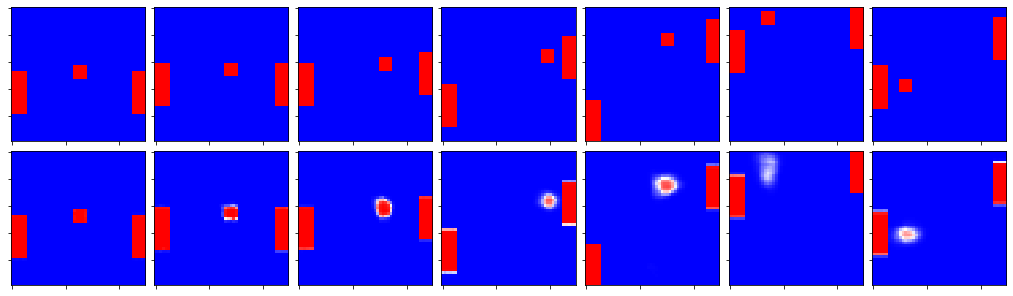

Epoch 139/250
100/100 [==============================] - 111s 1s/step - loss: 0.6519 - frames_loss: 0.0203 - lambda_1_loss: 0.6315 - frames_mean_squared_error: 0.0062 - frames_acc: 0.9914 - lambda_1_mean_squared_error: 290.9206 - lambda_1_acc: 0.9591 - val_loss: 0.7964 - val_frames_loss: 0.0188 - val_lambda_1_loss: 0.7776 - val_frames_mean_squared_error: 0.0058 - val_frames_acc: 0.9918 - val_lambda_1_mean_squared_error: 299.8875 - val_lambda_1_acc: 0.9496


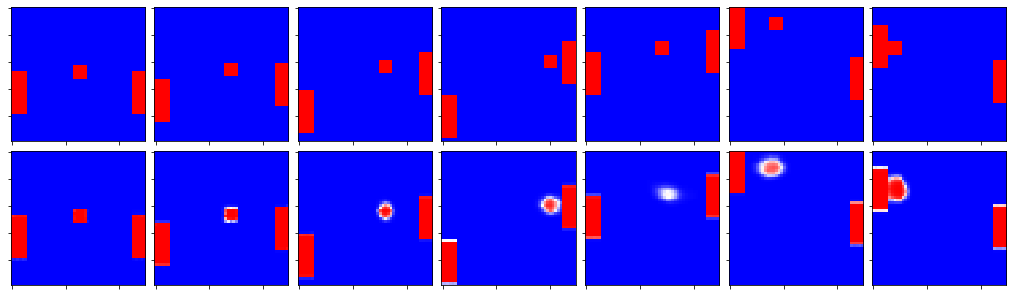

Epoch 140/250
100/100 [==============================] - 111s 1s/step - loss: 0.7030 - frames_loss: 0.0213 - lambda_1_loss: 0.6818 - frames_mean_squared_error: 0.0065 - frames_acc: 0.9909 - lambda_1_mean_squared_error: 285.9110 - lambda_1_acc: 0.9558 - val_loss: 0.9923 - val_frames_loss: 0.0207 - val_lambda_1_loss: 0.9716 - val_frames_mean_squared_error: 0.0063 - val_frames_acc: 0.9913 - val_lambda_1_mean_squared_error: 297.3140 - val_lambda_1_acc: 0.9370


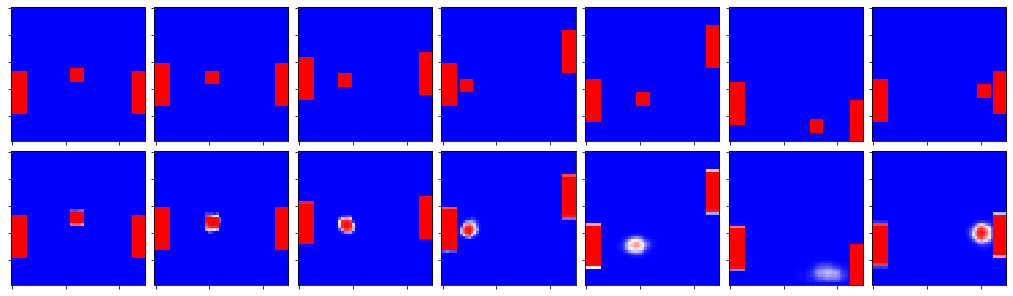

Epoch 141/250
100/100 [==============================] - 111s 1s/step - loss: 0.6613 - frames_loss: 0.0197 - lambda_1_loss: 0.6416 - frames_mean_squared_error: 0.0060 - frames_acc: 0.9915 - lambda_1_mean_squared_error: 296.0680 - lambda_1_acc: 0.9584 - val_loss: 1.2206 - val_frames_loss: 0.0193 - val_lambda_1_loss: 1.2013 - val_frames_mean_squared_error: 0.0059 - val_frames_acc: 0.9917 - val_lambda_1_mean_squared_error: 306.9844 - val_lambda_1_acc: 0.9221


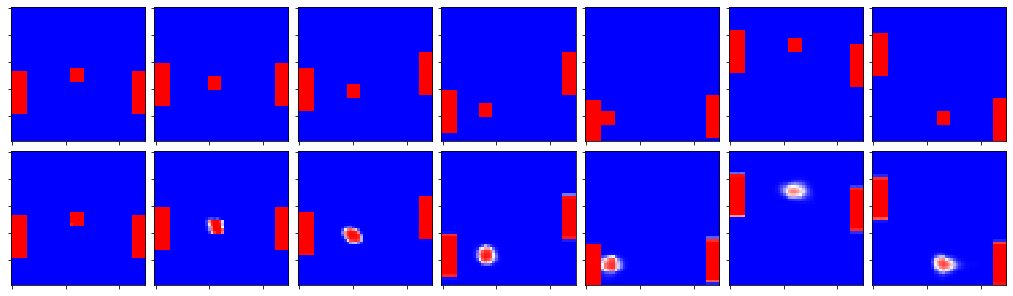

Epoch 142/250
100/100 [==============================] - 110s 1s/step - loss: 0.7266 - frames_loss: 0.0193 - lambda_1_loss: 0.7074 - frames_mean_squared_error: 0.0059 - frames_acc: 0.9917 - lambda_1_mean_squared_error: 304.3417 - lambda_1_acc: 0.9541 - val_loss: 1.2208 - val_frames_loss: 0.0195 - val_lambda_1_loss: 1.2013 - val_frames_mean_squared_error: 0.0060 - val_frames_acc: 0.9915 - val_lambda_1_mean_squared_error: 302.9402 - val_lambda_1_acc: 0.9221


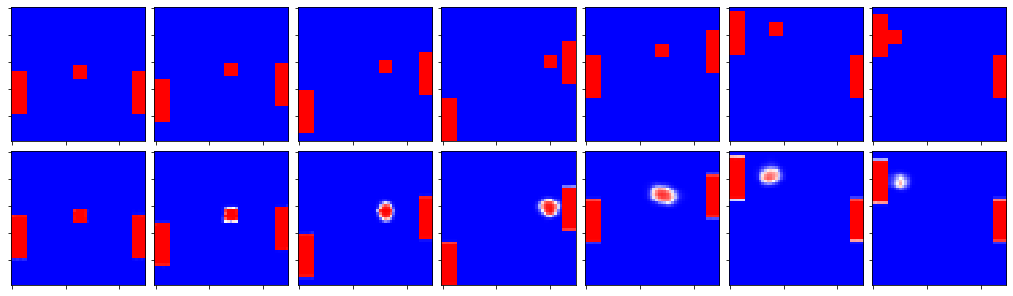

Epoch 143/250
100/100 [==============================] - 110s 1s/step - loss: 0.6400 - frames_loss: 0.0205 - lambda_1_loss: 0.6196 - frames_mean_squared_error: 0.0063 - frames_acc: 0.9912 - lambda_1_mean_squared_error: 290.7361 - lambda_1_acc: 0.9598 - val_loss: 0.9150 - val_frames_loss: 0.0188 - val_lambda_1_loss: 0.8963 - val_frames_mean_squared_error: 0.0057 - val_frames_acc: 0.9919 - val_lambda_1_mean_squared_error: 278.8789 - val_lambda_1_acc: 0.9419


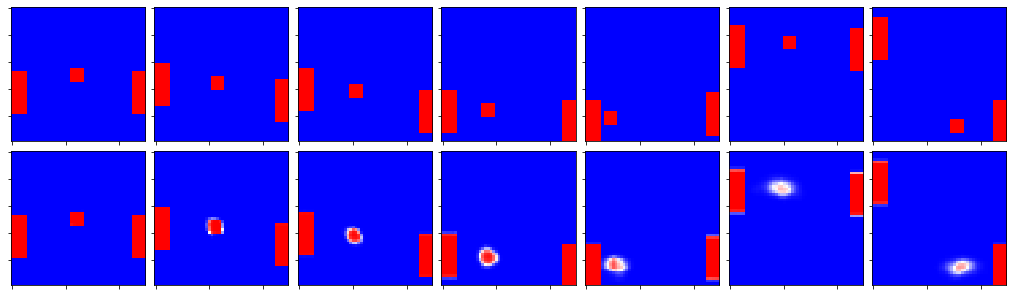

Epoch 144/250
100/100 [==============================] - 111s 1s/step - loss: 0.7650 - frames_loss: 0.0193 - lambda_1_loss: 0.7457 - frames_mean_squared_error: 0.0059 - frames_acc: 0.9917 - lambda_1_mean_squared_error: 283.4800 - lambda_1_acc: 0.9517 - val_loss: 0.6891 - val_frames_loss: 0.0188 - val_lambda_1_loss: 0.6703 - val_frames_mean_squared_error: 0.0057 - val_frames_acc: 0.9920 - val_lambda_1_mean_squared_error: 306.8756 - val_lambda_1_acc: 0.9565


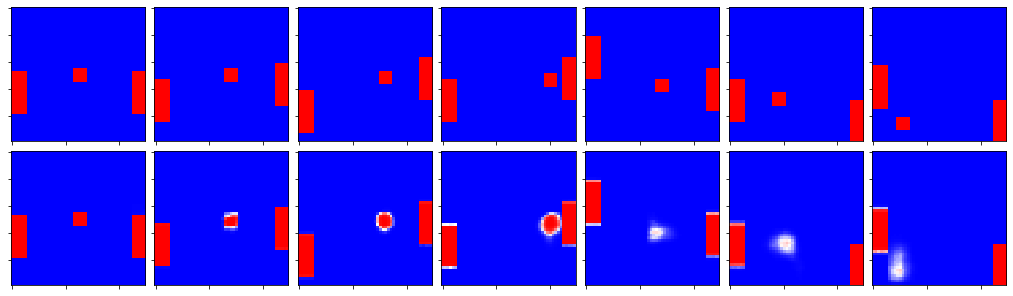

Epoch 145/250
100/100 [==============================] - 111s 1s/step - loss: 0.6959 - frames_loss: 0.0185 - lambda_1_loss: 0.6773 - frames_mean_squared_error: 0.0057 - frames_acc: 0.9921 - lambda_1_mean_squared_error: 307.5990 - lambda_1_acc: 0.9561 - val_loss: 0.5337 - val_frames_loss: 0.0196 - val_lambda_1_loss: 0.5140 - val_frames_mean_squared_error: 0.0061 - val_frames_acc: 0.9914 - val_lambda_1_mean_squared_error: 296.7416 - val_lambda_1_acc: 0.9667


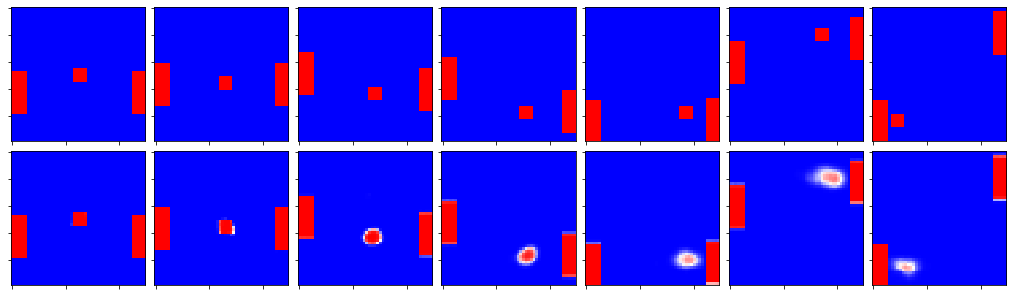

Epoch 146/250
100/100 [==============================] - 111s 1s/step - loss: 0.5942 - frames_loss: 0.0190 - lambda_1_loss: 0.5752 - frames_mean_squared_error: 0.0058 - frames_acc: 0.9919 - lambda_1_mean_squared_error: 290.0702 - lambda_1_acc: 0.9627 - val_loss: 1.0029 - val_frames_loss: 0.0181 - val_lambda_1_loss: 0.9848 - val_frames_mean_squared_error: 0.0055 - val_frames_acc: 0.9923 - val_lambda_1_mean_squared_error: 329.1428 - val_lambda_1_acc: 0.9362


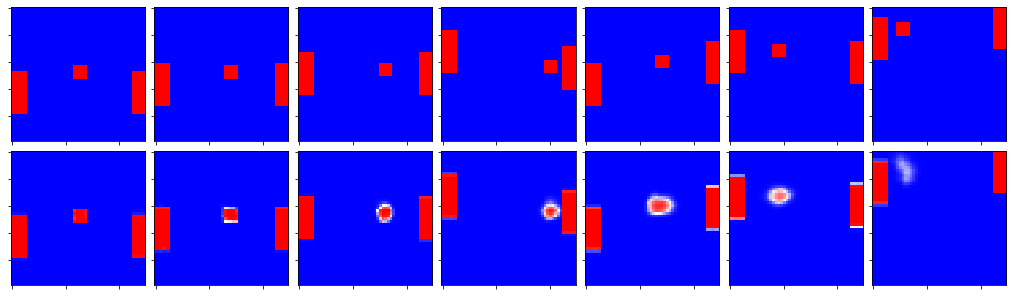

Epoch 147/250
100/100 [==============================] - 111s 1s/step - loss: 0.6356 - frames_loss: 0.0193 - lambda_1_loss: 0.6164 - frames_mean_squared_error: 0.0059 - frames_acc: 0.9917 - lambda_1_mean_squared_error: 298.1684 - lambda_1_acc: 0.9600 - val_loss: 0.9783 - val_frames_loss: 0.0180 - val_lambda_1_loss: 0.9603 - val_frames_mean_squared_error: 0.0055 - val_frames_acc: 0.9923 - val_lambda_1_mean_squared_error: 285.2484 - val_lambda_1_acc: 0.9377


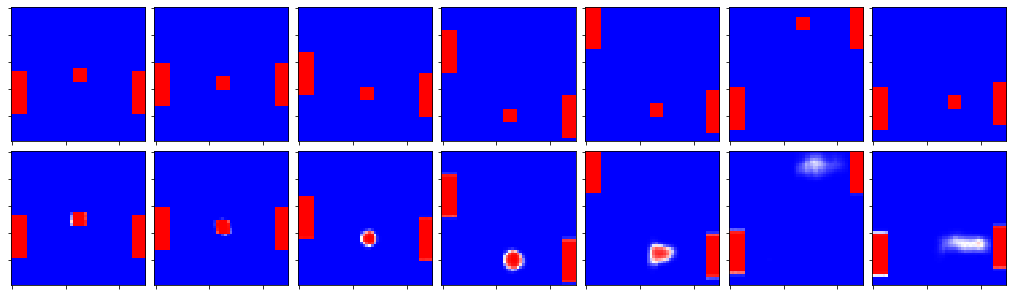

Epoch 148/250
100/100 [==============================] - 111s 1s/step - loss: 0.7310 - frames_loss: 0.0188 - lambda_1_loss: 0.7122 - frames_mean_squared_error: 0.0057 - frames_acc: 0.9919 - lambda_1_mean_squared_error: 297.4214 - lambda_1_acc: 0.9538 - val_loss: 0.8744 - val_frames_loss: 0.0177 - val_lambda_1_loss: 0.8567 - val_frames_mean_squared_error: 0.0054 - val_frames_acc: 0.9924 - val_lambda_1_mean_squared_error: 273.7366 - val_lambda_1_acc: 0.9445


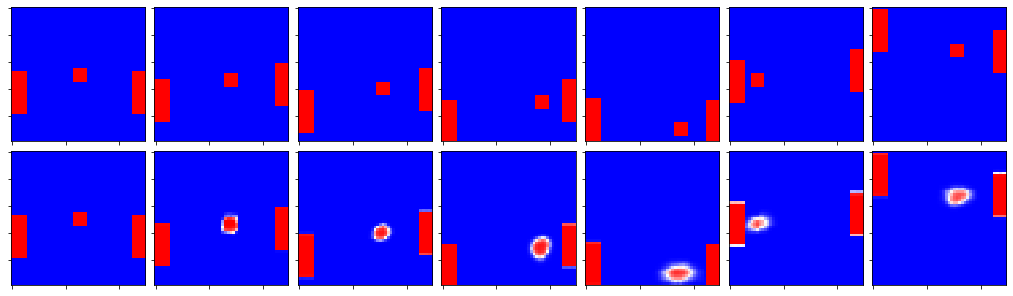

Epoch 149/250
100/100 [==============================] - 111s 1s/step - loss: 0.6968 - frames_loss: 0.0176 - lambda_1_loss: 0.6792 - frames_mean_squared_error: 0.0054 - frames_acc: 0.9924 - lambda_1_mean_squared_error: 307.1978 - lambda_1_acc: 0.9560 - val_loss: 0.6874 - val_frames_loss: 0.0190 - val_lambda_1_loss: 0.6684 - val_frames_mean_squared_error: 0.0059 - val_frames_acc: 0.9917 - val_lambda_1_mean_squared_error: 328.0675 - val_lambda_1_acc: 0.9567


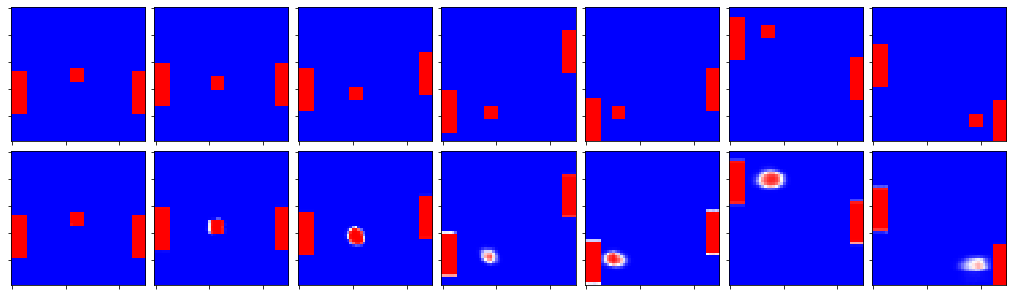

Epoch 150/250
100/100 [==============================] - 111s 1s/step - loss: 0.6941 - frames_loss: 0.0183 - lambda_1_loss: 0.6758 - frames_mean_squared_error: 0.0056 - frames_acc: 0.9921 - lambda_1_mean_squared_error: 300.5339 - lambda_1_acc: 0.9562 - val_loss: 0.9226 - val_frames_loss: 0.0188 - val_lambda_1_loss: 0.9038 - val_frames_mean_squared_error: 0.0058 - val_frames_acc: 0.9918 - val_lambda_1_mean_squared_error: 306.7740 - val_lambda_1_acc: 0.9414


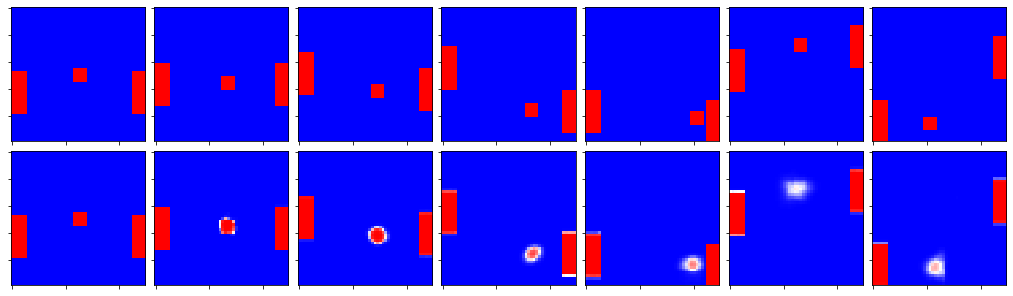

Epoch 151/250
100/100 [==============================] - 111s 1s/step - loss: 0.6580 - frames_loss: 0.0175 - lambda_1_loss: 0.6405 - frames_mean_squared_error: 0.0053 - frames_acc: 0.9925 - lambda_1_mean_squared_error: 317.0173 - lambda_1_acc: 0.9585 - val_loss: 1.0684 - val_frames_loss: 0.0177 - val_lambda_1_loss: 1.0507 - val_frames_mean_squared_error: 0.0054 - val_frames_acc: 0.9924 - val_lambda_1_mean_squared_error: 304.8402 - val_lambda_1_acc: 0.9319


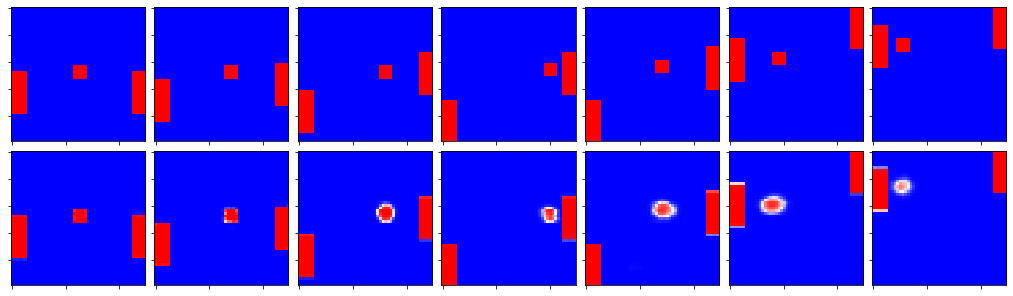

Epoch 152/250
100/100 [==============================] - 111s 1s/step - loss: 0.7083 - frames_loss: 0.0206 - lambda_1_loss: 0.6877 - frames_mean_squared_error: 0.0062 - frames_acc: 0.9913 - lambda_1_mean_squared_error: 290.2585 - lambda_1_acc: 0.9554 - val_loss: 0.7779 - val_frames_loss: 0.0209 - val_lambda_1_loss: 0.7569 - val_frames_mean_squared_error: 0.0064 - val_frames_acc: 0.9909 - val_lambda_1_mean_squared_error: 258.3167 - val_lambda_1_acc: 0.9509


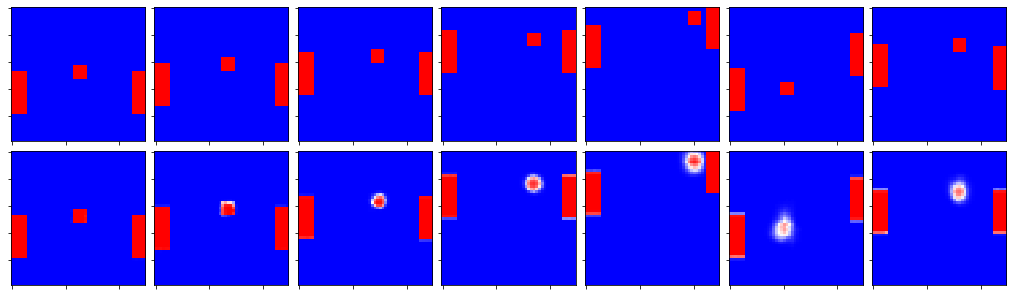

Epoch 153/250
100/100 [==============================] - 111s 1s/step - loss: 0.7069 - frames_loss: 0.0183 - lambda_1_loss: 0.6886 - frames_mean_squared_error: 0.0056 - frames_acc: 0.9921 - lambda_1_mean_squared_error: 270.4511 - lambda_1_acc: 0.9554 - val_loss: 0.7969 - val_frames_loss: 0.0173 - val_lambda_1_loss: 0.7795 - val_frames_mean_squared_error: 0.0053 - val_frames_acc: 0.9926 - val_lambda_1_mean_squared_error: 278.7482 - val_lambda_1_acc: 0.9495


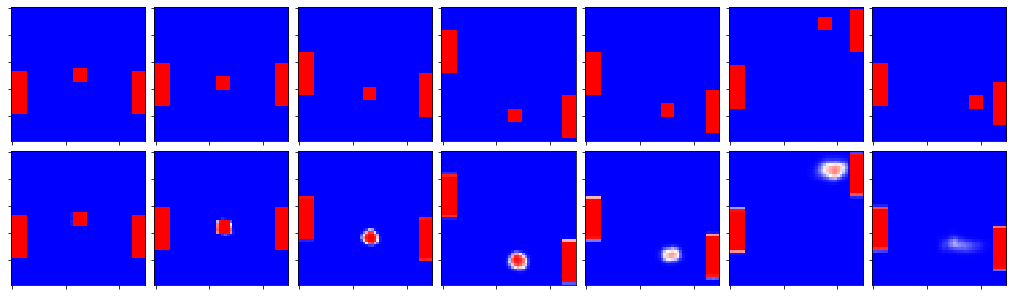

Epoch 154/250
100/100 [==============================] - 111s 1s/step - loss: 0.7769 - frames_loss: 0.0193 - lambda_1_loss: 0.7576 - frames_mean_squared_error: 0.0058 - frames_acc: 0.9918 - lambda_1_mean_squared_error: 275.5484 - lambda_1_acc: 0.9509 - val_loss: 1.1124 - val_frames_loss: 0.0165 - val_lambda_1_loss: 1.0959 - val_frames_mean_squared_error: 0.0050 - val_frames_acc: 0.9930 - val_lambda_1_mean_squared_error: 279.4976 - val_lambda_1_acc: 0.9290


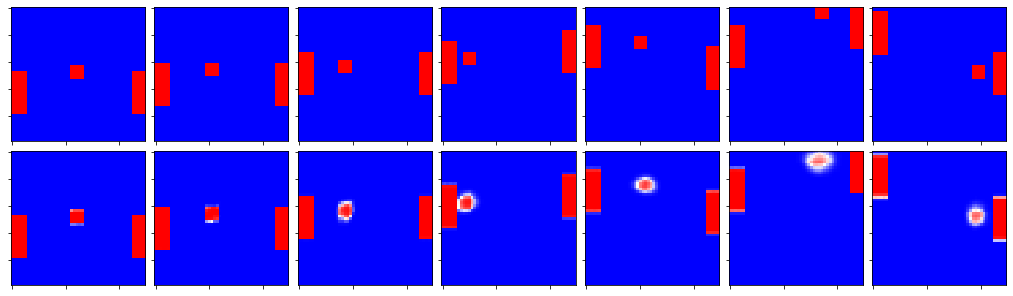

Epoch 155/250
100/100 [==============================] - 111s 1s/step - loss: 0.7520 - frames_loss: 0.0170 - lambda_1_loss: 0.7349 - frames_mean_squared_error: 0.0052 - frames_acc: 0.9927 - lambda_1_mean_squared_error: 294.7154 - lambda_1_acc: 0.9524 - val_loss: 0.8467 - val_frames_loss: 0.0163 - val_lambda_1_loss: 0.8304 - val_frames_mean_squared_error: 0.0050 - val_frames_acc: 0.9931 - val_lambda_1_mean_squared_error: 326.2684 - val_lambda_1_acc: 0.9462


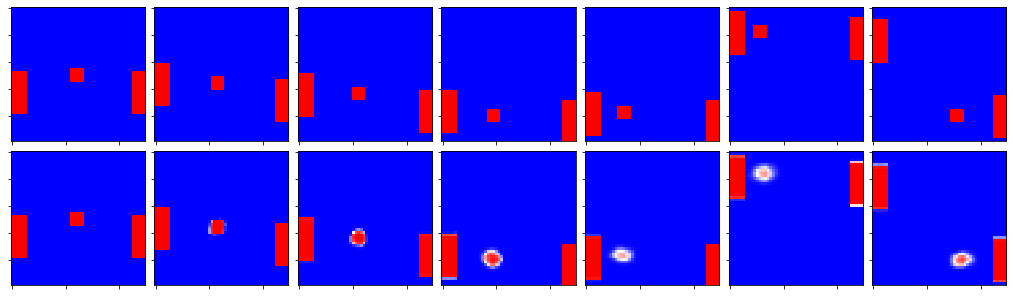

Epoch 156/250
100/100 [==============================] - 111s 1s/step - loss: 0.7310 - frames_loss: 0.0167 - lambda_1_loss: 0.7143 - frames_mean_squared_error: 0.0051 - frames_acc: 0.9929 - lambda_1_mean_squared_error: 312.9366 - lambda_1_acc: 0.9537 - val_loss: 0.4892 - val_frames_loss: 0.0222 - val_lambda_1_loss: 0.4670 - val_frames_mean_squared_error: 0.0066 - val_frames_acc: 0.9907 - val_lambda_1_mean_squared_error: 305.1401 - val_lambda_1_acc: 0.9697


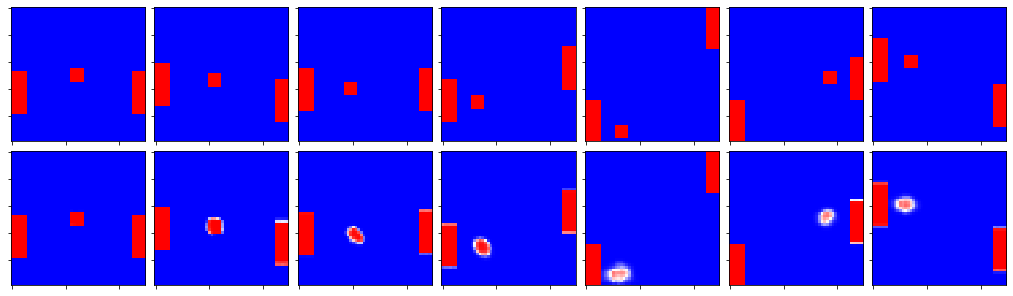

Epoch 157/250
100/100 [==============================] - 111s 1s/step - loss: 0.7123 - frames_loss: 0.0187 - lambda_1_loss: 0.6936 - frames_mean_squared_error: 0.0057 - frames_acc: 0.9920 - lambda_1_mean_squared_error: 282.2873 - lambda_1_acc: 0.9550 - val_loss: 0.3651 - val_frames_loss: 0.0186 - val_lambda_1_loss: 0.3465 - val_frames_mean_squared_error: 0.0058 - val_frames_acc: 0.9918 - val_lambda_1_mean_squared_error: 300.5379 - val_lambda_1_acc: 0.9775


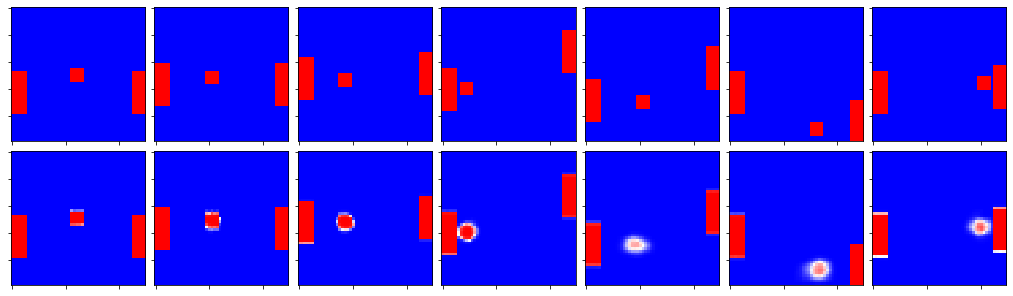

Epoch 158/250
100/100 [==============================] - 111s 1s/step - loss: 0.6719 - frames_loss: 0.0172 - lambda_1_loss: 0.6547 - frames_mean_squared_error: 0.0053 - frames_acc: 0.9925 - lambda_1_mean_squared_error: 298.1088 - lambda_1_acc: 0.9576 - val_loss: 0.7539 - val_frames_loss: 0.0158 - val_lambda_1_loss: 0.7381 - val_frames_mean_squared_error: 0.0048 - val_frames_acc: 0.9933 - val_lambda_1_mean_squared_error: 303.8599 - val_lambda_1_acc: 0.9521


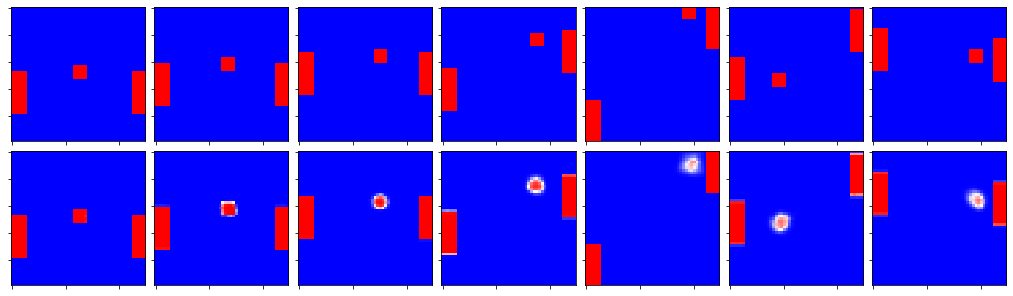

Epoch 159/250
100/100 [==============================] - 111s 1s/step - loss: 0.7770 - frames_loss: 0.0186 - lambda_1_loss: 0.7584 - frames_mean_squared_error: 0.0057 - frames_acc: 0.9921 - lambda_1_mean_squared_error: 288.2163 - lambda_1_acc: 0.9508 - val_loss: 0.5138 - val_frames_loss: 0.0223 - val_lambda_1_loss: 0.4914 - val_frames_mean_squared_error: 0.0067 - val_frames_acc: 0.9906 - val_lambda_1_mean_squared_error: 264.6138 - val_lambda_1_acc: 0.9681


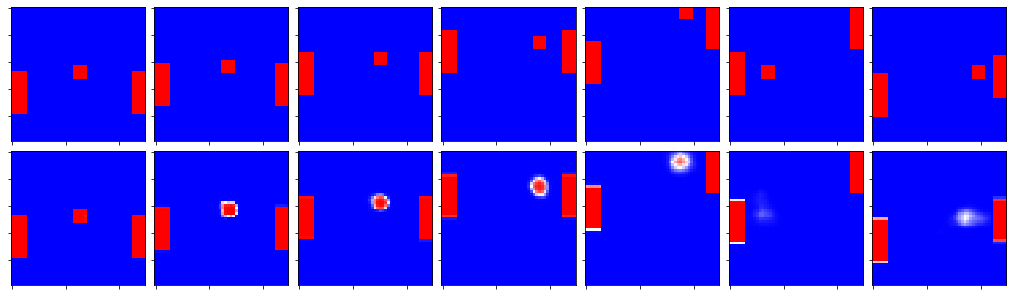

Epoch 160/250
100/100 [==============================] - 111s 1s/step - loss: 0.6647 - frames_loss: 0.0206 - lambda_1_loss: 0.6441 - frames_mean_squared_error: 0.0062 - frames_acc: 0.9913 - lambda_1_mean_squared_error: 236.3212 - lambda_1_acc: 0.9582 - val_loss: 0.8695 - val_frames_loss: 0.0165 - val_lambda_1_loss: 0.8530 - val_frames_mean_squared_error: 0.0050 - val_frames_acc: 0.9930 - val_lambda_1_mean_squared_error: 251.5422 - val_lambda_1_acc: 0.9447


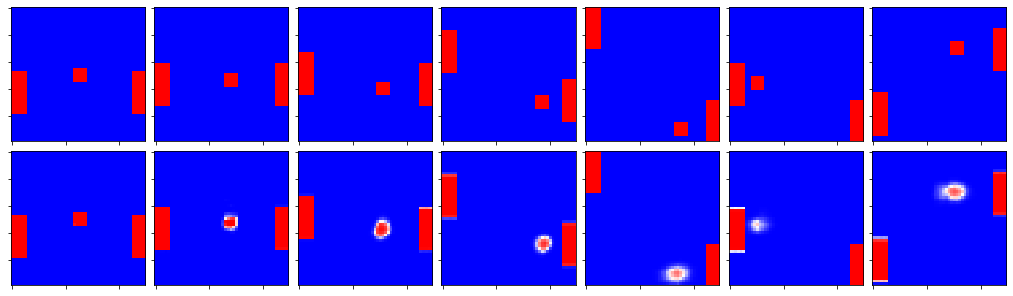

Epoch 161/250
100/100 [==============================] - 111s 1s/step - loss: 0.6758 - frames_loss: 0.0163 - lambda_1_loss: 0.6596 - frames_mean_squared_error: 0.0049 - frames_acc: 0.9931 - lambda_1_mean_squared_error: 282.5788 - lambda_1_acc: 0.9572 - val_loss: 0.6709 - val_frames_loss: 0.0156 - val_lambda_1_loss: 0.6553 - val_frames_mean_squared_error: 0.0048 - val_frames_acc: 0.9933 - val_lambda_1_mean_squared_error: 310.4323 - val_lambda_1_acc: 0.9575


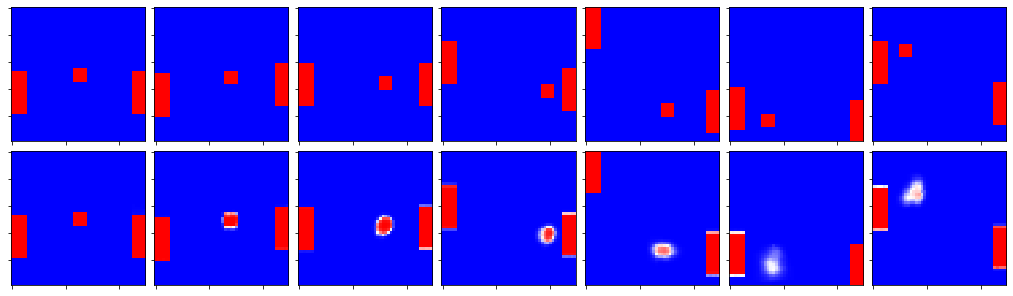

Epoch 162/250
100/100 [==============================] - 111s 1s/step - loss: 0.7369 - frames_loss: 0.0193 - lambda_1_loss: 0.7176 - frames_mean_squared_error: 0.0058 - frames_acc: 0.9919 - lambda_1_mean_squared_error: 283.4483 - lambda_1_acc: 0.9535 - val_loss: 0.7725 - val_frames_loss: 0.0231 - val_lambda_1_loss: 0.7494 - val_frames_mean_squared_error: 0.0069 - val_frames_acc: 0.9903 - val_lambda_1_mean_squared_error: 219.5609 - val_lambda_1_acc: 0.9514


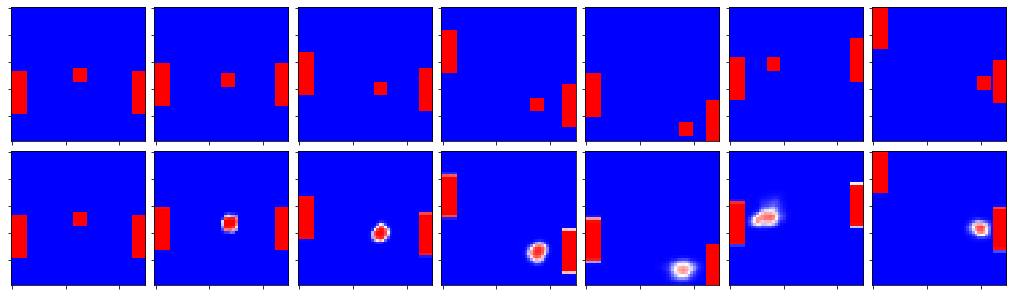

Epoch 163/250
100/100 [==============================] - 110s 1s/step - loss: 0.7056 - frames_loss: 0.0168 - lambda_1_loss: 0.6889 - frames_mean_squared_error: 0.0051 - frames_acc: 0.9929 - lambda_1_mean_squared_error: 262.2776 - lambda_1_acc: 0.9553 - val_loss: 0.9888 - val_frames_loss: 0.0153 - val_lambda_1_loss: 0.9735 - val_frames_mean_squared_error: 0.0046 - val_frames_acc: 0.9936 - val_lambda_1_mean_squared_error: 301.3518 - val_lambda_1_acc: 0.9369


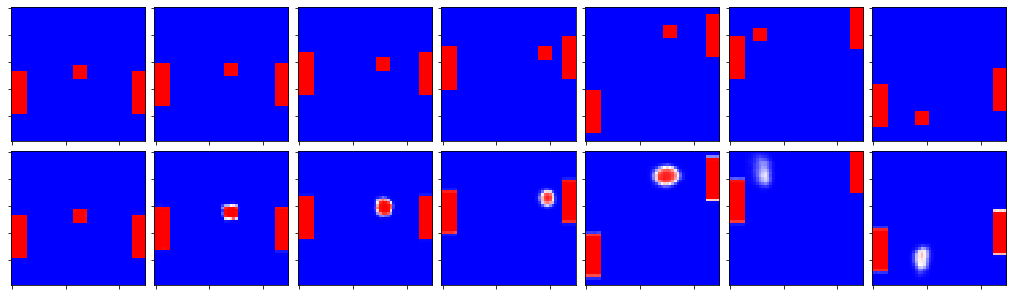

Epoch 164/250
100/100 [==============================] - 111s 1s/step - loss: 0.7278 - frames_loss: 0.0173 - lambda_1_loss: 0.7105 - frames_mean_squared_error: 0.0053 - frames_acc: 0.9926 - lambda_1_mean_squared_error: 291.4573 - lambda_1_acc: 0.9539 - val_loss: 0.5896 - val_frames_loss: 0.0172 - val_lambda_1_loss: 0.5724 - val_frames_mean_squared_error: 0.0053 - val_frames_acc: 0.9926 - val_lambda_1_mean_squared_error: 250.0938 - val_lambda_1_acc: 0.9629


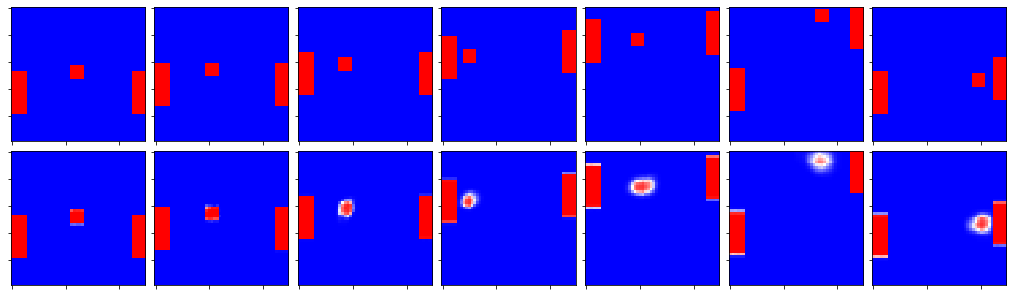

Epoch 165/250
100/100 [==============================] - 111s 1s/step - loss: 0.6790 - frames_loss: 0.0167 - lambda_1_loss: 0.6623 - frames_mean_squared_error: 0.0051 - frames_acc: 0.9929 - lambda_1_mean_squared_error: 283.0471 - lambda_1_acc: 0.9571 - val_loss: 0.9640 - val_frames_loss: 0.0169 - val_lambda_1_loss: 0.9471 - val_frames_mean_squared_error: 0.0052 - val_frames_acc: 0.9926 - val_lambda_1_mean_squared_error: 281.7974 - val_lambda_1_acc: 0.9386


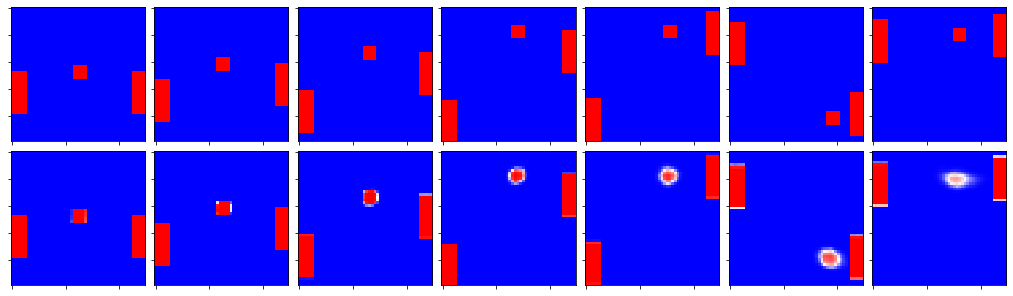

Epoch 166/250
100/100 [==============================] - 111s 1s/step - loss: 0.7418 - frames_loss: 0.0165 - lambda_1_loss: 0.7253 - frames_mean_squared_error: 0.0050 - frames_acc: 0.9929 - lambda_1_mean_squared_error: 287.4792 - lambda_1_acc: 0.9530 - val_loss: 0.6040 - val_frames_loss: 0.0202 - val_lambda_1_loss: 0.5837 - val_frames_mean_squared_error: 0.0060 - val_frames_acc: 0.9918 - val_lambda_1_mean_squared_error: 304.4680 - val_lambda_1_acc: 0.9622


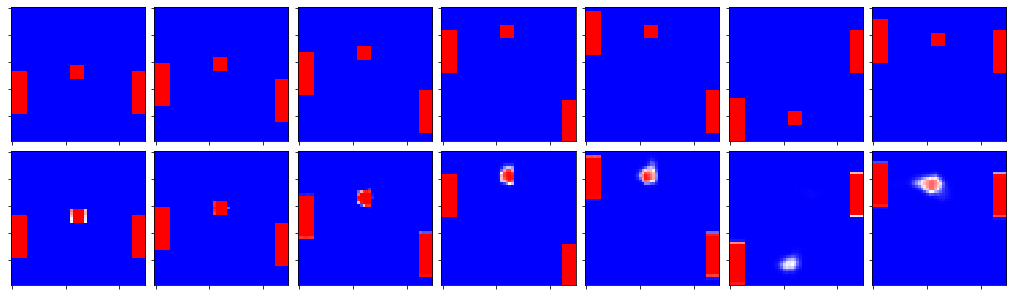

Epoch 167/250
100/100 [==============================] - 111s 1s/step - loss: 0.6337 - frames_loss: 0.0172 - lambda_1_loss: 0.6165 - frames_mean_squared_error: 0.0053 - frames_acc: 0.9926 - lambda_1_mean_squared_error: 279.8503 - lambda_1_acc: 0.9600 - val_loss: 0.6803 - val_frames_loss: 0.0175 - val_lambda_1_loss: 0.6628 - val_frames_mean_squared_error: 0.0054 - val_frames_acc: 0.9923 - val_lambda_1_mean_squared_error: 283.3084 - val_lambda_1_acc: 0.9570


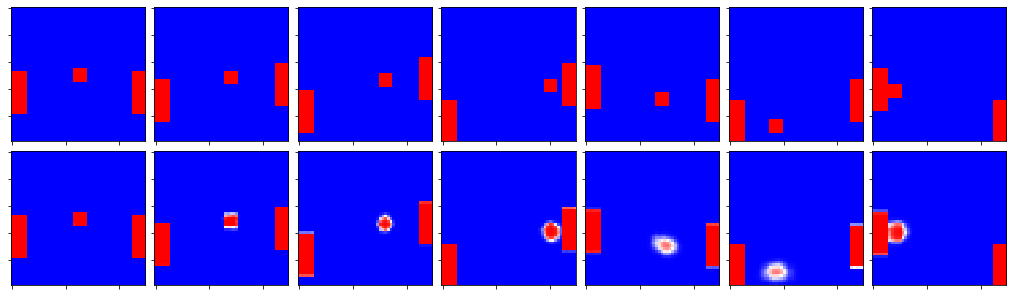

Epoch 168/250
100/100 [==============================] - 111s 1s/step - loss: 0.7006 - frames_loss: 0.0174 - lambda_1_loss: 0.6832 - frames_mean_squared_error: 0.0053 - frames_acc: 0.9925 - lambda_1_mean_squared_error: 275.2084 - lambda_1_acc: 0.9557 - val_loss: 0.6221 - val_frames_loss: 0.0158 - val_lambda_1_loss: 0.6063 - val_frames_mean_squared_error: 0.0048 - val_frames_acc: 0.9932 - val_lambda_1_mean_squared_error: 286.2957 - val_lambda_1_acc: 0.9607


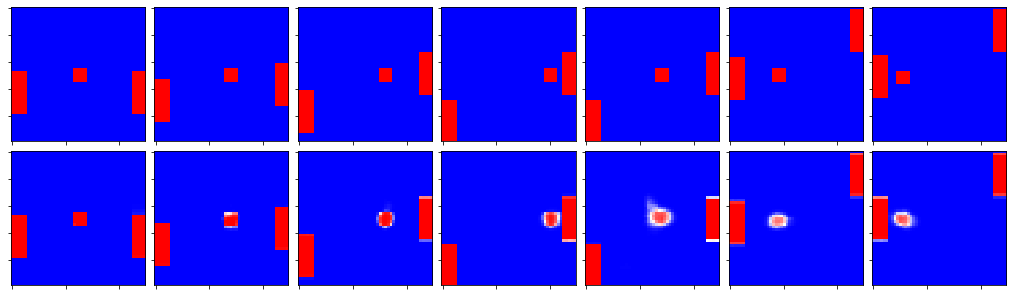

Epoch 169/250
100/100 [==============================] - 111s 1s/step - loss: 0.6921 - frames_loss: 0.0178 - lambda_1_loss: 0.6744 - frames_mean_squared_error: 0.0054 - frames_acc: 0.9924 - lambda_1_mean_squared_error: 278.2984 - lambda_1_acc: 0.9563 - val_loss: 0.9270 - val_frames_loss: 0.0176 - val_lambda_1_loss: 0.9095 - val_frames_mean_squared_error: 0.0054 - val_frames_acc: 0.9924 - val_lambda_1_mean_squared_error: 264.6973 - val_lambda_1_acc: 0.9410


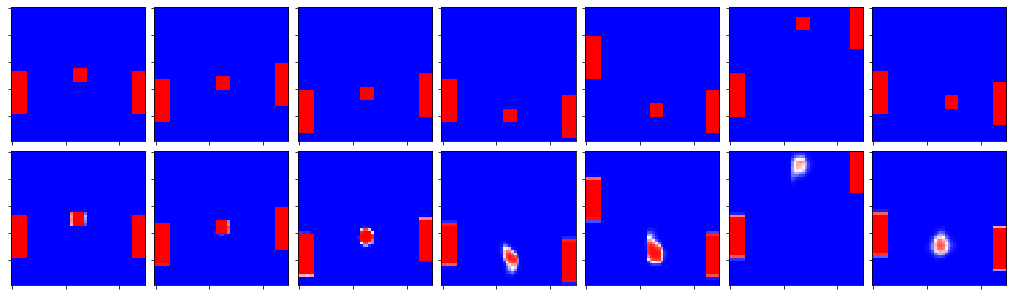

Epoch 170/250
100/100 [==============================] - 111s 1s/step - loss: 0.6981 - frames_loss: 0.0178 - lambda_1_loss: 0.6803 - frames_mean_squared_error: 0.0054 - frames_acc: 0.9924 - lambda_1_mean_squared_error: 261.5992 - lambda_1_acc: 0.9559 - val_loss: 0.7933 - val_frames_loss: 0.0194 - val_lambda_1_loss: 0.7739 - val_frames_mean_squared_error: 0.0059 - val_frames_acc: 0.9918 - val_lambda_1_mean_squared_error: 254.7930 - val_lambda_1_acc: 0.9498


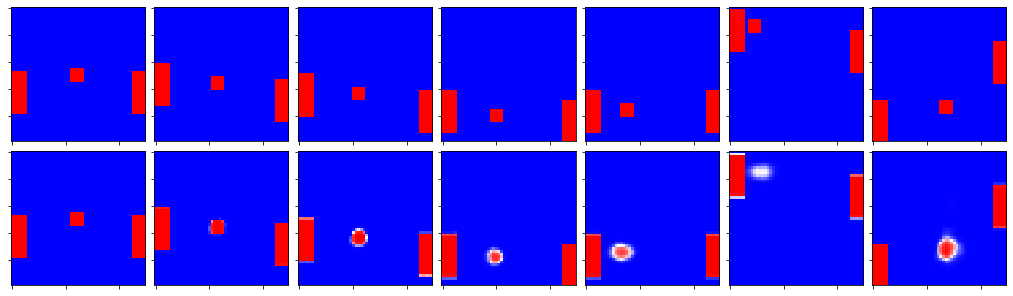

Epoch 171/250
100/100 [==============================] - 111s 1s/step - loss: 0.7092 - frames_loss: 0.0168 - lambda_1_loss: 0.6924 - frames_mean_squared_error: 0.0051 - frames_acc: 0.9928 - lambda_1_mean_squared_error: 259.6453 - lambda_1_acc: 0.9551 - val_loss: 0.7574 - val_frames_loss: 0.0155 - val_lambda_1_loss: 0.7419 - val_frames_mean_squared_error: 0.0047 - val_frames_acc: 0.9934 - val_lambda_1_mean_squared_error: 272.8797 - val_lambda_1_acc: 0.9519


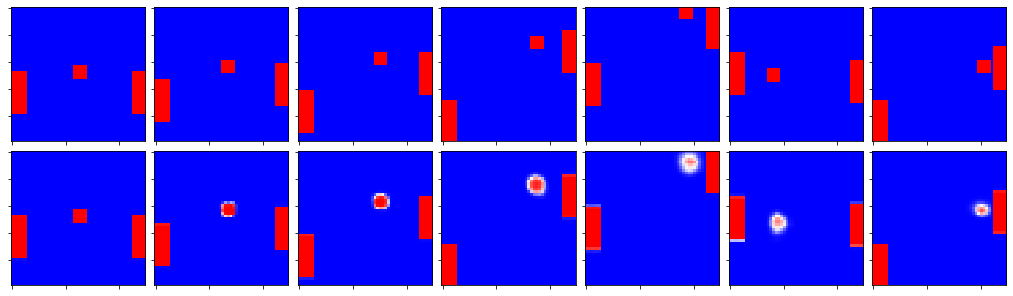

Epoch 172/250
100/100 [==============================] - 111s 1s/step - loss: 0.7520 - frames_loss: 0.0170 - lambda_1_loss: 0.7350 - frames_mean_squared_error: 0.0052 - frames_acc: 0.9927 - lambda_1_mean_squared_error: 269.9018 - lambda_1_acc: 0.9523 - val_loss: 0.6496 - val_frames_loss: 0.0188 - val_lambda_1_loss: 0.6308 - val_frames_mean_squared_error: 0.0057 - val_frames_acc: 0.9919 - val_lambda_1_mean_squared_error: 271.5760 - val_lambda_1_acc: 0.9591


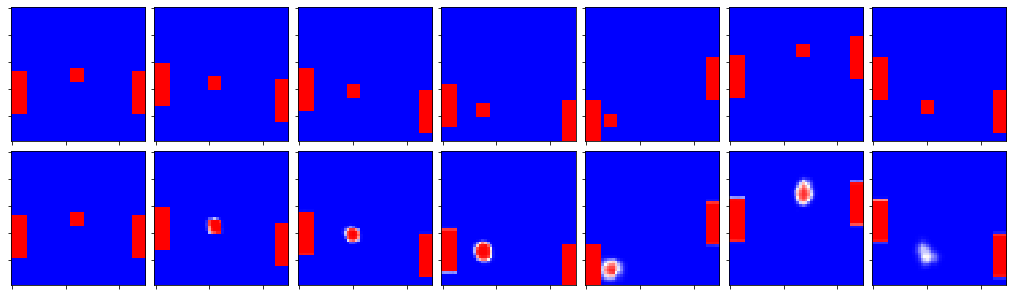

Epoch 173/250
100/100 [==============================] - 111s 1s/step - loss: 0.6861 - frames_loss: 0.0165 - lambda_1_loss: 0.6695 - frames_mean_squared_error: 0.0051 - frames_acc: 0.9929 - lambda_1_mean_squared_error: 269.1171 - lambda_1_acc: 0.9566 - val_loss: 0.7942 - val_frames_loss: 0.0165 - val_lambda_1_loss: 0.7776 - val_frames_mean_squared_error: 0.0050 - val_frames_acc: 0.9930 - val_lambda_1_mean_squared_error: 309.7827 - val_lambda_1_acc: 0.9496


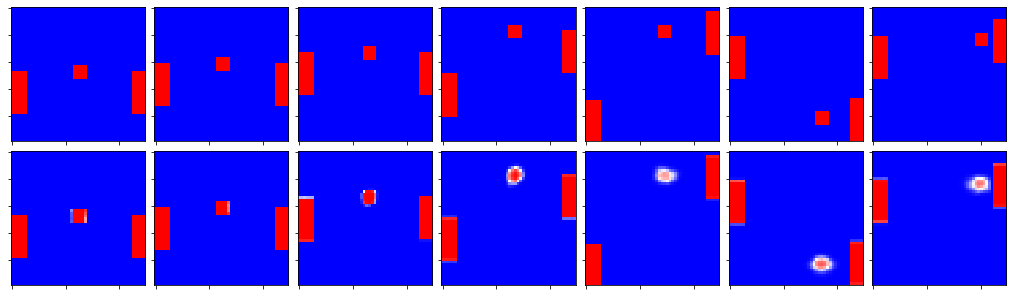

Epoch 174/250
100/100 [==============================] - 111s 1s/step - loss: 0.6970 - frames_loss: 0.0174 - lambda_1_loss: 0.6795 - frames_mean_squared_error: 0.0053 - frames_acc: 0.9925 - lambda_1_mean_squared_error: 264.0487 - lambda_1_acc: 0.9559 - val_loss: 0.9206 - val_frames_loss: 0.0149 - val_lambda_1_loss: 0.9057 - val_frames_mean_squared_error: 0.0045 - val_frames_acc: 0.9937 - val_lambda_1_mean_squared_error: 250.0800 - val_lambda_1_acc: 0.9413


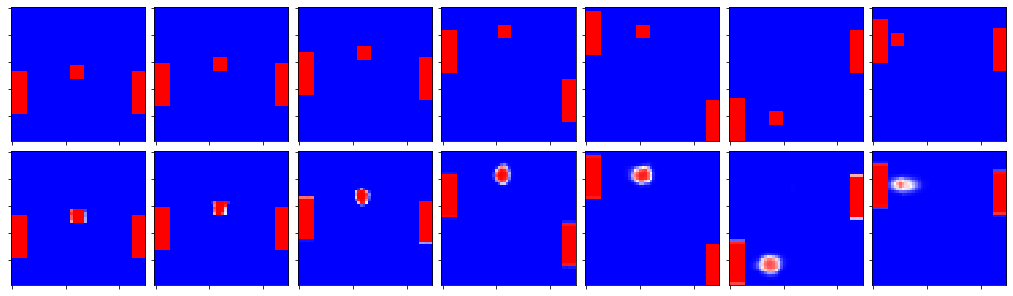

Epoch 175/250
100/100 [==============================] - 111s 1s/step - loss: 0.6646 - frames_loss: 0.0152 - lambda_1_loss: 0.6495 - frames_mean_squared_error: 0.0046 - frames_acc: 0.9936 - lambda_1_mean_squared_error: 282.6663 - lambda_1_acc: 0.9579 - val_loss: 0.1320 - val_frames_loss: 0.0152 - val_lambda_1_loss: 0.1167 - val_frames_mean_squared_error: 0.0047 - val_frames_acc: 0.9934 - val_lambda_1_mean_squared_error: 270.8014 - val_lambda_1_acc: 0.9924


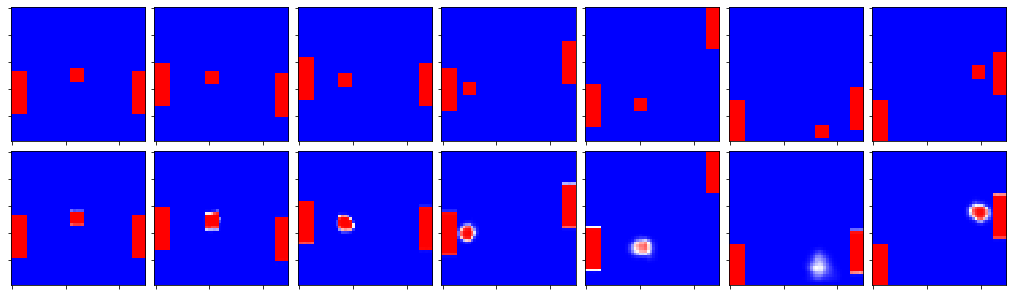

Epoch 176/250
100/100 [==============================] - 111s 1s/step - loss: 0.6986 - frames_loss: 0.0158 - lambda_1_loss: 0.6829 - frames_mean_squared_error: 0.0048 - frames_acc: 0.9932 - lambda_1_mean_squared_error: 288.5691 - lambda_1_acc: 0.9557 - val_loss: 0.8526 - val_frames_loss: 0.0166 - val_lambda_1_loss: 0.8360 - val_frames_mean_squared_error: 0.0051 - val_frames_acc: 0.9928 - val_lambda_1_mean_squared_error: 266.7182 - val_lambda_1_acc: 0.9458


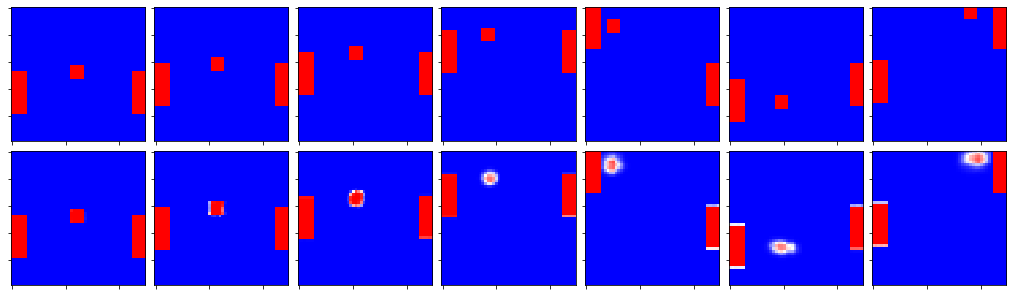

Epoch 177/250
100/100 [==============================] - 111s 1s/step - loss: 0.6809 - frames_loss: 0.0173 - lambda_1_loss: 0.6635 - frames_mean_squared_error: 0.0052 - frames_acc: 0.9927 - lambda_1_mean_squared_error: 259.2266 - lambda_1_acc: 0.9570 - val_loss: 0.4969 - val_frames_loss: 0.0149 - val_lambda_1_loss: 0.4820 - val_frames_mean_squared_error: 0.0045 - val_frames_acc: 0.9936 - val_lambda_1_mean_squared_error: 282.6499 - val_lambda_1_acc: 0.9688


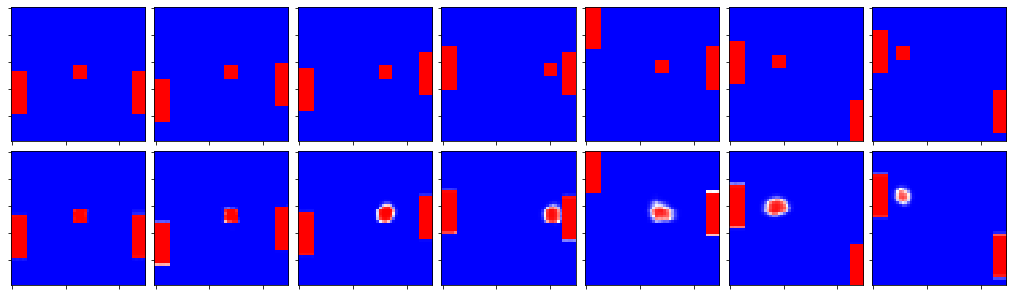

Epoch 178/250
100/100 [==============================] - 111s 1s/step - loss: 0.6838 - frames_loss: 0.0174 - lambda_1_loss: 0.6664 - frames_mean_squared_error: 0.0053 - frames_acc: 0.9926 - lambda_1_mean_squared_error: 271.1148 - lambda_1_acc: 0.9568 - val_loss: 0.9601 - val_frames_loss: 0.0167 - val_lambda_1_loss: 0.9433 - val_frames_mean_squared_error: 0.0052 - val_frames_acc: 0.9927 - val_lambda_1_mean_squared_error: 246.0275 - val_lambda_1_acc: 0.9388


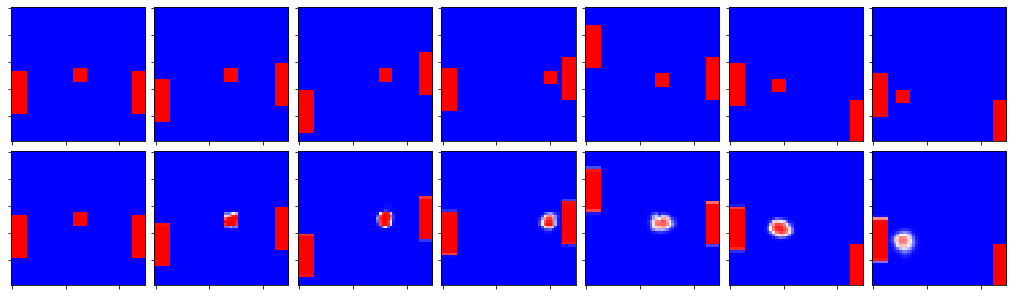

Epoch 179/250
100/100 [==============================] - 111s 1s/step - loss: 0.6992 - frames_loss: 0.0171 - lambda_1_loss: 0.6821 - frames_mean_squared_error: 0.0052 - frames_acc: 0.9927 - lambda_1_mean_squared_error: 240.6114 - lambda_1_acc: 0.9558 - val_loss: 0.5872 - val_frames_loss: 0.0148 - val_lambda_1_loss: 0.5724 - val_frames_mean_squared_error: 0.0045 - val_frames_acc: 0.9937 - val_lambda_1_mean_squared_error: 263.6276 - val_lambda_1_acc: 0.9629


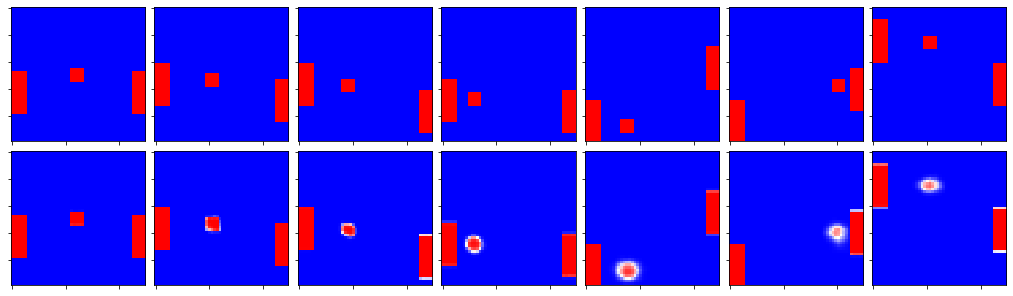

Epoch 180/250
100/100 [==============================] - 111s 1s/step - loss: 0.6933 - frames_loss: 0.0157 - lambda_1_loss: 0.6777 - frames_mean_squared_error: 0.0048 - frames_acc: 0.9933 - lambda_1_mean_squared_error: 270.5704 - lambda_1_acc: 0.9561 - val_loss: 0.7279 - val_frames_loss: 0.0142 - val_lambda_1_loss: 0.7136 - val_frames_mean_squared_error: 0.0043 - val_frames_acc: 0.9940 - val_lambda_1_mean_squared_error: 255.3249 - val_lambda_1_acc: 0.9537


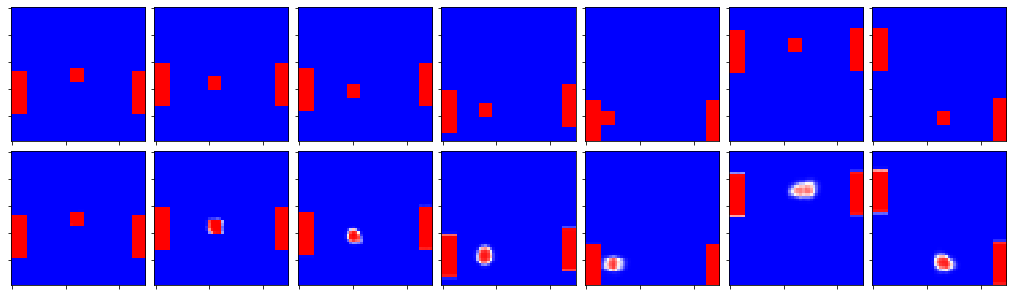

Epoch 181/250
100/100 [==============================] - 111s 1s/step - loss: 0.7010 - frames_loss: 0.0155 - lambda_1_loss: 0.6855 - frames_mean_squared_error: 0.0047 - frames_acc: 0.9933 - lambda_1_mean_squared_error: 277.0717 - lambda_1_acc: 0.9556 - val_loss: 0.8636 - val_frames_loss: 0.0163 - val_lambda_1_loss: 0.8473 - val_frames_mean_squared_error: 0.0050 - val_frames_acc: 0.9930 - val_lambda_1_mean_squared_error: 270.5410 - val_lambda_1_acc: 0.9451


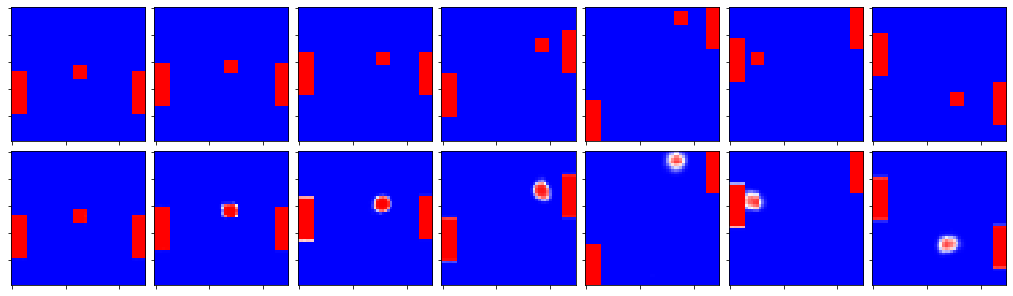

Epoch 182/250
100/100 [==============================] - 111s 1s/step - loss: 0.7053 - frames_loss: 0.0157 - lambda_1_loss: 0.6895 - frames_mean_squared_error: 0.0048 - frames_acc: 0.9932 - lambda_1_mean_squared_error: 276.6662 - lambda_1_acc: 0.9553 - val_loss: 0.8438 - val_frames_loss: 0.0154 - val_lambda_1_loss: 0.8285 - val_frames_mean_squared_error: 0.0047 - val_frames_acc: 0.9934 - val_lambda_1_mean_squared_error: 267.4007 - val_lambda_1_acc: 0.9463


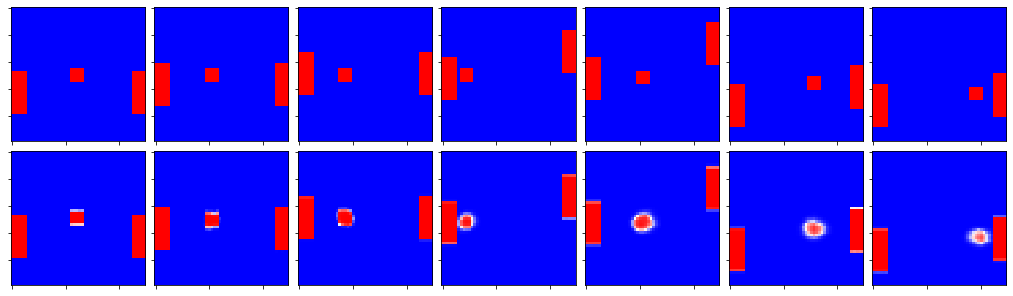

Epoch 183/250
100/100 [==============================] - 111s 1s/step - loss: 0.7199 - frames_loss: 0.0155 - lambda_1_loss: 0.7044 - frames_mean_squared_error: 0.0047 - frames_acc: 0.9934 - lambda_1_mean_squared_error: 273.9090 - lambda_1_acc: 0.9543 - val_loss: 1.0042 - val_frames_loss: 0.0156 - val_lambda_1_loss: 0.9885 - val_frames_mean_squared_error: 0.0048 - val_frames_acc: 0.9932 - val_lambda_1_mean_squared_error: 269.0112 - val_lambda_1_acc: 0.9359


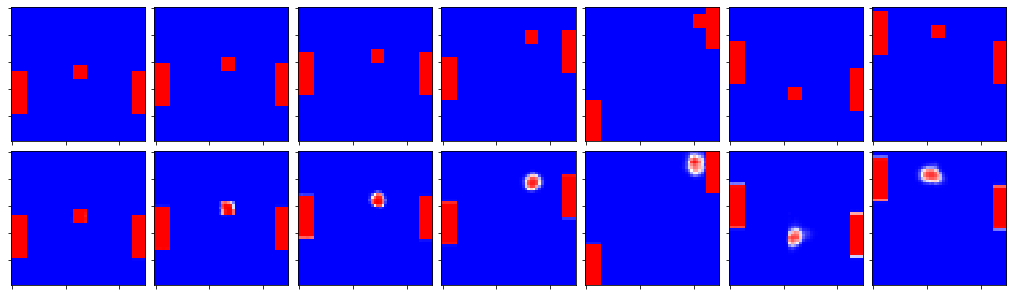

Epoch 184/250
100/100 [==============================] - 111s 1s/step - loss: 0.7394 - frames_loss: 0.0168 - lambda_1_loss: 0.7226 - frames_mean_squared_error: 0.0051 - frames_acc: 0.9929 - lambda_1_mean_squared_error: 271.5878 - lambda_1_acc: 0.9532 - val_loss: 1.3749 - val_frames_loss: 0.0173 - val_lambda_1_loss: 1.3576 - val_frames_mean_squared_error: 0.0054 - val_frames_acc: 0.9924 - val_lambda_1_mean_squared_error: 256.4523 - val_lambda_1_acc: 0.9120


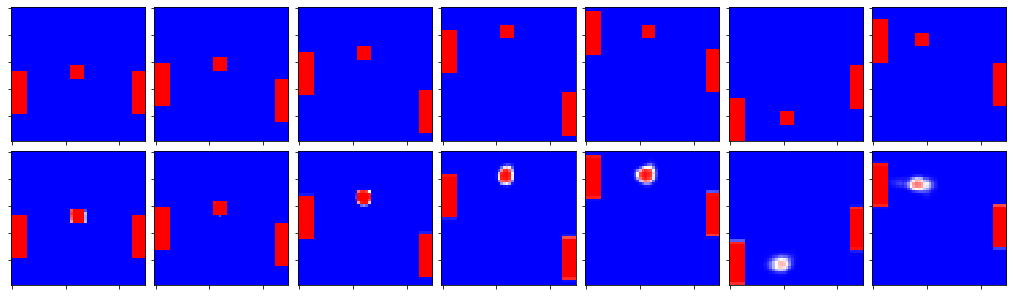

Epoch 185/250
100/100 [==============================] - 111s 1s/step - loss: 0.6749 - frames_loss: 0.0160 - lambda_1_loss: 0.6588 - frames_mean_squared_error: 0.0049 - frames_acc: 0.9932 - lambda_1_mean_squared_error: 252.8142 - lambda_1_acc: 0.9573 - val_loss: 0.8276 - val_frames_loss: 0.0160 - val_lambda_1_loss: 0.8115 - val_frames_mean_squared_error: 0.0049 - val_frames_acc: 0.9931 - val_lambda_1_mean_squared_error: 264.3591 - val_lambda_1_acc: 0.9474


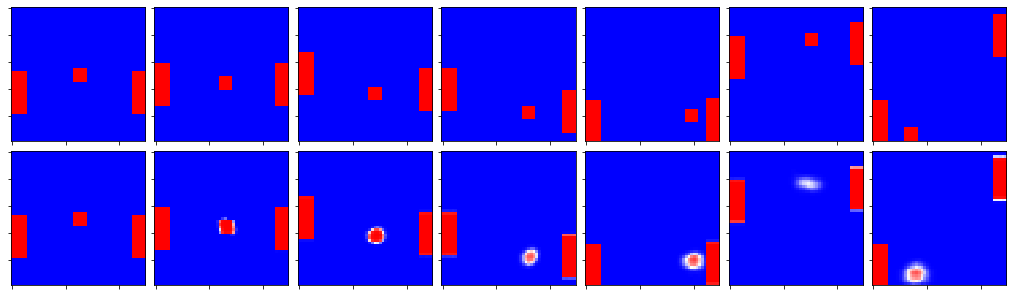

Epoch 186/250
100/100 [==============================] - 111s 1s/step - loss: 0.6712 - frames_loss: 0.0174 - lambda_1_loss: 0.6538 - frames_mean_squared_error: 0.0053 - frames_acc: 0.9926 - lambda_1_mean_squared_error: 257.7213 - lambda_1_acc: 0.9576 - val_loss: 0.8113 - val_frames_loss: 0.0186 - val_lambda_1_loss: 0.7927 - val_frames_mean_squared_error: 0.0058 - val_frames_acc: 0.9918 - val_lambda_1_mean_squared_error: 208.7103 - val_lambda_1_acc: 0.9486


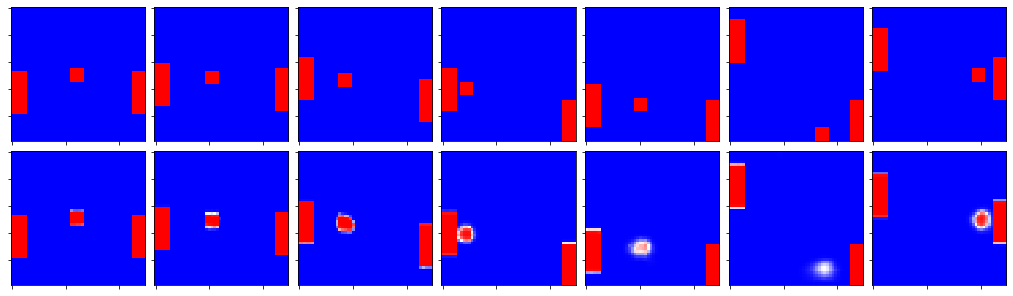

Epoch 187/250
100/100 [==============================] - 111s 1s/step - loss: 0.6568 - frames_loss: 0.0154 - lambda_1_loss: 0.6414 - frames_mean_squared_error: 0.0047 - frames_acc: 0.9934 - lambda_1_mean_squared_error: 249.3822 - lambda_1_acc: 0.9584 - val_loss: 0.7921 - val_frames_loss: 0.0163 - val_lambda_1_loss: 0.7758 - val_frames_mean_squared_error: 0.0050 - val_frames_acc: 0.9930 - val_lambda_1_mean_squared_error: 264.1877 - val_lambda_1_acc: 0.9497


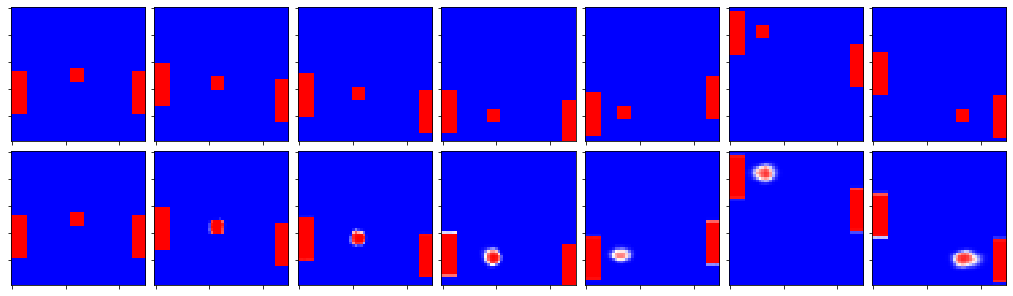

Epoch 188/250
100/100 [==============================] - 111s 1s/step - loss: 0.6524 - frames_loss: 0.0148 - lambda_1_loss: 0.6376 - frames_mean_squared_error: 0.0045 - frames_acc: 0.9937 - lambda_1_mean_squared_error: 270.9488 - lambda_1_acc: 0.9587 - val_loss: 0.7005 - val_frames_loss: 0.0151 - val_lambda_1_loss: 0.6854 - val_frames_mean_squared_error: 0.0046 - val_frames_acc: 0.9936 - val_lambda_1_mean_squared_error: 271.4575 - val_lambda_1_acc: 0.9556


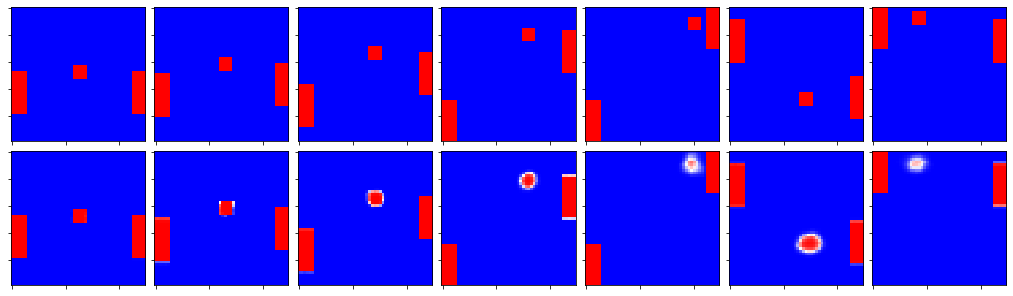

Epoch 189/250
100/100 [==============================] - 111s 1s/step - loss: 0.6986 - frames_loss: 0.0157 - lambda_1_loss: 0.6829 - frames_mean_squared_error: 0.0048 - frames_acc: 0.9933 - lambda_1_mean_squared_error: 264.1081 - lambda_1_acc: 0.9557 - val_loss: 0.5903 - val_frames_loss: 0.0142 - val_lambda_1_loss: 0.5762 - val_frames_mean_squared_error: 0.0044 - val_frames_acc: 0.9939 - val_lambda_1_mean_squared_error: 271.1257 - val_lambda_1_acc: 0.9626


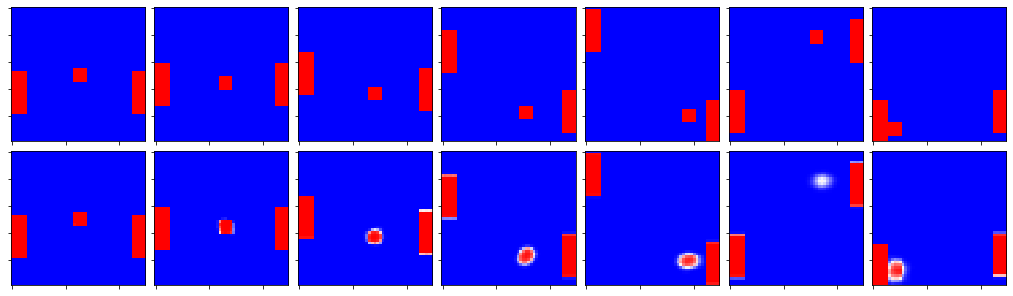

Epoch 190/250
100/100 [==============================] - 110s 1s/step - loss: 0.7288 - frames_loss: 0.0145 - lambda_1_loss: 0.7143 - frames_mean_squared_error: 0.0044 - frames_acc: 0.9938 - lambda_1_mean_squared_error: 278.7589 - lambda_1_acc: 0.9537 - val_loss: 0.9253 - val_frames_loss: 0.0177 - val_lambda_1_loss: 0.9076 - val_frames_mean_squared_error: 0.0053 - val_frames_acc: 0.9927 - val_lambda_1_mean_squared_error: 283.6892 - val_lambda_1_acc: 0.9412


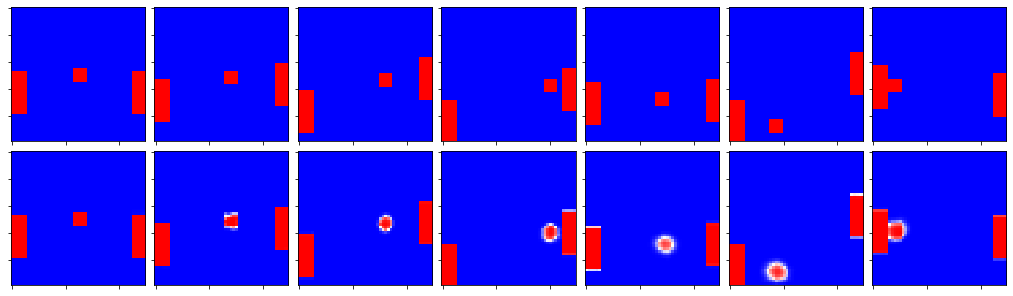

Epoch 191/250
100/100 [==============================] - 111s 1s/step - loss: 0.7510 - frames_loss: 0.0166 - lambda_1_loss: 0.7343 - frames_mean_squared_error: 0.0050 - frames_acc: 0.9931 - lambda_1_mean_squared_error: 278.5475 - lambda_1_acc: 0.9524 - val_loss: 0.5725 - val_frames_loss: 0.0208 - val_lambda_1_loss: 0.5517 - val_frames_mean_squared_error: 0.0063 - val_frames_acc: 0.9911 - val_lambda_1_mean_squared_error: 239.0392 - val_lambda_1_acc: 0.9642


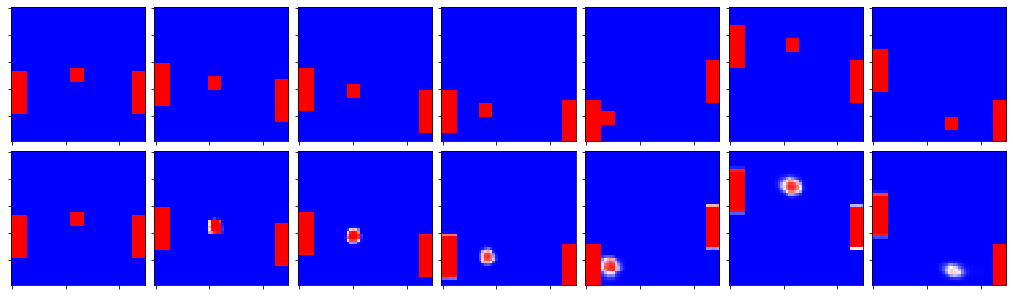

Epoch 192/250
100/100 [==============================] - 111s 1s/step - loss: 0.7044 - frames_loss: 0.0154 - lambda_1_loss: 0.6889 - frames_mean_squared_error: 0.0047 - frames_acc: 0.9934 - lambda_1_mean_squared_error: 246.3809 - lambda_1_acc: 0.9553 - val_loss: 0.8487 - val_frames_loss: 0.0145 - val_lambda_1_loss: 0.8341 - val_frames_mean_squared_error: 0.0044 - val_frames_acc: 0.9939 - val_lambda_1_mean_squared_error: 257.9277 - val_lambda_1_acc: 0.9459


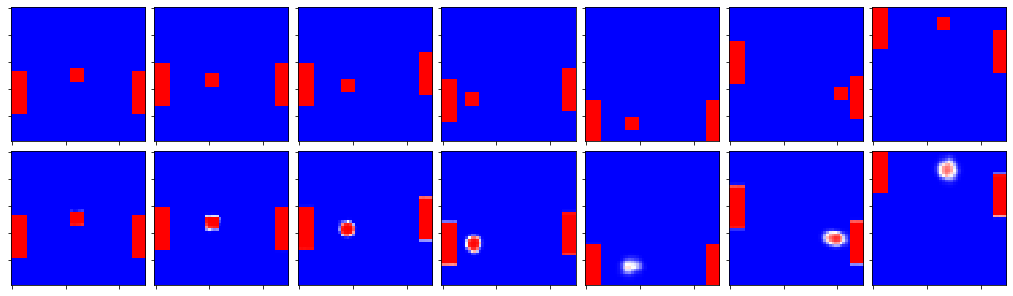

Epoch 193/250
100/100 [==============================] - 110s 1s/step - loss: 0.7534 - frames_loss: 0.0151 - lambda_1_loss: 0.7383 - frames_mean_squared_error: 0.0046 - frames_acc: 0.9936 - lambda_1_mean_squared_error: 265.3851 - lambda_1_acc: 0.9521 - val_loss: 0.2830 - val_frames_loss: 0.0156 - val_lambda_1_loss: 0.2674 - val_frames_mean_squared_error: 0.0048 - val_frames_acc: 0.9933 - val_lambda_1_mean_squared_error: 265.6573 - val_lambda_1_acc: 0.9827


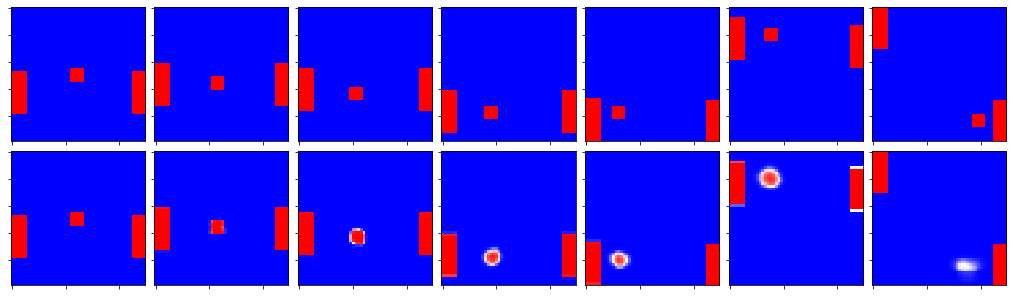

Epoch 194/250
100/100 [==============================] - 111s 1s/step - loss: 0.7172 - frames_loss: 0.0149 - lambda_1_loss: 0.7022 - frames_mean_squared_error: 0.0045 - frames_acc: 0.9937 - lambda_1_mean_squared_error: 268.1898 - lambda_1_acc: 0.9545 - val_loss: 0.6418 - val_frames_loss: 0.0242 - val_lambda_1_loss: 0.6176 - val_frames_mean_squared_error: 0.0062 - val_frames_acc: 0.9916 - val_lambda_1_mean_squared_error: 268.7051 - val_lambda_1_acc: 0.9600


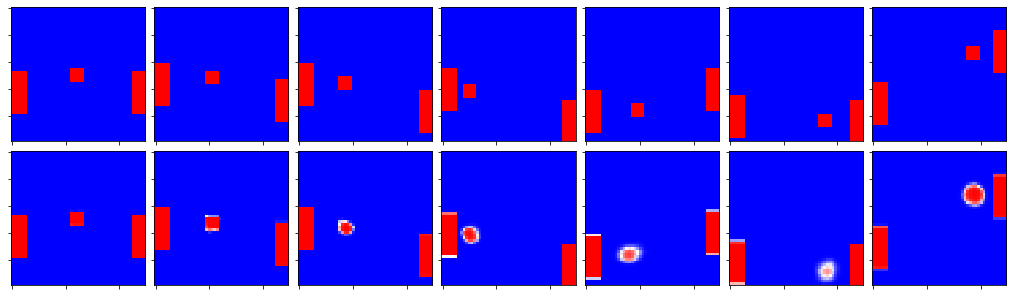

Epoch 195/250
100/100 [==============================] - 110s 1s/step - loss: 0.7058 - frames_loss: 0.0159 - lambda_1_loss: 0.6899 - frames_mean_squared_error: 0.0048 - frames_acc: 0.9933 - lambda_1_mean_squared_error: 241.4897 - lambda_1_acc: 0.9553 - val_loss: 0.3006 - val_frames_loss: 0.0144 - val_lambda_1_loss: 0.2862 - val_frames_mean_squared_error: 0.0044 - val_frames_acc: 0.9938 - val_lambda_1_mean_squared_error: 256.0560 - val_lambda_1_acc: 0.9814


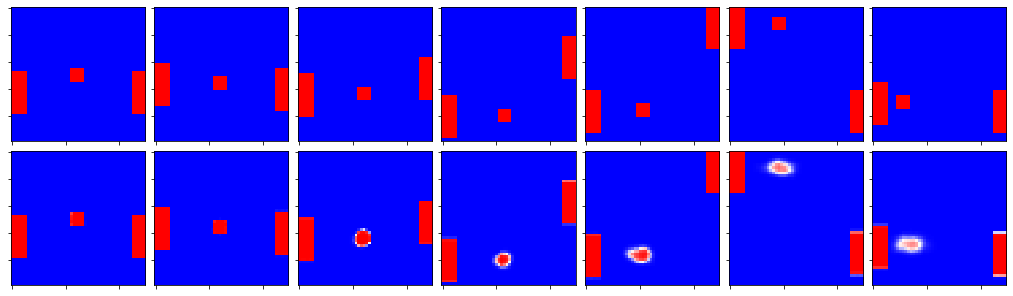

Epoch 196/250
100/100 [==============================] - 111s 1s/step - loss: 0.7576 - frames_loss: 0.0162 - lambda_1_loss: 0.7414 - frames_mean_squared_error: 0.0049 - frames_acc: 0.9932 - lambda_1_mean_squared_error: 257.7458 - lambda_1_acc: 0.9519 - val_loss: 0.6439 - val_frames_loss: 0.0169 - val_lambda_1_loss: 0.6270 - val_frames_mean_squared_error: 0.0051 - val_frames_acc: 0.9928 - val_lambda_1_mean_squared_error: 281.8215 - val_lambda_1_acc: 0.9594


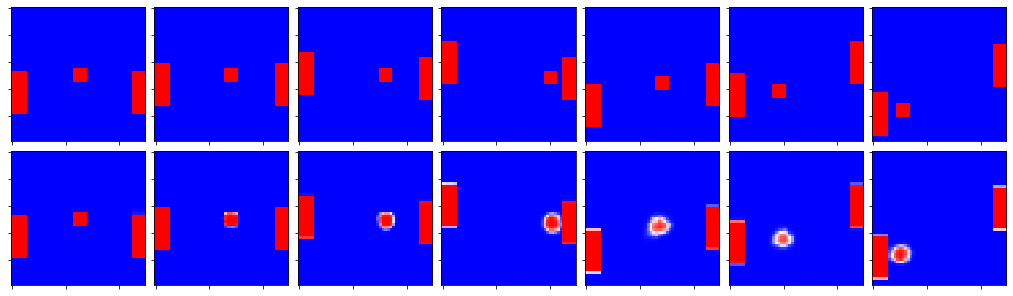

Epoch 197/250
100/100 [==============================] - 111s 1s/step - loss: 0.7416 - frames_loss: 0.0179 - lambda_1_loss: 0.7238 - frames_mean_squared_error: 0.0054 - frames_acc: 0.9925 - lambda_1_mean_squared_error: 401.0821 - lambda_1_acc: 0.9531 - val_loss: 0.3847 - val_frames_loss: 0.0137 - val_lambda_1_loss: 0.3709 - val_frames_mean_squared_error: 0.0041 - val_frames_acc: 0.9943 - val_lambda_1_mean_squared_error: 478.7505 - val_lambda_1_acc: 0.9760


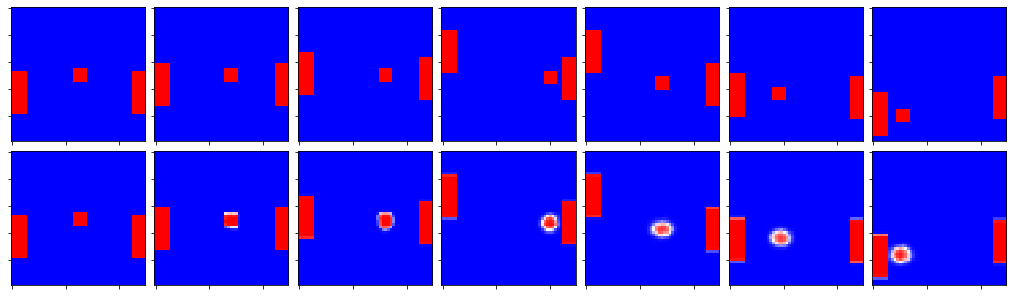

Epoch 198/250
100/100 [==============================] - 111s 1s/step - loss: 0.6949 - frames_loss: 0.0152 - lambda_1_loss: 0.6797 - frames_mean_squared_error: 0.0046 - frames_acc: 0.9935 - lambda_1_mean_squared_error: 465.2395 - lambda_1_acc: 0.9559 - val_loss: 1.1286 - val_frames_loss: 0.0139 - val_lambda_1_loss: 1.1147 - val_frames_mean_squared_error: 0.0042 - val_frames_acc: 0.9941 - val_lambda_1_mean_squared_error: 481.8141 - val_lambda_1_acc: 0.9277


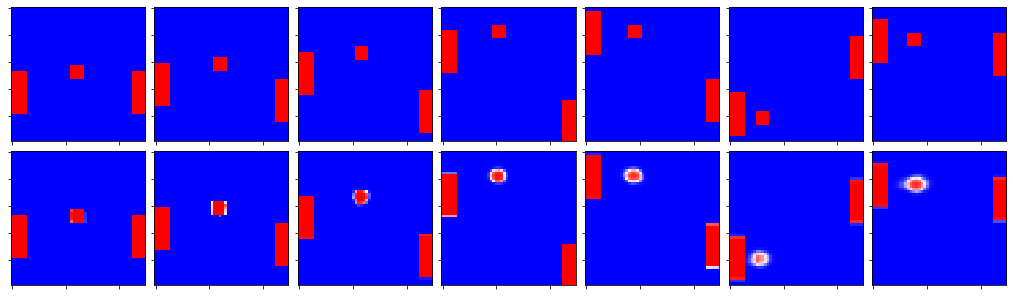

Epoch 199/250
100/100 [==============================] - 111s 1s/step - loss: 0.7401 - frames_loss: 0.0151 - lambda_1_loss: 0.7250 - frames_mean_squared_error: 0.0046 - frames_acc: 0.9936 - lambda_1_mean_squared_error: 480.3558 - lambda_1_acc: 0.9530 - val_loss: 0.9931 - val_frames_loss: 0.0140 - val_lambda_1_loss: 0.9791 - val_frames_mean_squared_error: 0.0043 - val_frames_acc: 0.9941 - val_lambda_1_mean_squared_error: 504.5549 - val_lambda_1_acc: 0.9365


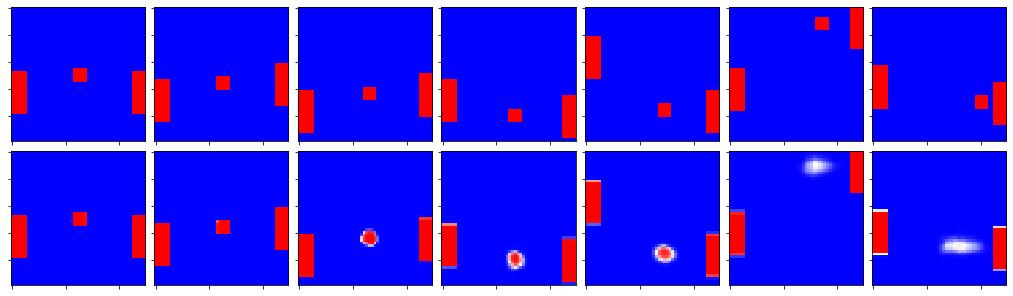

Epoch 200/250
100/100 [==============================] - 111s 1s/step - loss: 0.7277 - frames_loss: 0.0139 - lambda_1_loss: 0.7138 - frames_mean_squared_error: 0.0042 - frames_acc: 0.9941 - lambda_1_mean_squared_error: 512.5969 - lambda_1_acc: 0.9537 - val_loss: 0.7504 - val_frames_loss: 0.0142 - val_lambda_1_loss: 0.7362 - val_frames_mean_squared_error: 0.0044 - val_frames_acc: 0.9939 - val_lambda_1_mean_squared_error: 538.4308 - val_lambda_1_acc: 0.9523


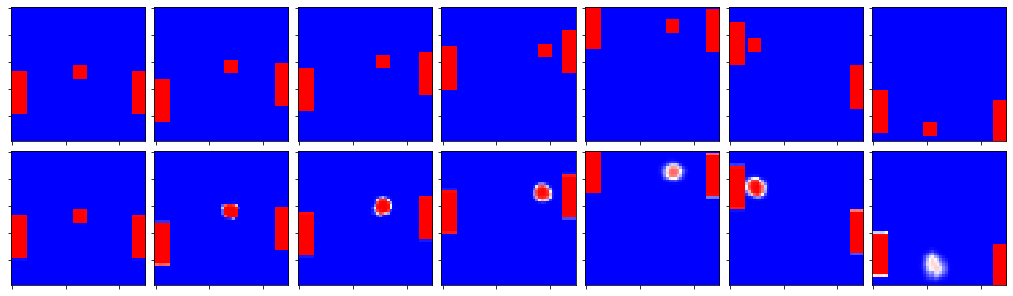

Epoch 201/250
100/100 [==============================] - 111s 1s/step - loss: 0.6234 - frames_loss: 0.0145 - lambda_1_loss: 0.6089 - frames_mean_squared_error: 0.0044 - frames_acc: 0.9938 - lambda_1_mean_squared_error: 513.4726 - lambda_1_acc: 0.9605 - val_loss: 0.4180 - val_frames_loss: 0.0132 - val_lambda_1_loss: 0.4048 - val_frames_mean_squared_error: 0.0040 - val_frames_acc: 0.9944 - val_lambda_1_mean_squared_error: 540.1457 - val_lambda_1_acc: 0.9738


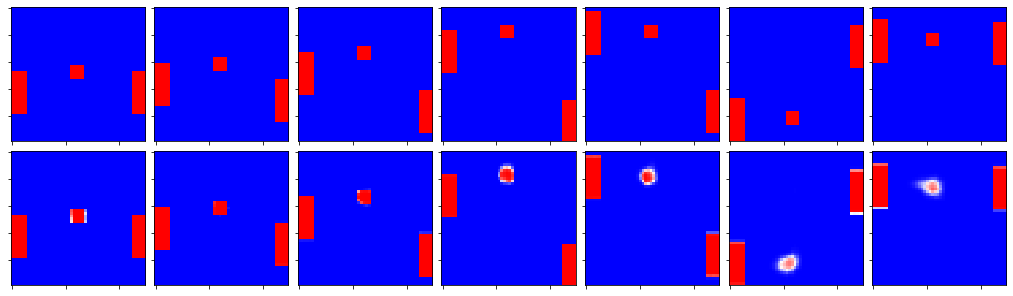

Epoch 202/250
100/100 [==============================] - 110s 1s/step - loss: 0.6239 - frames_loss: 0.0153 - lambda_1_loss: 0.6086 - frames_mean_squared_error: 0.0046 - frames_acc: 0.9936 - lambda_1_mean_squared_error: 502.4230 - lambda_1_acc: 0.9605 - val_loss: 0.8927 - val_frames_loss: 0.0152 - val_lambda_1_loss: 0.8774 - val_frames_mean_squared_error: 0.0046 - val_frames_acc: 0.9936 - val_lambda_1_mean_squared_error: 488.2427 - val_lambda_1_acc: 0.9431


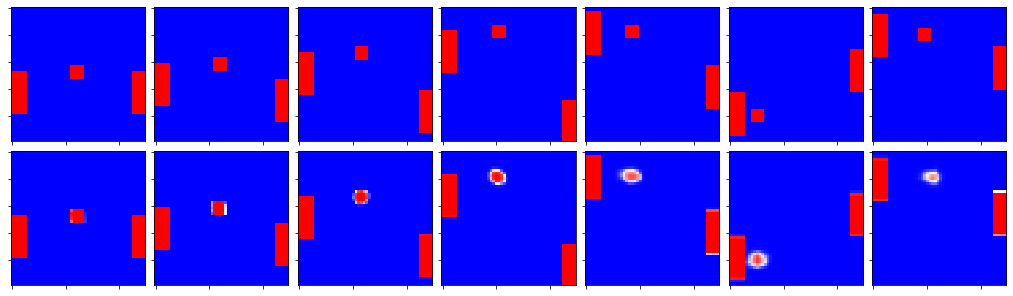

Epoch 203/250
100/100 [==============================] - 111s 1s/step - loss: 0.6964 - frames_loss: 0.0156 - lambda_1_loss: 0.6808 - frames_mean_squared_error: 0.0047 - frames_acc: 0.9934 - lambda_1_mean_squared_error: 461.3842 - lambda_1_acc: 0.9559 - val_loss: 0.2545 - val_frames_loss: 0.0153 - val_lambda_1_loss: 0.2391 - val_frames_mean_squared_error: 0.0046 - val_frames_acc: 0.9935 - val_lambda_1_mean_squared_error: 509.1710 - val_lambda_1_acc: 0.9845


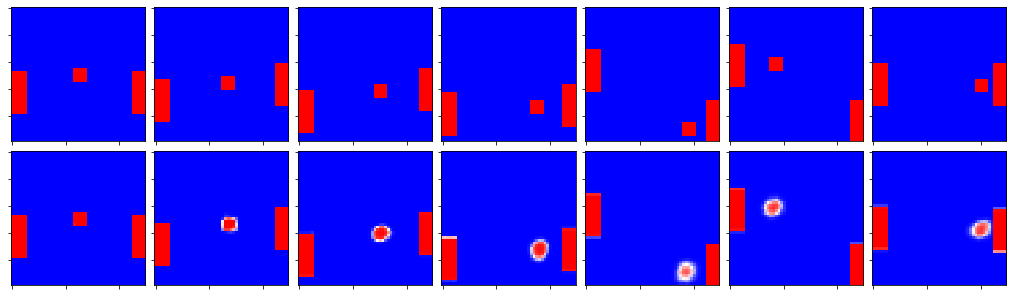

Epoch 204/250
100/100 [==============================] - 111s 1s/step - loss: 0.6655 - frames_loss: 0.0147 - lambda_1_loss: 0.6508 - frames_mean_squared_error: 0.0045 - frames_acc: 0.9938 - lambda_1_mean_squared_error: 493.9548 - lambda_1_acc: 0.9578 - val_loss: 0.6532 - val_frames_loss: 0.0149 - val_lambda_1_loss: 0.6383 - val_frames_mean_squared_error: 0.0046 - val_frames_acc: 0.9935 - val_lambda_1_mean_squared_error: 459.0344 - val_lambda_1_acc: 0.9586


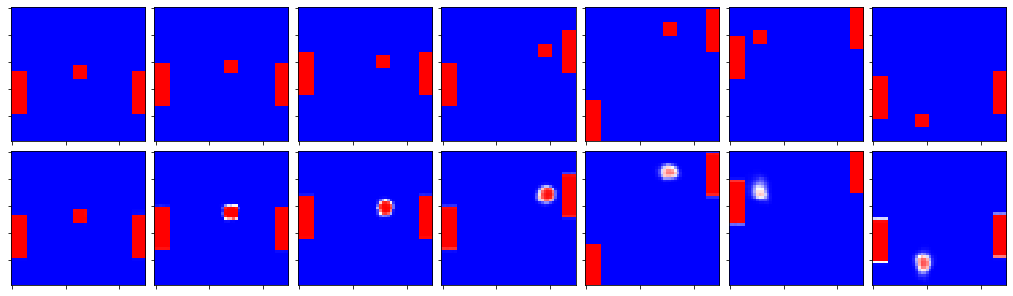

Epoch 205/250
100/100 [==============================] - 110s 1s/step - loss: 0.6982 - frames_loss: 0.0148 - lambda_1_loss: 0.6835 - frames_mean_squared_error: 0.0045 - frames_acc: 0.9937 - lambda_1_mean_squared_error: 481.3821 - lambda_1_acc: 0.9557 - val_loss: 0.9441 - val_frames_loss: 0.0139 - val_lambda_1_loss: 0.9302 - val_frames_mean_squared_error: 0.0042 - val_frames_acc: 0.9941 - val_lambda_1_mean_squared_error: 497.2129 - val_lambda_1_acc: 0.9397


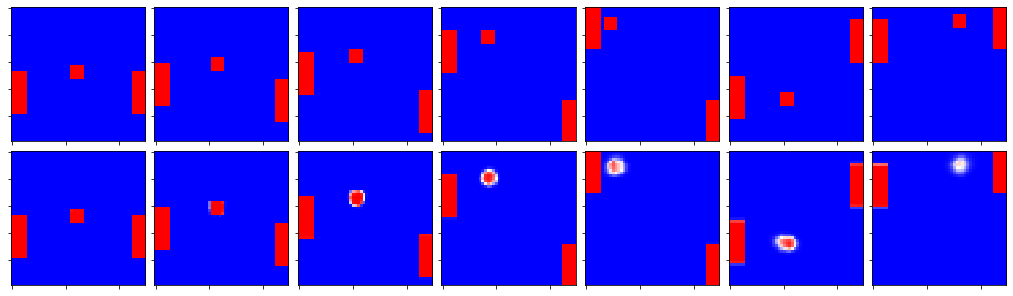

Epoch 206/250
100/100 [==============================] - 111s 1s/step - loss: 0.6406 - frames_loss: 0.0141 - lambda_1_loss: 0.6265 - frames_mean_squared_error: 0.0043 - frames_acc: 0.9940 - lambda_1_mean_squared_error: 506.1111 - lambda_1_acc: 0.9594 - val_loss: 0.5805 - val_frames_loss: 0.0137 - val_lambda_1_loss: 0.5668 - val_frames_mean_squared_error: 0.0042 - val_frames_acc: 0.9942 - val_lambda_1_mean_squared_error: 519.2039 - val_lambda_1_acc: 0.9633


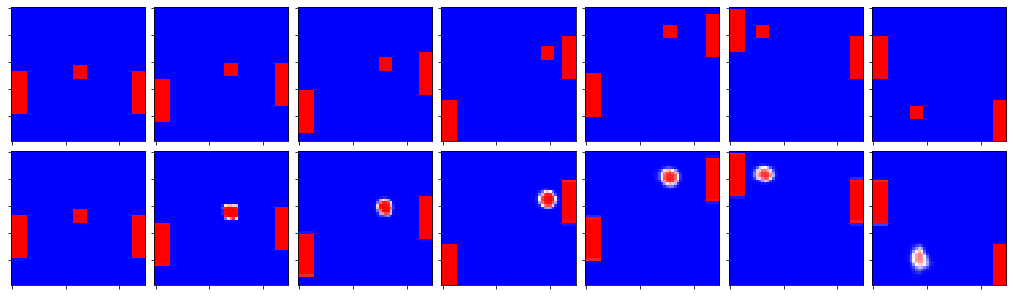

Epoch 207/250
100/100 [==============================] - 110s 1s/step - loss: 0.6534 - frames_loss: 0.0149 - lambda_1_loss: 0.6385 - frames_mean_squared_error: 0.0046 - frames_acc: 0.9936 - lambda_1_mean_squared_error: 498.1253 - lambda_1_acc: 0.9586 - val_loss: 1.0170 - val_frames_loss: 0.0134 - val_lambda_1_loss: 1.0036 - val_frames_mean_squared_error: 0.0041 - val_frames_acc: 0.9943 - val_lambda_1_mean_squared_error: 480.4079 - val_lambda_1_acc: 0.9349


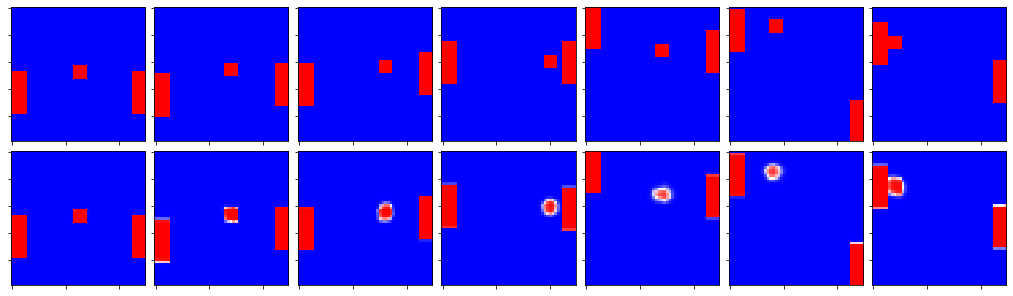

Epoch 208/250
100/100 [==============================] - 111s 1s/step - loss: 0.6960 - frames_loss: 0.0139 - lambda_1_loss: 0.6820 - frames_mean_squared_error: 0.0043 - frames_acc: 0.9941 - lambda_1_mean_squared_error: 501.0248 - lambda_1_acc: 0.9558 - val_loss: 0.5195 - val_frames_loss: 0.0149 - val_lambda_1_loss: 0.5046 - val_frames_mean_squared_error: 0.0046 - val_frames_acc: 0.9936 - val_lambda_1_mean_squared_error: 525.1622 - val_lambda_1_acc: 0.9673


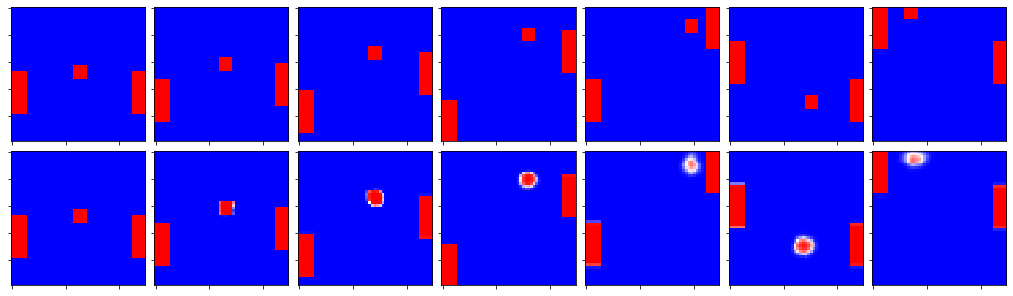

Epoch 209/250
100/100 [==============================] - 111s 1s/step - loss: 0.7314 - frames_loss: 0.0148 - lambda_1_loss: 0.7167 - frames_mean_squared_error: 0.0045 - frames_acc: 0.9937 - lambda_1_mean_squared_error: 496.7927 - lambda_1_acc: 0.9535 - val_loss: 0.9988 - val_frames_loss: 0.0140 - val_lambda_1_loss: 0.9848 - val_frames_mean_squared_error: 0.0043 - val_frames_acc: 0.9940 - val_lambda_1_mean_squared_error: 489.3875 - val_lambda_1_acc: 0.9362


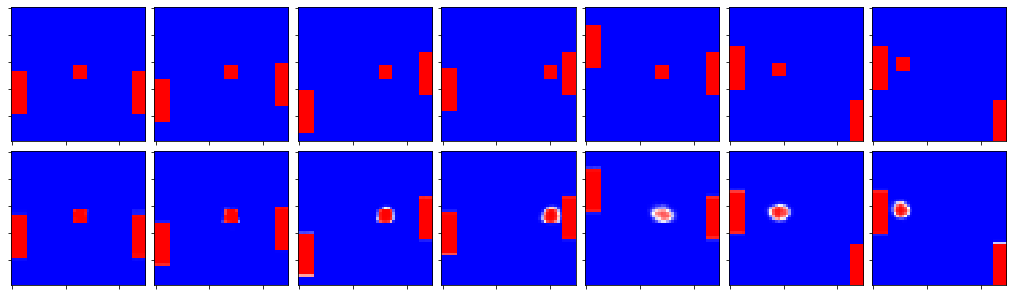

Epoch 210/250
100/100 [==============================] - 111s 1s/step - loss: 0.7045 - frames_loss: 0.0142 - lambda_1_loss: 0.6903 - frames_mean_squared_error: 0.0043 - frames_acc: 0.9940 - lambda_1_mean_squared_error: 504.0867 - lambda_1_acc: 0.9552 - val_loss: 0.4758 - val_frames_loss: 0.0182 - val_lambda_1_loss: 0.4576 - val_frames_mean_squared_error: 0.0054 - val_frames_acc: 0.9925 - val_lambda_1_mean_squared_error: 465.0817 - val_lambda_1_acc: 0.9703


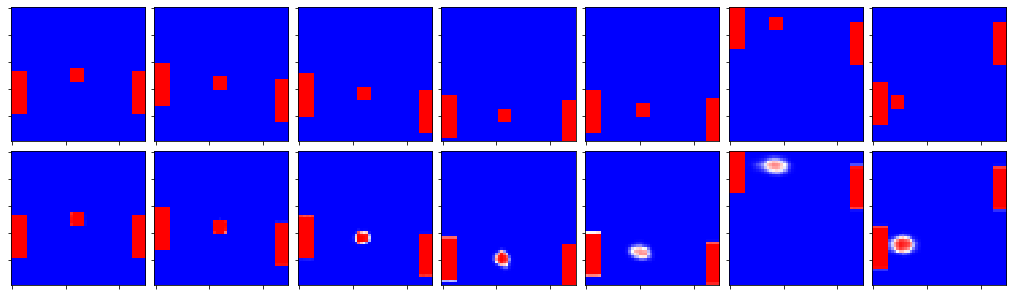

Epoch 211/250
100/100 [==============================] - 111s 1s/step - loss: 0.6708 - frames_loss: 0.0150 - lambda_1_loss: 0.6557 - frames_mean_squared_error: 0.0046 - frames_acc: 0.9936 - lambda_1_mean_squared_error: 467.6450 - lambda_1_acc: 0.9575 - val_loss: 0.8213 - val_frames_loss: 0.0135 - val_lambda_1_loss: 0.8078 - val_frames_mean_squared_error: 0.0041 - val_frames_acc: 0.9943 - val_lambda_1_mean_squared_error: 495.0534 - val_lambda_1_acc: 0.9476


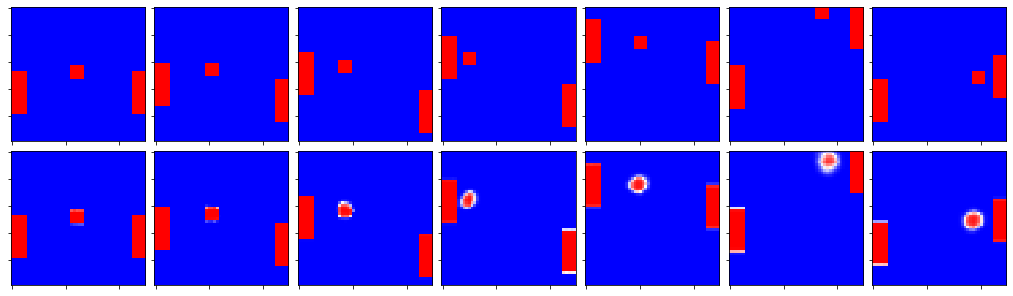

Epoch 212/250
100/100 [==============================] - 111s 1s/step - loss: 0.7304 - frames_loss: 0.0150 - lambda_1_loss: 0.7154 - frames_mean_squared_error: 0.0045 - frames_acc: 0.9937 - lambda_1_mean_squared_error: 487.0637 - lambda_1_acc: 0.9536 - val_loss: 0.3745 - val_frames_loss: 0.0149 - val_lambda_1_loss: 0.3596 - val_frames_mean_squared_error: 0.0046 - val_frames_acc: 0.9936 - val_lambda_1_mean_squared_error: 469.7456 - val_lambda_1_acc: 0.9767


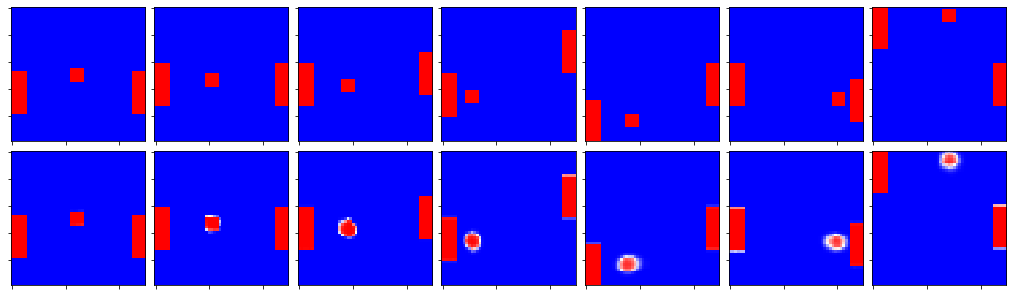

Epoch 213/250
100/100 [==============================] - 111s 1s/step - loss: 0.7046 - frames_loss: 0.0134 - lambda_1_loss: 0.6912 - frames_mean_squared_error: 0.0041 - frames_acc: 0.9943 - lambda_1_mean_squared_error: 484.0324 - lambda_1_acc: 0.9552 - val_loss: 0.7687 - val_frames_loss: 0.0137 - val_lambda_1_loss: 0.7551 - val_frames_mean_squared_error: 0.0042 - val_frames_acc: 0.9942 - val_lambda_1_mean_squared_error: 497.1341 - val_lambda_1_acc: 0.9510


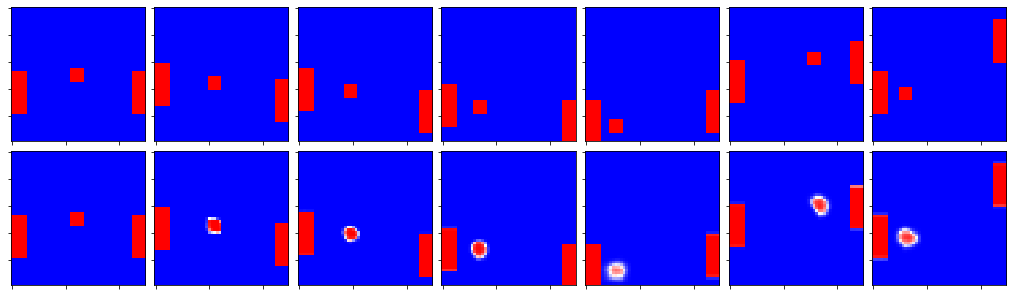

Epoch 214/250
100/100 [==============================] - 111s 1s/step - loss: 0.6722 - frames_loss: 0.0139 - lambda_1_loss: 0.6583 - frames_mean_squared_error: 0.0042 - frames_acc: 0.9941 - lambda_1_mean_squared_error: 497.2694 - lambda_1_acc: 0.9573 - val_loss: 0.4580 - val_frames_loss: 0.0136 - val_lambda_1_loss: 0.4444 - val_frames_mean_squared_error: 0.0041 - val_frames_acc: 0.9942 - val_lambda_1_mean_squared_error: 492.6832 - val_lambda_1_acc: 0.9712


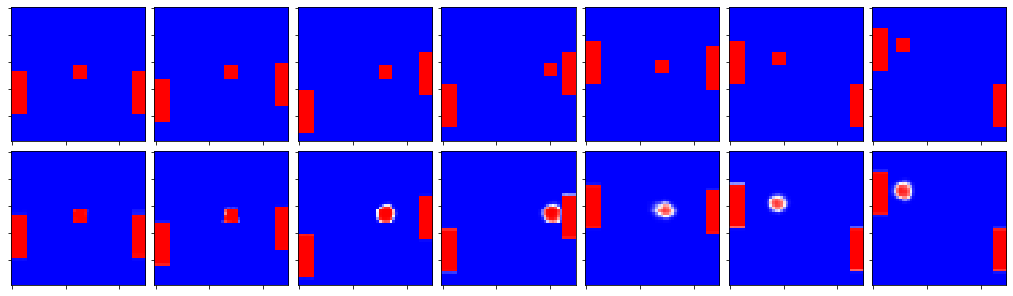

Epoch 215/250
100/100 [==============================] - 110s 1s/step - loss: 0.7418 - frames_loss: 0.0137 - lambda_1_loss: 0.7281 - frames_mean_squared_error: 0.0042 - frames_acc: 0.9942 - lambda_1_mean_squared_error: 517.1534 - lambda_1_acc: 0.9528 - val_loss: 0.6362 - val_frames_loss: 0.0149 - val_lambda_1_loss: 0.6214 - val_frames_mean_squared_error: 0.0045 - val_frames_acc: 0.9937 - val_lambda_1_mean_squared_error: 481.7288 - val_lambda_1_acc: 0.9597


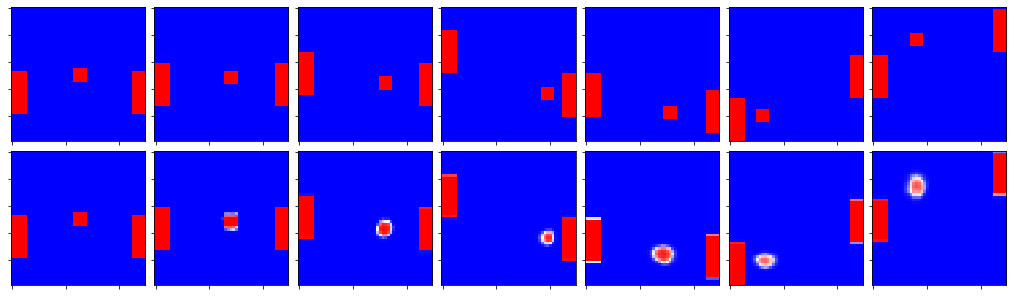

Epoch 216/250
100/100 [==============================] - 111s 1s/step - loss: 0.7441 - frames_loss: 0.0138 - lambda_1_loss: 0.7302 - frames_mean_squared_error: 0.0042 - frames_acc: 0.9941 - lambda_1_mean_squared_error: 497.1887 - lambda_1_acc: 0.9527 - val_loss: 0.3069 - val_frames_loss: 0.0132 - val_lambda_1_loss: 0.2937 - val_frames_mean_squared_error: 0.0040 - val_frames_acc: 0.9943 - val_lambda_1_mean_squared_error: 528.2672 - val_lambda_1_acc: 0.9810


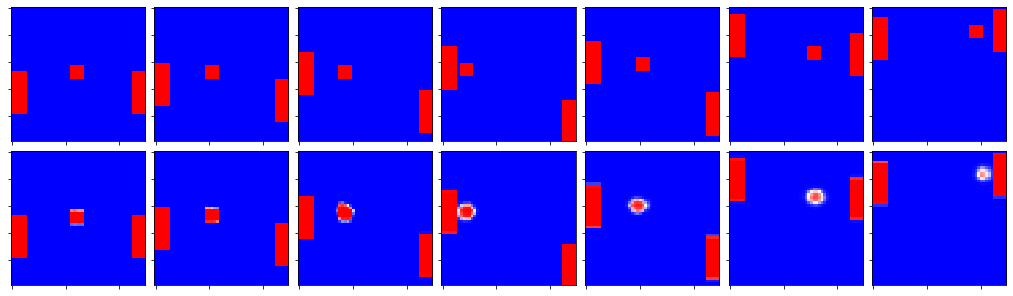

Epoch 217/250
100/100 [==============================] - 110s 1s/step - loss: 0.6536 - frames_loss: 0.0136 - lambda_1_loss: 0.6400 - frames_mean_squared_error: 0.0041 - frames_acc: 0.9942 - lambda_1_mean_squared_error: 511.8026 - lambda_1_acc: 0.9585 - val_loss: 0.2160 - val_frames_loss: 0.0146 - val_lambda_1_loss: 0.2015 - val_frames_mean_squared_error: 0.0045 - val_frames_acc: 0.9938 - val_lambda_1_mean_squared_error: 526.6391 - val_lambda_1_acc: 0.9869


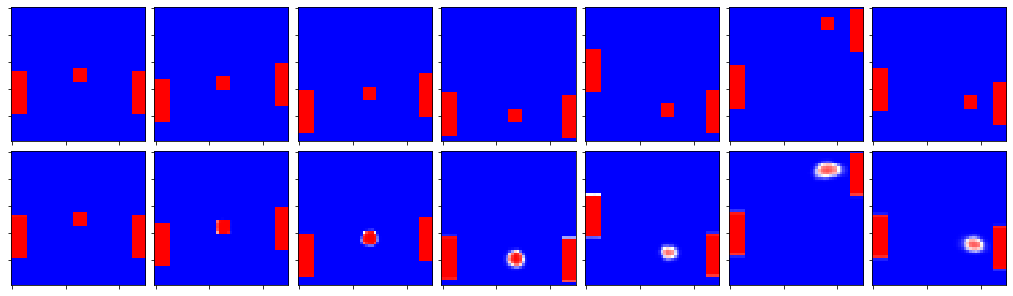

Epoch 218/250
100/100 [==============================] - 111s 1s/step - loss: 0.6838 - frames_loss: 0.0141 - lambda_1_loss: 0.6697 - frames_mean_squared_error: 0.0043 - frames_acc: 0.9940 - lambda_1_mean_squared_error: 496.4126 - lambda_1_acc: 0.9566 - val_loss: 0.6881 - val_frames_loss: 0.0140 - val_lambda_1_loss: 0.6741 - val_frames_mean_squared_error: 0.0043 - val_frames_acc: 0.9940 - val_lambda_1_mean_squared_error: 507.9058 - val_lambda_1_acc: 0.9563


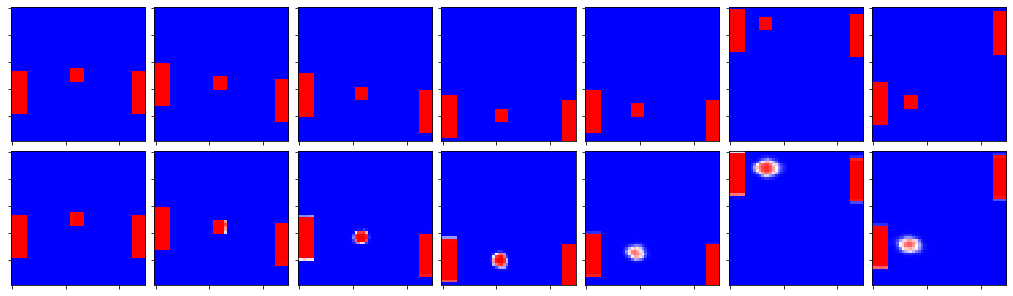

Epoch 219/250
100/100 [==============================] - 111s 1s/step - loss: 0.7785 - frames_loss: 0.0153 - lambda_1_loss: 0.7632 - frames_mean_squared_error: 0.0046 - frames_acc: 0.9935 - lambda_1_mean_squared_error: 470.5222 - lambda_1_acc: 0.9505 - val_loss: 0.6426 - val_frames_loss: 0.0156 - val_lambda_1_loss: 0.6270 - val_frames_mean_squared_error: 0.0048 - val_frames_acc: 0.9933 - val_lambda_1_mean_squared_error: 447.3192 - val_lambda_1_acc: 0.9594


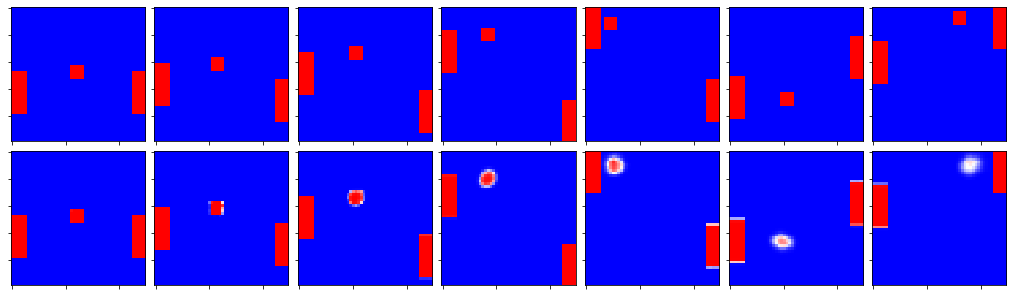

Epoch 220/250
100/100 [==============================] - 110s 1s/step - loss: 0.7162 - frames_loss: 0.0144 - lambda_1_loss: 0.7018 - frames_mean_squared_error: 0.0044 - frames_acc: 0.9939 - lambda_1_mean_squared_error: 450.9496 - lambda_1_acc: 0.9545 - val_loss: 0.7471 - val_frames_loss: 0.0128 - val_lambda_1_loss: 0.7343 - val_frames_mean_squared_error: 0.0039 - val_frames_acc: 0.9946 - val_lambda_1_mean_squared_error: 478.2157 - val_lambda_1_acc: 0.9524


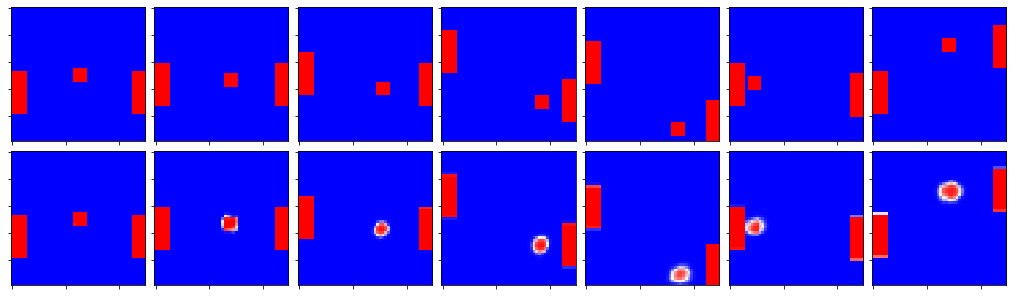

Epoch 221/250
100/100 [==============================] - 110s 1s/step - loss: 0.7338 - frames_loss: 0.0129 - lambda_1_loss: 0.7209 - frames_mean_squared_error: 0.0039 - frames_acc: 0.9945 - lambda_1_mean_squared_error: 497.0828 - lambda_1_acc: 0.9533 - val_loss: 0.9478 - val_frames_loss: 0.0138 - val_lambda_1_loss: 0.9339 - val_frames_mean_squared_error: 0.0042 - val_frames_acc: 0.9941 - val_lambda_1_mean_squared_error: 523.7667 - val_lambda_1_acc: 0.9395


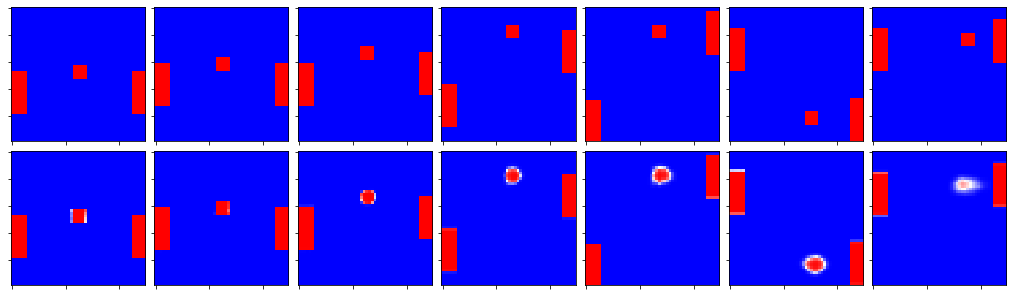

Epoch 222/250
100/100 [==============================] - 110s 1s/step - loss: 0.7093 - frames_loss: 0.0133 - lambda_1_loss: 0.6960 - frames_mean_squared_error: 0.0040 - frames_acc: 0.9944 - lambda_1_mean_squared_error: 502.8465 - lambda_1_acc: 0.9549 - val_loss: 0.5946 - val_frames_loss: 0.0147 - val_lambda_1_loss: 0.5799 - val_frames_mean_squared_error: 0.0044 - val_frames_acc: 0.9940 - val_lambda_1_mean_squared_error: 481.7353 - val_lambda_1_acc: 0.9624


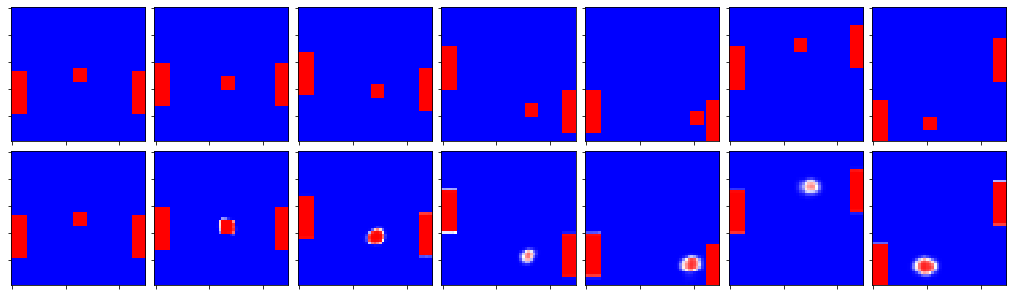

Epoch 223/250
100/100 [==============================] - 111s 1s/step - loss: 0.7192 - frames_loss: 0.0135 - lambda_1_loss: 0.7057 - frames_mean_squared_error: 0.0041 - frames_acc: 0.9943 - lambda_1_mean_squared_error: 501.7755 - lambda_1_acc: 0.9542 - val_loss: 0.6489 - val_frames_loss: 0.0143 - val_lambda_1_loss: 0.6345 - val_frames_mean_squared_error: 0.0044 - val_frames_acc: 0.9938 - val_lambda_1_mean_squared_error: 489.6618 - val_lambda_1_acc: 0.9589


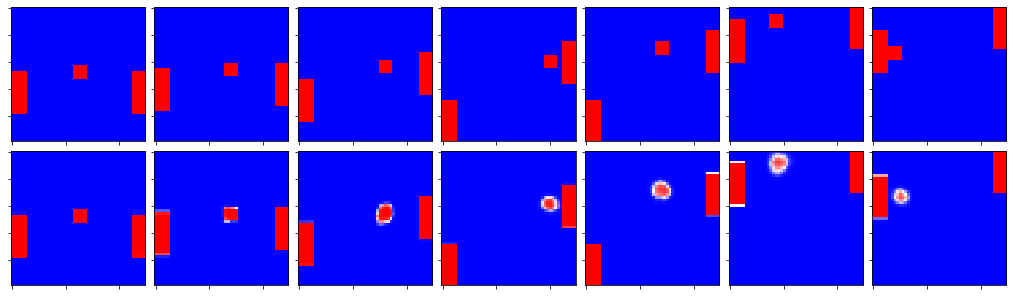

Epoch 224/250
100/100 [==============================] - 111s 1s/step - loss: 0.6765 - frames_loss: 0.0143 - lambda_1_loss: 0.6622 - frames_mean_squared_error: 0.0043 - frames_acc: 0.9939 - lambda_1_mean_squared_error: 469.4937 - lambda_1_acc: 0.9571 - val_loss: 0.4439 - val_frames_loss: 0.0127 - val_lambda_1_loss: 0.4312 - val_frames_mean_squared_error: 0.0038 - val_frames_acc: 0.9946 - val_lambda_1_mean_squared_error: 472.9056 - val_lambda_1_acc: 0.9720


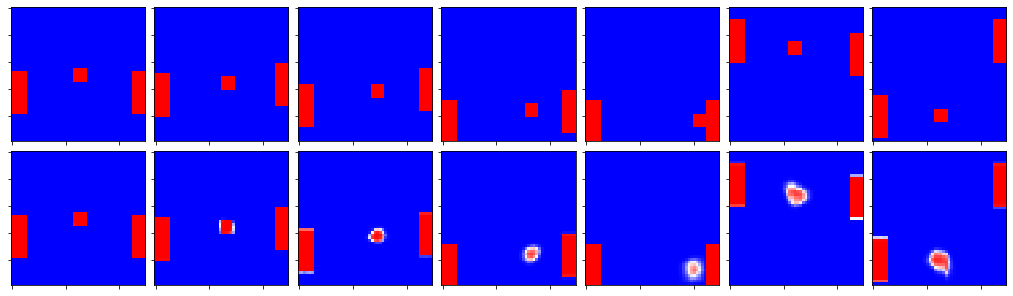

Epoch 225/250
100/100 [==============================] - 111s 1s/step - loss: 0.6238 - frames_loss: 0.0131 - lambda_1_loss: 0.6107 - frames_mean_squared_error: 0.0040 - frames_acc: 0.9945 - lambda_1_mean_squared_error: 490.6537 - lambda_1_acc: 0.9604 - val_loss: 0.9390 - val_frames_loss: 0.0126 - val_lambda_1_loss: 0.9264 - val_frames_mean_squared_error: 0.0038 - val_frames_acc: 0.9947 - val_lambda_1_mean_squared_error: 486.3605 - val_lambda_1_acc: 0.9399


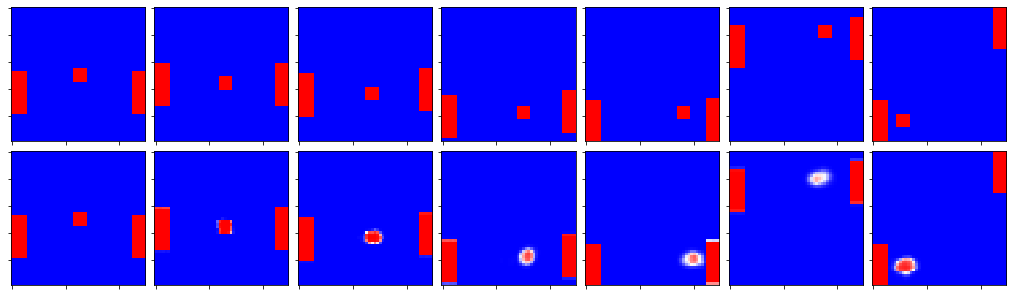

Epoch 226/250
100/100 [==============================] - 111s 1s/step - loss: 0.7051 - frames_loss: 0.0133 - lambda_1_loss: 0.6918 - frames_mean_squared_error: 0.0041 - frames_acc: 0.9943 - lambda_1_mean_squared_error: 483.6745 - lambda_1_acc: 0.9552 - val_loss: 0.3643 - val_frames_loss: 0.0141 - val_lambda_1_loss: 0.3502 - val_frames_mean_squared_error: 0.0043 - val_frames_acc: 0.9940 - val_lambda_1_mean_squared_error: 478.9337 - val_lambda_1_acc: 0.9773


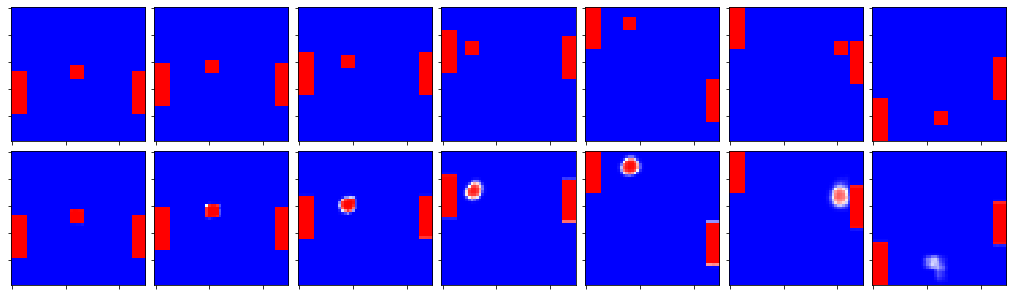

Epoch 227/250
100/100 [==============================] - 111s 1s/step - loss: 0.6863 - frames_loss: 0.0133 - lambda_1_loss: 0.6731 - frames_mean_squared_error: 0.0041 - frames_acc: 0.9943 - lambda_1_mean_squared_error: 500.8484 - lambda_1_acc: 0.9564 - val_loss: 0.8096 - val_frames_loss: 0.0131 - val_lambda_1_loss: 0.7965 - val_frames_mean_squared_error: 0.0040 - val_frames_acc: 0.9944 - val_lambda_1_mean_squared_error: 487.2002 - val_lambda_1_acc: 0.9484


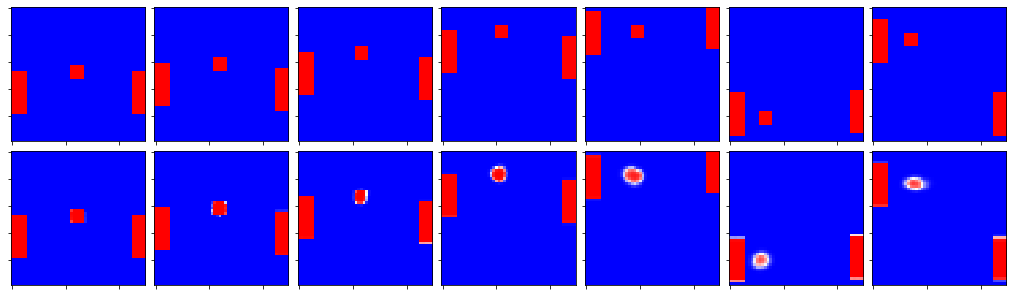

Epoch 228/250
100/100 [==============================] - 111s 1s/step - loss: 0.6655 - frames_loss: 0.0145 - lambda_1_loss: 0.6510 - frames_mean_squared_error: 0.0044 - frames_acc: 0.9938 - lambda_1_mean_squared_error: 478.8507 - lambda_1_acc: 0.9578 - val_loss: 0.2749 - val_frames_loss: 0.0151 - val_lambda_1_loss: 0.2598 - val_frames_mean_squared_error: 0.0046 - val_frames_acc: 0.9935 - val_lambda_1_mean_squared_error: 443.9554 - val_lambda_1_acc: 0.9832


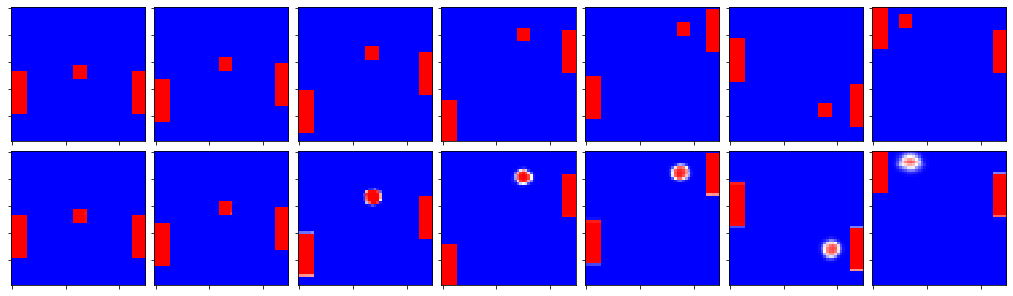

Epoch 229/250
100/100 [==============================] - 111s 1s/step - loss: 0.6677 - frames_loss: 0.0132 - lambda_1_loss: 0.6545 - frames_mean_squared_error: 0.0040 - frames_acc: 0.9944 - lambda_1_mean_squared_error: 464.0638 - lambda_1_acc: 0.9576 - val_loss: 0.5553 - val_frames_loss: 0.0130 - val_lambda_1_loss: 0.5423 - val_frames_mean_squared_error: 0.0040 - val_frames_acc: 0.9945 - val_lambda_1_mean_squared_error: 491.9393 - val_lambda_1_acc: 0.9648


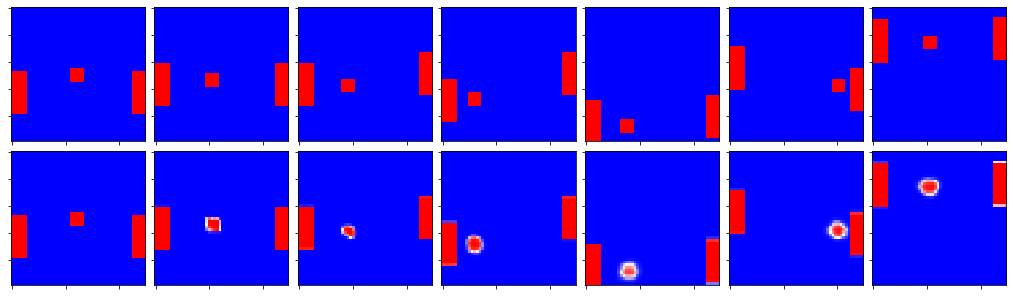

Epoch 230/250
100/100 [==============================] - 110s 1s/step - loss: 0.7568 - frames_loss: 0.0134 - lambda_1_loss: 0.7434 - frames_mean_squared_error: 0.0041 - frames_acc: 0.9943 - lambda_1_mean_squared_error: 481.5385 - lambda_1_acc: 0.9518 - val_loss: 0.7310 - val_frames_loss: 0.0136 - val_lambda_1_loss: 0.7174 - val_frames_mean_squared_error: 0.0041 - val_frames_acc: 0.9942 - val_lambda_1_mean_squared_error: 489.5895 - val_lambda_1_acc: 0.9535


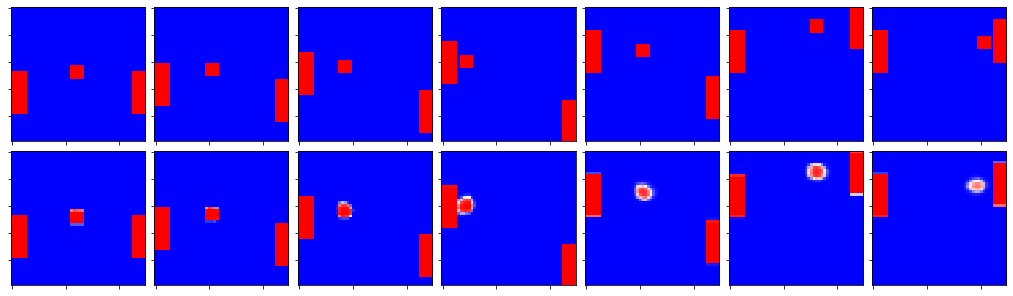

Epoch 231/250
100/100 [==============================] - 111s 1s/step - loss: 0.6611 - frames_loss: 0.0141 - lambda_1_loss: 0.6471 - frames_mean_squared_error: 0.0043 - frames_acc: 0.9940 - lambda_1_mean_squared_error: 469.8549 - lambda_1_acc: 0.9580 - val_loss: 0.9248 - val_frames_loss: 0.0134 - val_lambda_1_loss: 0.9113 - val_frames_mean_squared_error: 0.0041 - val_frames_acc: 0.9943 - val_lambda_1_mean_squared_error: 465.5322 - val_lambda_1_acc: 0.9409


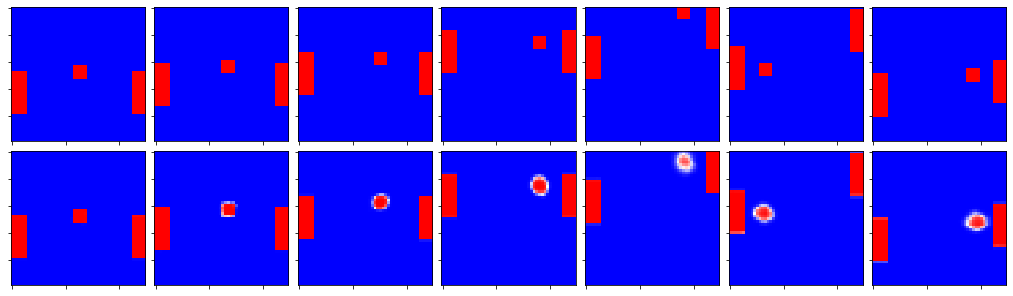

Epoch 232/250
100/100 [==============================] - 111s 1s/step - loss: 0.7233 - frames_loss: 0.0154 - lambda_1_loss: 0.7079 - frames_mean_squared_error: 0.0046 - frames_acc: 0.9935 - lambda_1_mean_squared_error: 443.8052 - lambda_1_acc: 0.9541 - val_loss: 0.4735 - val_frames_loss: 0.0197 - val_lambda_1_loss: 0.4538 - val_frames_mean_squared_error: 0.0059 - val_frames_acc: 0.9917 - val_lambda_1_mean_squared_error: 418.4301 - val_lambda_1_acc: 0.9706


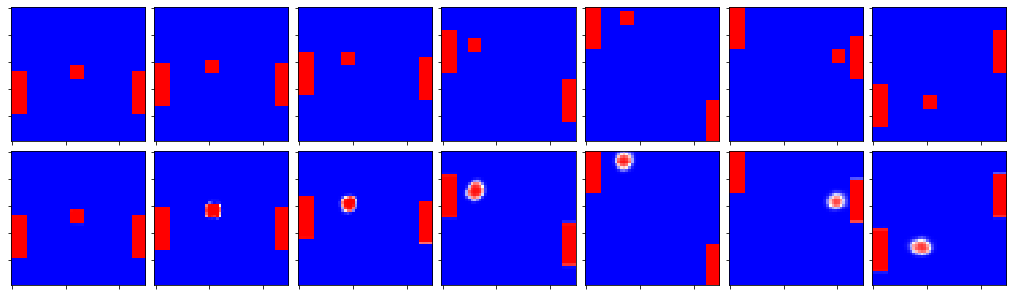

Epoch 233/250
100/100 [==============================] - 111s 1s/step - loss: 0.7772 - frames_loss: 0.0145 - lambda_1_loss: 0.7627 - frames_mean_squared_error: 0.0044 - frames_acc: 0.9939 - lambda_1_mean_squared_error: 414.6393 - lambda_1_acc: 0.9506 - val_loss: 0.7552 - val_frames_loss: 0.0133 - val_lambda_1_loss: 0.7419 - val_frames_mean_squared_error: 0.0040 - val_frames_acc: 0.9944 - val_lambda_1_mean_squared_error: 448.1935 - val_lambda_1_acc: 0.9519


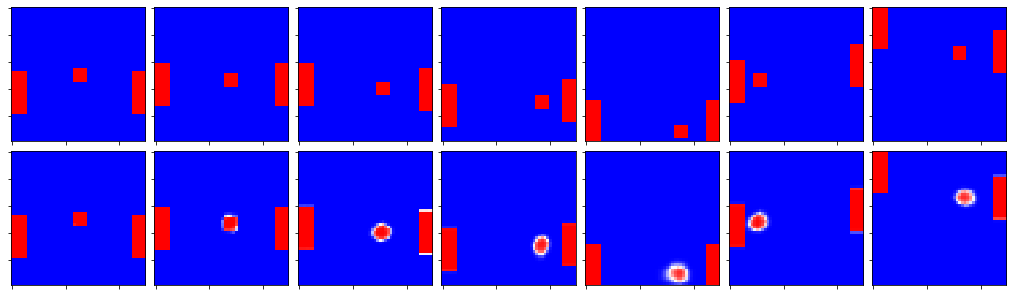

Epoch 234/250
100/100 [==============================] - 111s 1s/step - loss: 0.7010 - frames_loss: 0.0138 - lambda_1_loss: 0.6872 - frames_mean_squared_error: 0.0042 - frames_acc: 0.9941 - lambda_1_mean_squared_error: 436.7686 - lambda_1_acc: 0.9555 - val_loss: 0.6056 - val_frames_loss: 0.0143 - val_lambda_1_loss: 0.5912 - val_frames_mean_squared_error: 0.0044 - val_frames_acc: 0.9939 - val_lambda_1_mean_squared_error: 434.3388 - val_lambda_1_acc: 0.9617


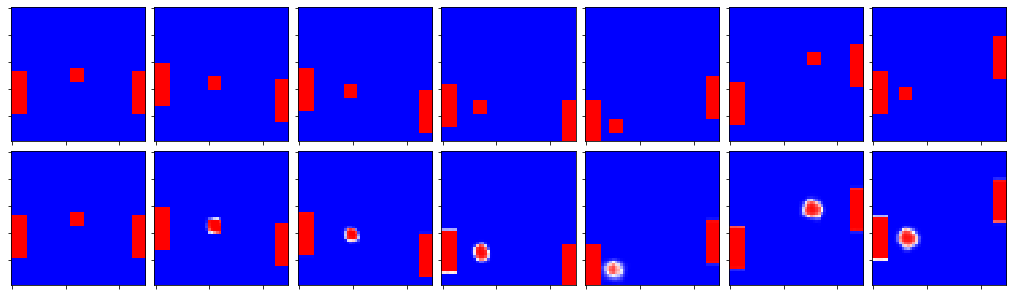

Epoch 235/250
100/100 [==============================] - 111s 1s/step - loss: 0.6945 - frames_loss: 0.0129 - lambda_1_loss: 0.6817 - frames_mean_squared_error: 0.0039 - frames_acc: 0.9946 - lambda_1_mean_squared_error: 452.2146 - lambda_1_acc: 0.9558 - val_loss: 1.2153 - val_frames_loss: 0.0121 - val_lambda_1_loss: 1.2032 - val_frames_mean_squared_error: 0.0037 - val_frames_acc: 0.9949 - val_lambda_1_mean_squared_error: 501.1964 - val_lambda_1_acc: 0.9220


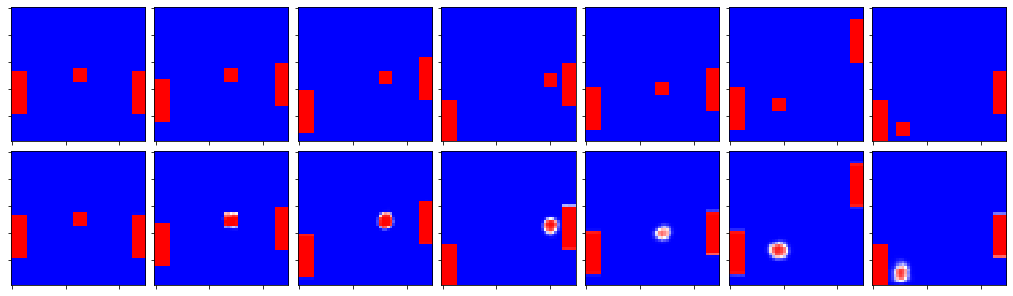

Epoch 236/250
100/100 [==============================] - 111s 1s/step - loss: 0.7293 - frames_loss: 0.0127 - lambda_1_loss: 0.7166 - frames_mean_squared_error: 0.0039 - frames_acc: 0.9946 - lambda_1_mean_squared_error: 475.9845 - lambda_1_acc: 0.9535 - val_loss: 0.5068 - val_frames_loss: 0.0134 - val_lambda_1_loss: 0.4933 - val_frames_mean_squared_error: 0.0041 - val_frames_acc: 0.9942 - val_lambda_1_mean_squared_error: 460.2866 - val_lambda_1_acc: 0.9680


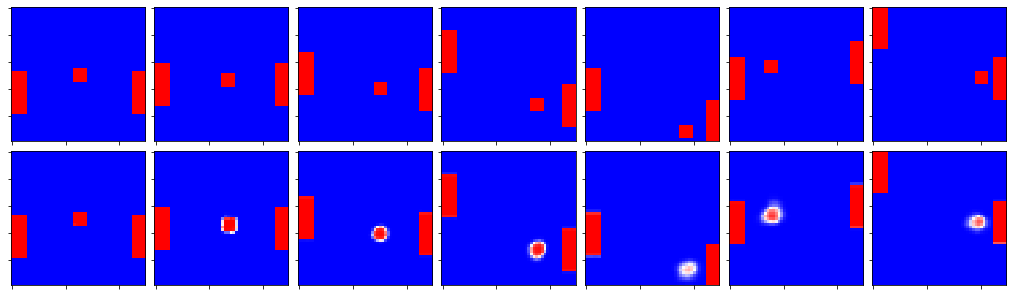

Epoch 237/250
100/100 [==============================] - 111s 1s/step - loss: 0.7158 - frames_loss: 0.0138 - lambda_1_loss: 0.7020 - frames_mean_squared_error: 0.0042 - frames_acc: 0.9942 - lambda_1_mean_squared_error: 470.8295 - lambda_1_acc: 0.9545 - val_loss: 0.8936 - val_frames_loss: 0.0142 - val_lambda_1_loss: 0.8793 - val_frames_mean_squared_error: 0.0043 - val_frames_acc: 0.9940 - val_lambda_1_mean_squared_error: 453.6211 - val_lambda_1_acc: 0.9430


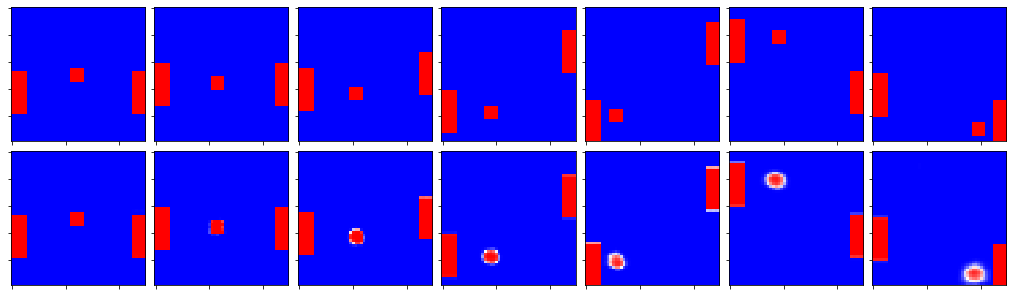

Epoch 238/250
100/100 [==============================] - 111s 1s/step - loss: 0.7153 - frames_loss: 0.0131 - lambda_1_loss: 0.7022 - frames_mean_squared_error: 0.0040 - frames_acc: 0.9945 - lambda_1_mean_squared_error: 450.5268 - lambda_1_acc: 0.9545 - val_loss: 0.5278 - val_frames_loss: 0.0119 - val_lambda_1_loss: 0.5159 - val_frames_mean_squared_error: 0.0036 - val_frames_acc: 0.9951 - val_lambda_1_mean_squared_error: 461.6730 - val_lambda_1_acc: 0.9666


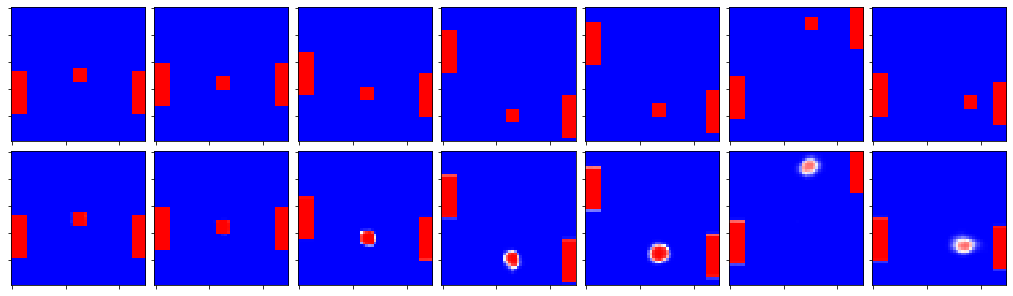

Epoch 239/250
100/100 [==============================] - 111s 1s/step - loss: 0.6886 - frames_loss: 0.0124 - lambda_1_loss: 0.6762 - frames_mean_squared_error: 0.0038 - frames_acc: 0.9948 - lambda_1_mean_squared_error: 485.7660 - lambda_1_acc: 0.9562 - val_loss: 0.6020 - val_frames_loss: 0.0145 - val_lambda_1_loss: 0.5875 - val_frames_mean_squared_error: 0.0045 - val_frames_acc: 0.9937 - val_lambda_1_mean_squared_error: 446.1591 - val_lambda_1_acc: 0.9619


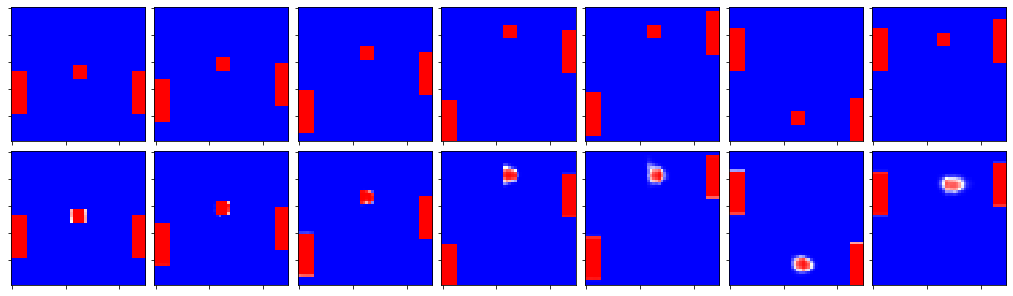

Epoch 240/250
100/100 [==============================] - 111s 1s/step - loss: 0.7336 - frames_loss: 0.0132 - lambda_1_loss: 0.7204 - frames_mean_squared_error: 0.0040 - frames_acc: 0.9944 - lambda_1_mean_squared_error: 469.0118 - lambda_1_acc: 0.9533 - val_loss: 1.0153 - val_frames_loss: 0.0135 - val_lambda_1_loss: 1.0017 - val_frames_mean_squared_error: 0.0041 - val_frames_acc: 0.9942 - val_lambda_1_mean_squared_error: 463.1518 - val_lambda_1_acc: 0.9351


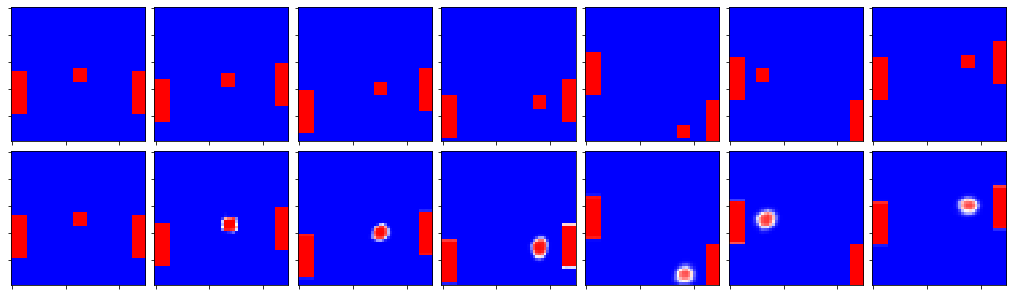

Epoch 241/250
100/100 [==============================] - 110s 1s/step - loss: 0.6039 - frames_loss: 0.0129 - lambda_1_loss: 0.5910 - frames_mean_squared_error: 0.0039 - frames_acc: 0.9945 - lambda_1_mean_squared_error: 468.2577 - lambda_1_acc: 0.9617 - val_loss: 1.2025 - val_frames_loss: 0.0181 - val_lambda_1_loss: 1.1844 - val_frames_mean_squared_error: 0.0053 - val_frames_acc: 0.9927 - val_lambda_1_mean_squared_error: 478.9254 - val_lambda_1_acc: 0.9232


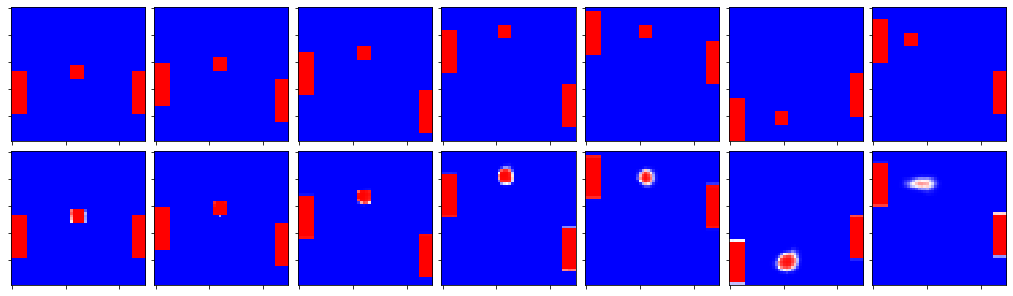

Epoch 242/250
100/100 [==============================] - 111s 1s/step - loss: 0.7535 - frames_loss: 0.0136 - lambda_1_loss: 0.7399 - frames_mean_squared_error: 0.0041 - frames_acc: 0.9942 - lambda_1_mean_squared_error: 449.7474 - lambda_1_acc: 0.9520 - val_loss: 0.3831 - val_frames_loss: 0.0121 - val_lambda_1_loss: 0.3709 - val_frames_mean_squared_error: 0.0037 - val_frames_acc: 0.9949 - val_lambda_1_mean_squared_error: 449.5380 - val_lambda_1_acc: 0.9760


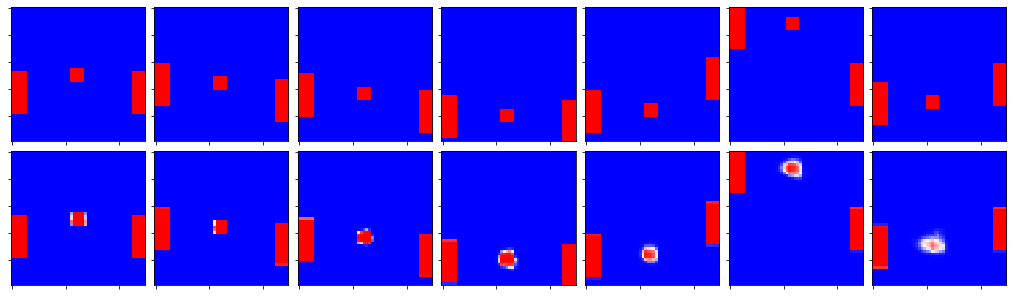

Epoch 243/250
100/100 [==============================] - 110s 1s/step - loss: 0.6914 - frames_loss: 0.0130 - lambda_1_loss: 0.6785 - frames_mean_squared_error: 0.0039 - frames_acc: 0.9945 - lambda_1_mean_squared_error: 463.3097 - lambda_1_acc: 0.9560 - val_loss: 1.2461 - val_frames_loss: 0.0147 - val_lambda_1_loss: 1.2314 - val_frames_mean_squared_error: 0.0043 - val_frames_acc: 0.9940 - val_lambda_1_mean_squared_error: 462.7592 - val_lambda_1_acc: 0.9202


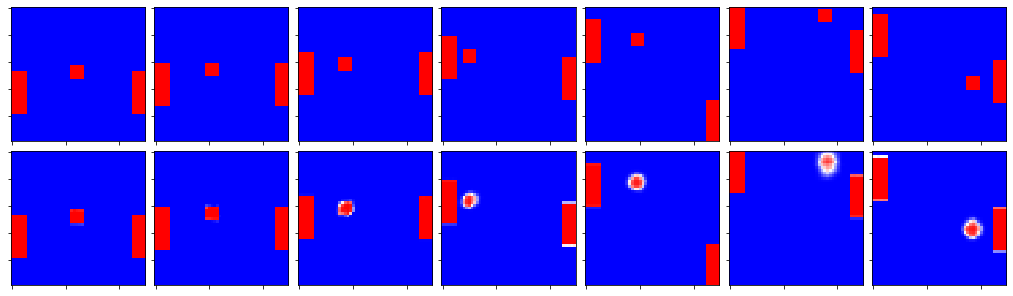

Epoch 244/250
100/100 [==============================] - 111s 1s/step - loss: 0.7323 - frames_loss: 0.0131 - lambda_1_loss: 0.7192 - frames_mean_squared_error: 0.0040 - frames_acc: 0.9945 - lambda_1_mean_squared_error: 454.5132 - lambda_1_acc: 0.9534 - val_loss: 1.1888 - val_frames_loss: 0.0120 - val_lambda_1_loss: 1.1768 - val_frames_mean_squared_error: 0.0036 - val_frames_acc: 0.9950 - val_lambda_1_mean_squared_error: 463.7361 - val_lambda_1_acc: 0.9237


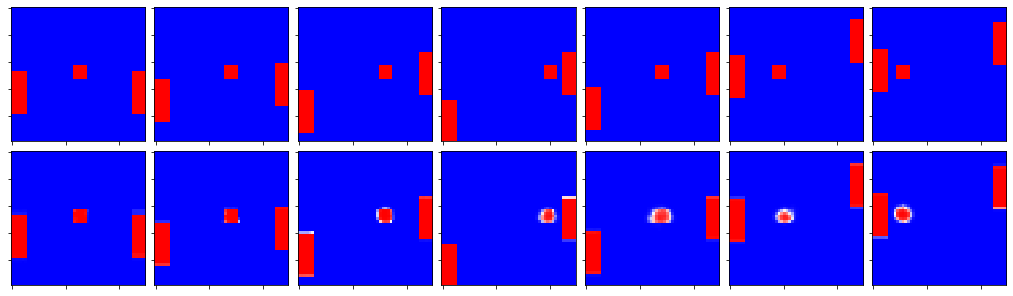

Epoch 245/250
100/100 [==============================] - 111s 1s/step - loss: 0.7137 - frames_loss: 0.0119 - lambda_1_loss: 0.7018 - frames_mean_squared_error: 0.0036 - frames_acc: 0.9950 - lambda_1_mean_squared_error: 480.5682 - lambda_1_acc: 0.9545 - val_loss: 0.5356 - val_frames_loss: 0.0121 - val_lambda_1_loss: 0.5235 - val_frames_mean_squared_error: 0.0037 - val_frames_acc: 0.9949 - val_lambda_1_mean_squared_error: 486.4485 - val_lambda_1_acc: 0.9661


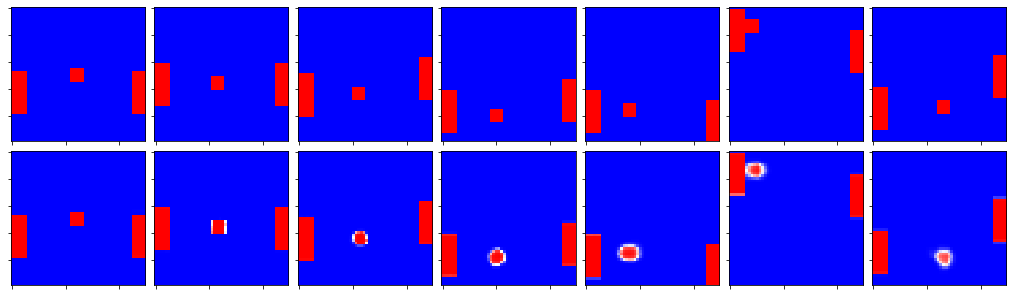

Epoch 246/250
100/100 [==============================] - 111s 1s/step - loss: 0.6661 - frames_loss: 0.0132 - lambda_1_loss: 0.6529 - frames_mean_squared_error: 0.0040 - frames_acc: 0.9944 - lambda_1_mean_squared_error: 462.1478 - lambda_1_acc: 0.9577 - val_loss: 0.2770 - val_frames_loss: 0.0115 - val_lambda_1_loss: 0.2655 - val_frames_mean_squared_error: 0.0035 - val_frames_acc: 0.9952 - val_lambda_1_mean_squared_error: 467.2439 - val_lambda_1_acc: 0.9828


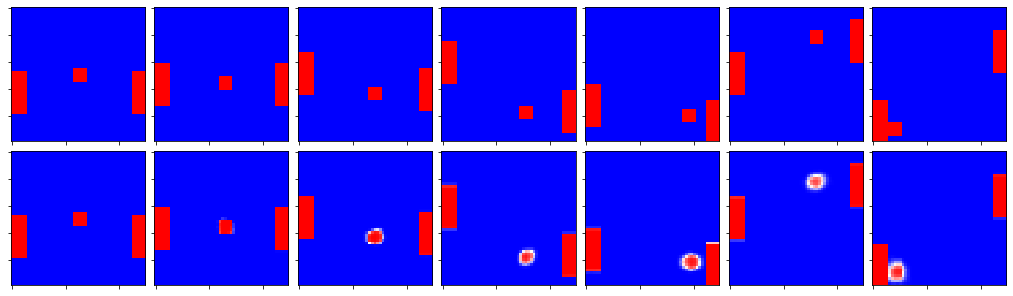

Epoch 247/250
100/100 [==============================] - 111s 1s/step - loss: 0.7043 - frames_loss: 0.0121 - lambda_1_loss: 0.6922 - frames_mean_squared_error: 0.0036 - frames_acc: 0.9950 - lambda_1_mean_squared_error: 489.1931 - lambda_1_acc: 0.9551 - val_loss: 0.3893 - val_frames_loss: 0.0222 - val_lambda_1_loss: 0.3672 - val_frames_mean_squared_error: 0.0058 - val_frames_acc: 0.9921 - val_lambda_1_mean_squared_error: 429.8645 - val_lambda_1_acc: 0.9762


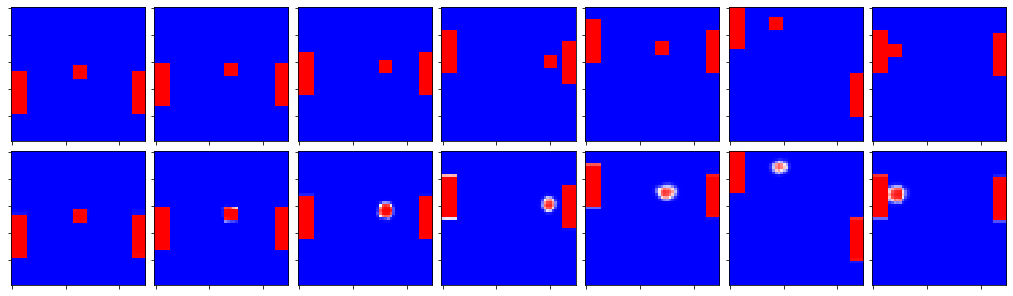

Epoch 248/250
100/100 [==============================] - 111s 1s/step - loss: 0.7250 - frames_loss: 0.0149 - lambda_1_loss: 0.7101 - frames_mean_squared_error: 0.0045 - frames_acc: 0.9937 - lambda_1_mean_squared_error: 396.5885 - lambda_1_acc: 0.9540 - val_loss: 1.1042 - val_frames_loss: 0.0121 - val_lambda_1_loss: 1.0921 - val_frames_mean_squared_error: 0.0037 - val_frames_acc: 0.9949 - val_lambda_1_mean_squared_error: 428.9263 - val_lambda_1_acc: 0.9292


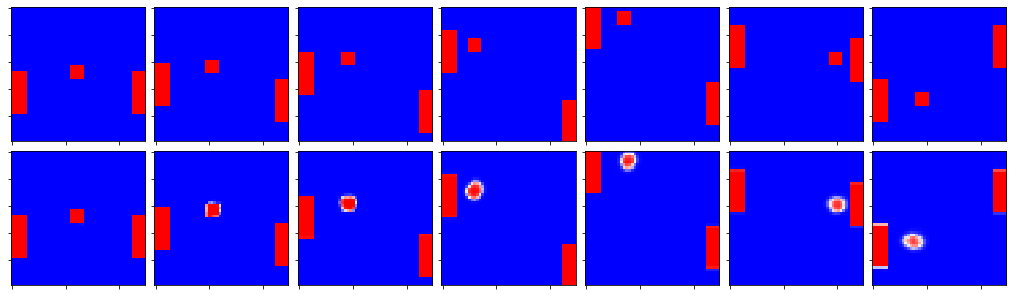

Epoch 249/250
100/100 [==============================] - 111s 1s/step - loss: 0.6617 - frames_loss: 0.0128 - lambda_1_loss: 0.6489 - frames_mean_squared_error: 0.0039 - frames_acc: 0.9946 - lambda_1_mean_squared_error: 441.6119 - lambda_1_acc: 0.9579 - val_loss: 0.8666 - val_frames_loss: 0.0117 - val_lambda_1_loss: 0.8548 - val_frames_mean_squared_error: 0.0036 - val_frames_acc: 0.9950 - val_lambda_1_mean_squared_error: 461.0322 - val_lambda_1_acc: 0.9446


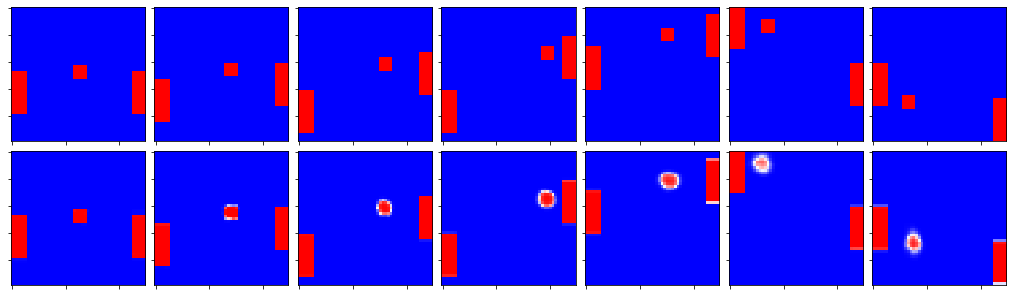

Epoch 250/250
100/100 [==============================] - 110s 1s/step - loss: 0.7332 - frames_loss: 0.0127 - lambda_1_loss: 0.7205 - frames_mean_squared_error: 0.0039 - frames_acc: 0.9946 - lambda_1_mean_squared_error: 457.2189 - lambda_1_acc: 0.9533 - val_loss: 0.5219 - val_frames_loss: 0.0154 - val_lambda_1_loss: 0.5065 - val_frames_mean_squared_error: 0.0046 - val_frames_acc: 0.9937 - val_lambda_1_mean_squared_error: 466.6840 - val_lambda_1_acc: 0.9672


In [25]:
input_generator = make_dataset(bs=32)

model.net.fit_generator(
    generator=input_generator,
    validation_data=input_generator,
    validation_steps=2,
    steps_per_epoch=100,
    epochs=250,
    callbacks=callbacks
)

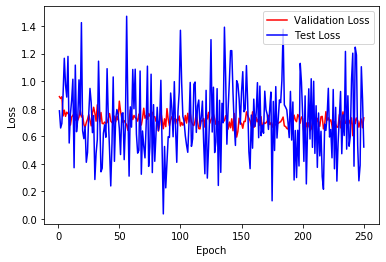

In [26]:
training_loss = model.net.history.history['loss']
test_loss = model.net.history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r')
plt.plot(epoch_count, test_loss, 'b')
plt.legend(['Validation Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

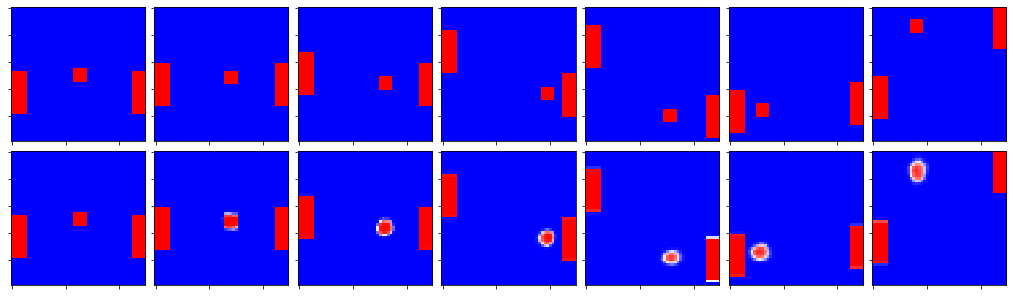

In [27]:
plot_pairwise_frames(frame_nums)

In [28]:
stateful = model.copy_in_stateful_model()
stateful.init(0.4)
t = 0

stateful.net.save('STATEFUL_LSTM3_PONG_RELU_VARIED_INPUT.hdf5')

62

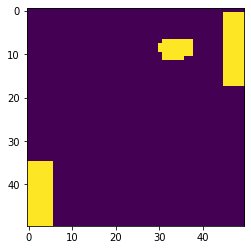

In [90]:
t += 1
frame, _ = stateful.single_step_predict([-1, 1])

plt.imshow(frame > 0.01)
t